In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as sps

sns.set()

confirmed_min = 500
dead_min = 10

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
us_state_dict = pd.read_pickle('us_state_dict.pkl')
ny = us_state_dict['New York']
ny.index = pd.DatetimeIndex(ny.index)
ny.sort_index(inplace=True)
ny

confirmed  deceased      inc  dead_inc    factor  dead_factor  \
2020-03-14      525.0       2.0    104.0       2.0  1.247031          NaN   
2020-03-15      732.0       3.0    207.0       1.0  1.394286     1.500000   
2020-03-16      967.0      10.0    235.0       7.0  1.321038     3.333333   
2020-03-17     1706.0      13.0    739.0       3.0  1.764219     1.300000   
2020-03-18     2495.0      16.0    789.0       3.0  1.462485     1.230769   
...               ...       ...      ...       ...       ...          ...   
2020-08-22   429165.0   32871.0   7829.0      90.0  1.018581     1.002745   
2020-08-23   429737.0   32883.0  29438.0     552.0  1.073540     1.017073   
2020-08-24   430145.0   32887.0  65180.0    3403.0  1.178592     1.115419   
2020-08-25   430774.0   32918.0  46199.0    2009.0  1.120130     1.064997   
2020-08-26   431340.0   32921.0    566.0       3.0  1.001314     1.000091   

                density    gdp  pct_dead    conf_per_M   dead_per_M  
2020-03-14  1068.424744  89076  0.380952     27.005521     0.102878  
2020-03-15  1068.424744  89076  0.409836     37.653413     0.154317  
2020-03-16  1068.424744  89076  1.034126     49.741598     0.514391  
2020-03-17  1068.424744  89076  0.762016     87.755085     0.668708  
2020-03-18  1068.424744  89076  0.641283    128.340525     0.823025  
...                 ...    ...       ...           ...          ...  
2020-08-22  1068.424744  89076  7.659292  22075.856297  1690.854269  
2020-08-23  1068.424744  89076  7.651889  22105.279456  1691.471538  
2020-08-24  1068.424744  89076  7.645561  22126.266604  1691.677294  
2020-08-25  1068.424744  89076  7.641594  22158.621790  1693.271906  
2020-08-26  1068.424744  89076  7.632262  22187.736314  1693.426223  

[166 rows x 11 columns]

In [3]:
dick = pd.read_pickle('country_data.pkl')

def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})

dick['New York'] = ny

swe = dick['Sweden']
us = dick['US']
india = dick['India']

swe_population = country_populations.loc['Sweden','population']
swe['conf_per_M'] = swe['confirmed'] / (swe_population / 1e6)
swe['dead_per_M'] = swe['deceased'] / (swe_population / 1e6)
us['dead_per_M'] = us['deceased'] / (country_populations.loc['US','population'] / 1e6) 


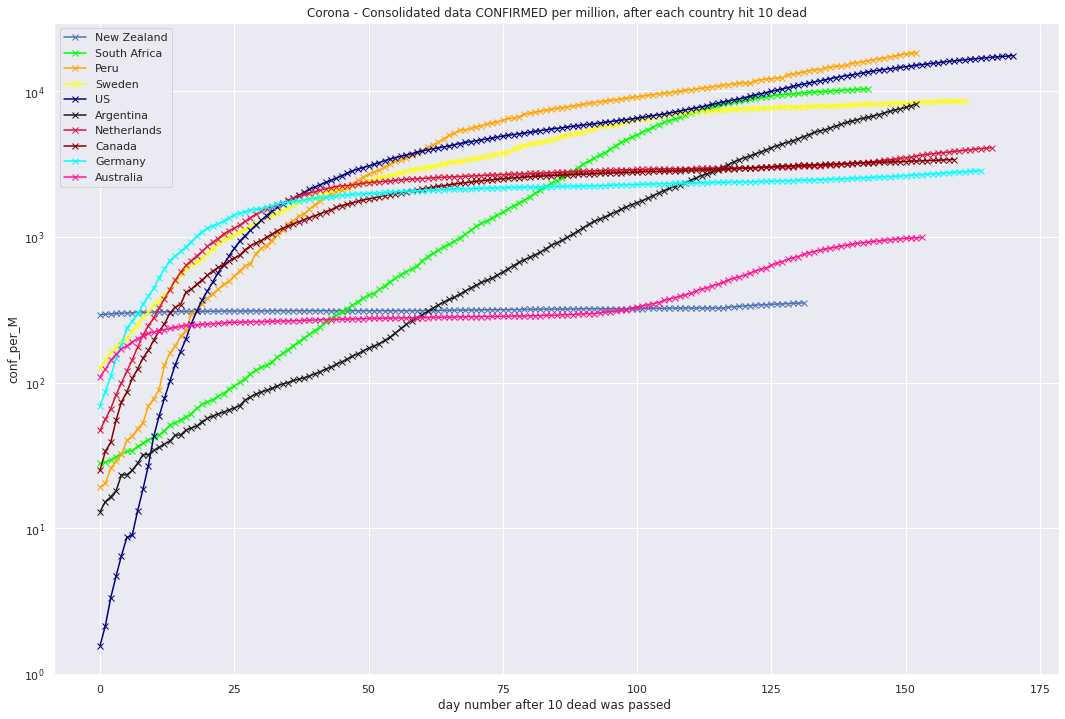

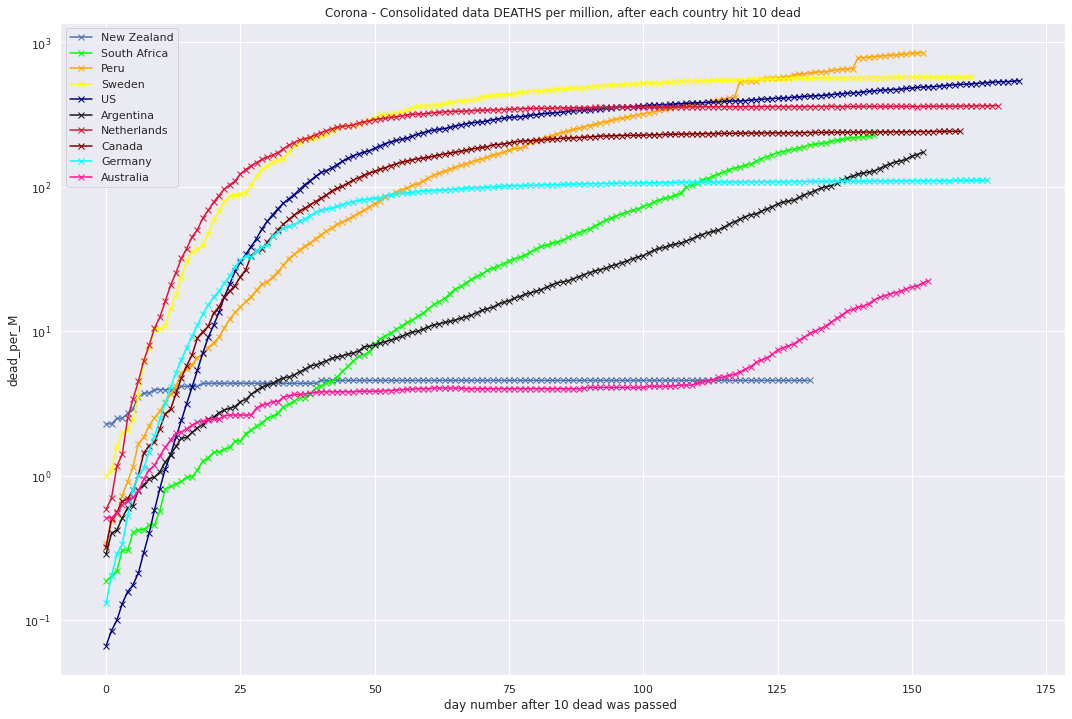

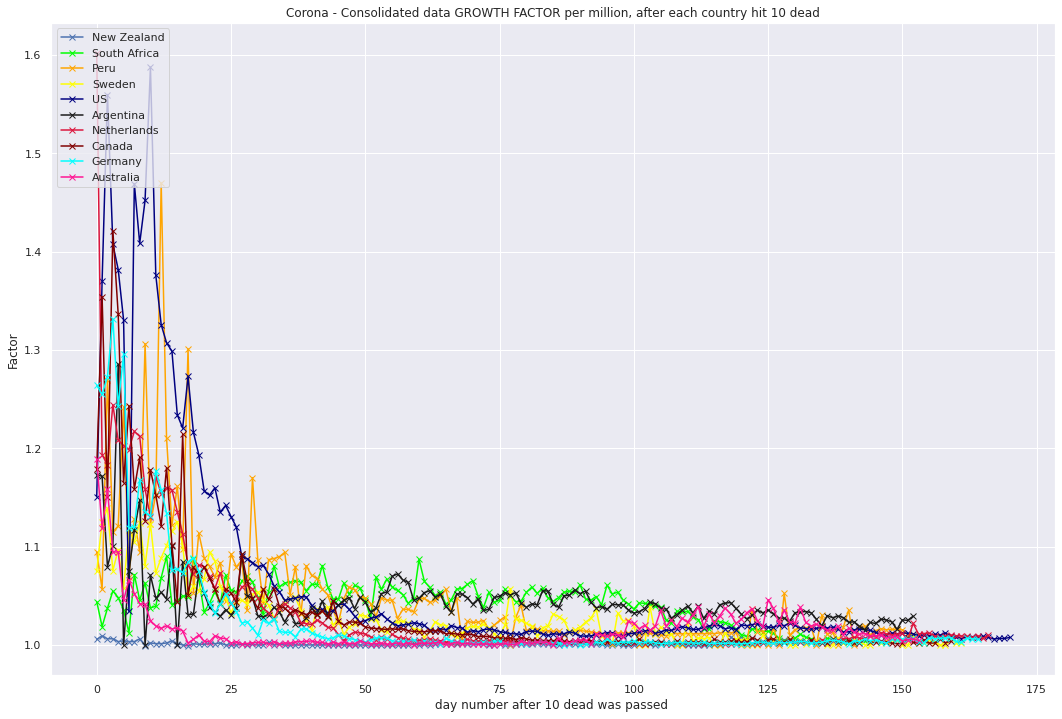

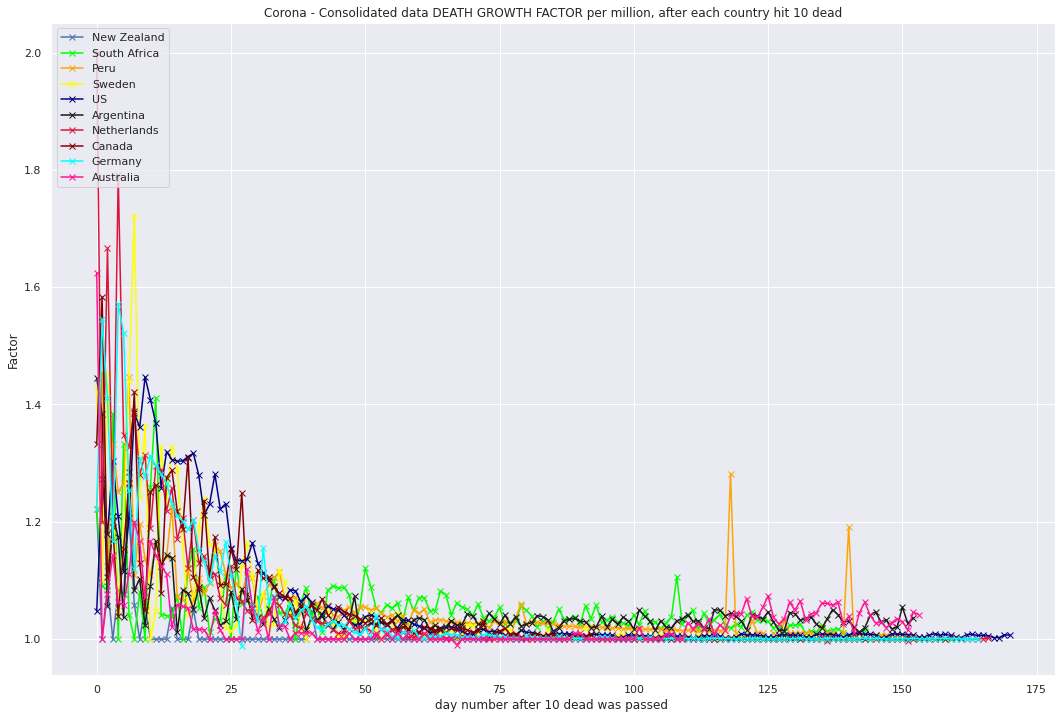

In [4]:

countries = ['New Zealand','South Africa','Peru','Sweden','US',
             'Argentina','Netherlands','Canada','Germany','Australia']

#countries = ['United Kingdom','Finland','Norway','Denmark','Sweden','Iceland']
#countries = ['Sweden']

colors = ['b','lime','orange','yellow','navy','k','crimson','maroon','cyan','deeppink']


plt.figure(figsize=(18,12))
plt.title('Corona - Consolidated data CONFIRMED per million, after each country hit {} dead'.format(dead_min))
plt.yscale('log')

#longest history
max_x = len(dick['Italy'])

def process_country(country,param,color_idx):
    df = dick[country]
    
    df.sort_index(inplace=True)
    
    df.head()
    
    try:
        df = df.drop(['dead_conf_ratio','conf_over_dead'],axis=1)
    except:
        print ('no cols dead_conf_ratio,conf_over_dead  for {} - skipping delete'.format(country))
   
    population = country_populations.loc[country,'population']
    df['conf_per_M'] = df['confirmed'] / (population / 1e6)
    df['dead_per_M'] = df['deceased'] / (population / 1e6)
    df['factor_per_M'] = df['conf_per_M'] / df['conf_per_M'].shift()
    df['factor_dead_per_M'] = df['dead_per_M'] / df['dead_per_M'].shift()
    
    mask = ( ( df['confirmed'] >= confirmed_min ) & ( df['deceased'] >= dead_min))
    df = df[mask]
    df.reset_index(inplace=True)
    
    #slope,intercept,_,_,_ = sps.linregress(df.index,df[param])
    #slope = np.log10(slope)
    #intercept = np.log10(intercept)
    
    #X = np.linspace(min(df.index) ,max(df.index),40)
    
    #plt.plot([X[i] * slope + intercept for i in range(len(X))],'--',color=colors[color_idx],
             #label=country +'_regression, slope:{:.2f} intercept:{:.2f}'.format(slope,intercept))
    
    plt.plot(df[param],'x-',label=country,color=colors[color_idx])
    
    plt.legend(loc='upper left')  
    
    if 'factor' in param:
        plt.ylabel('Factor')
    else:
        plt.ylabel('{}'.format(param))
        
    plt.xlabel('day number after {} dead was passed '.format(dead_min))
    plt.yscale('log')
    
    ### CHANGE LIMIT WHEN NEEDED ###
    #plt.xlim([0,max_x])
    
    
    
param = 'conf_per_M'

for i,c in enumerate(countries):
    process_country(c,param,i)

plt.savefig('Corona_consolidated_min_confirmed.jpg',format='jpg')

plt.figure(figsize=(18,12))
plt.title('Corona - Consolidated data DEATHS per million, after each country hit {} dead'.format(dead_min))

param = 'dead_per_M'

for i,c in enumerate(countries):
    process_country(c,param,i)
  
plt.savefig('Corona_consolidated_min_dead.jpg',format='jpg')

plt.figure(figsize=(18,12))
plt.title('Corona - Consolidated data GROWTH FACTOR per million, after each country hit {} dead'.format(dead_min))

param = 'factor_per_M'

for i,c in enumerate(countries):
    process_country(c,param,i)
    plt.yscale('linear')
    
plt.savefig('Corona_consolidated_min_factor.jpg',format='jpg')

plt.figure(figsize=(18,12))
plt.title('Corona - Consolidated data DEATH GROWTH FACTOR per million, after each country hit {} dead'.format(dead_min))

param = 'factor_dead_per_M'

for i,c in enumerate(countries):
    process_country(c,param,i)
    plt.yscale('linear')
    
    
plt.savefig('Corona_consolidated_dead_min_factor.jpg',format='jpg')


In [5]:
def smooth(x,window_len=10,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string   
    """
    
    '''
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"

    '''
    x = np.array(x,dtype=float) #conv from dataframe col to array
    s=np.r_[2*x[0]-x[window_len:1:-1],x,2*x[-1]-x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='same')
    return y[window_len-1:-window_len+1]


New Zealand
            confirmed    factor  inc  deceased  dead_factor  dead_inc  \
2020-08-22       1674  1.001795  3.0        22          1.0       0.0   
2020-08-23       1683  1.005376  9.0        22          1.0       0.0   
2020-08-24       1690  1.004159  7.0        22          1.0       0.0   
2020-08-25       1695  1.002959  5.0        22          1.0       0.0   
2020-08-26       1702  1.004130  7.0        22          1.0       0.0   

            pct_dead  conf_over_dead  dead_conf_ratio  
2020-08-22  1.314217       76.090909         0.998208  
2020-08-23  1.307190       76.500000         0.994652  
2020-08-24  1.301775       76.818182         0.995858  
2020-08-25  1.297935       77.045455         0.997050  
2020-08-26  1.292597       77.363636         0.995887  
South Africa
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-08-22     607045  1.006144  3707.0     12987     1.011212     144.0   
2020-08-23     609773  1.004494  2728.0     1305

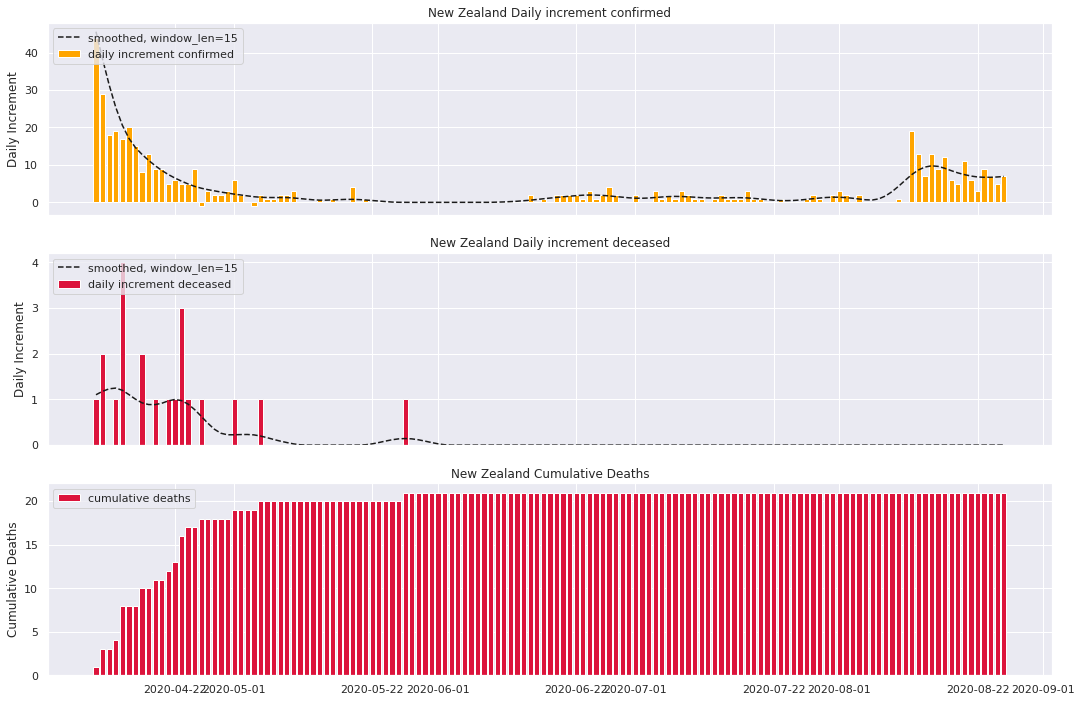

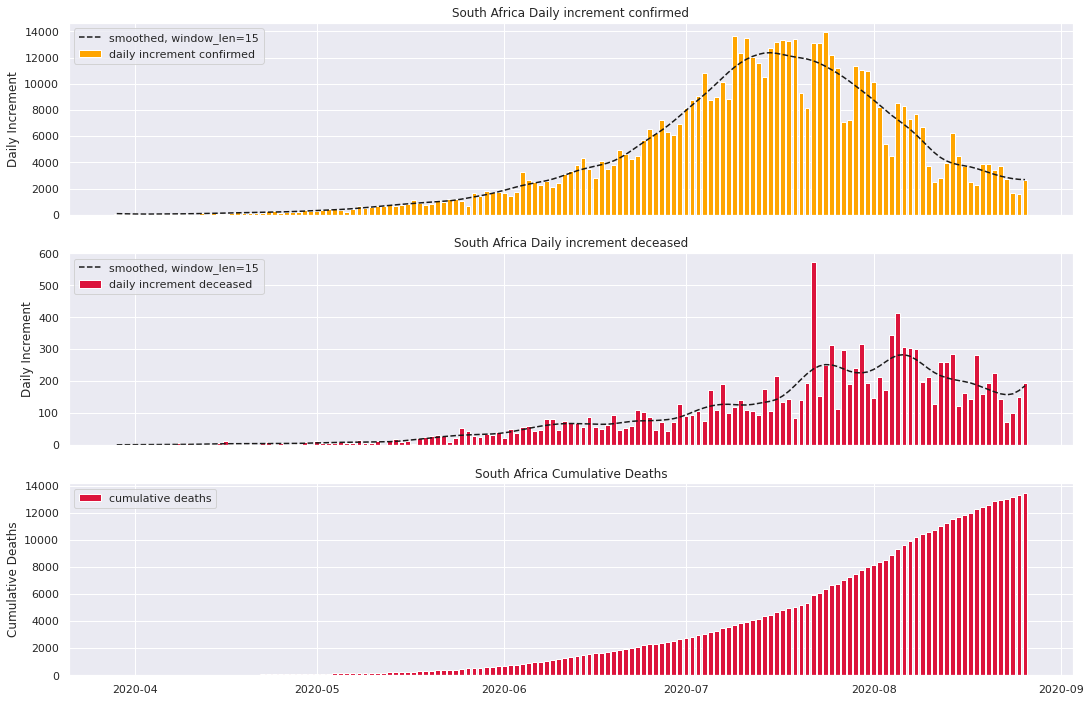

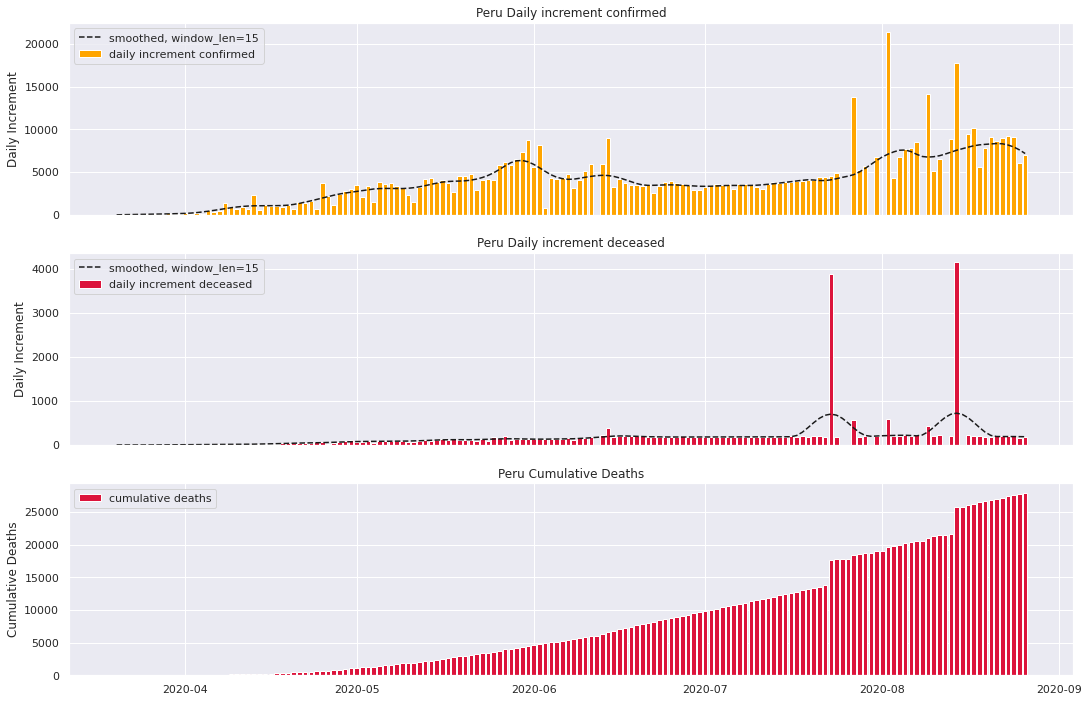

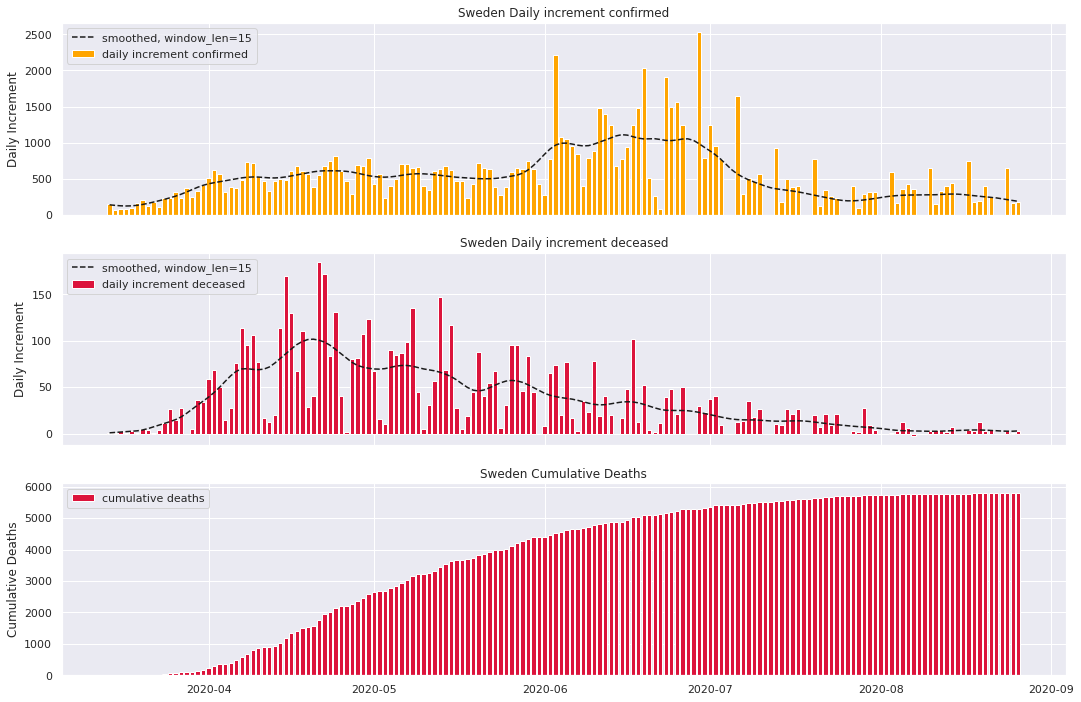

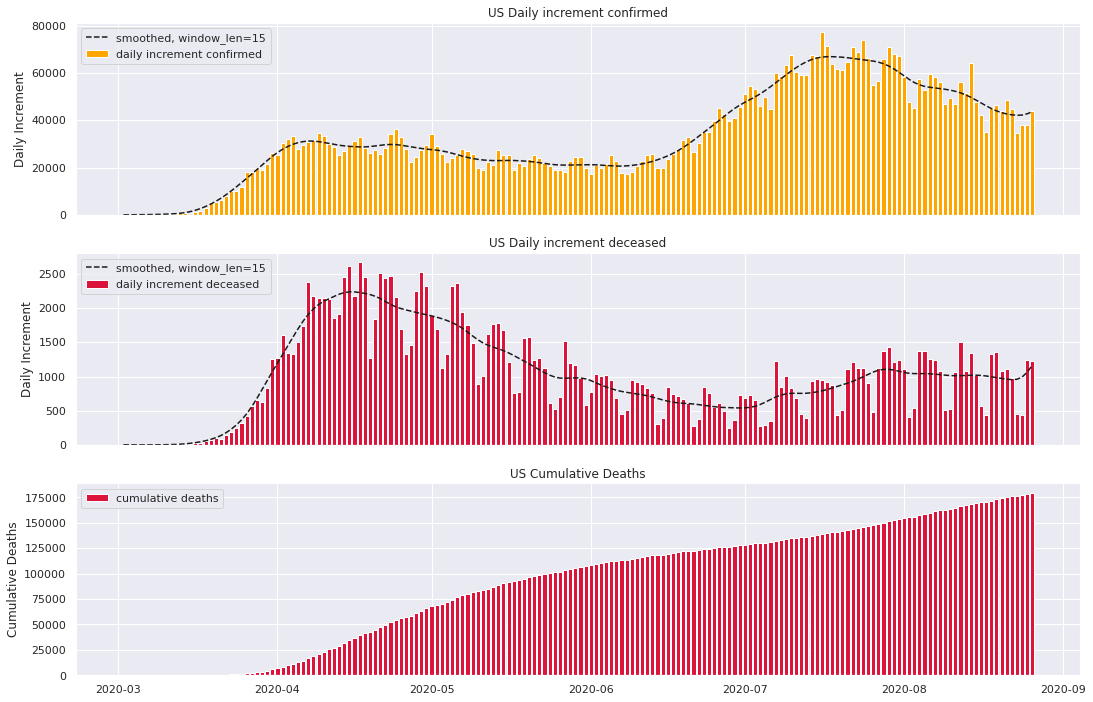

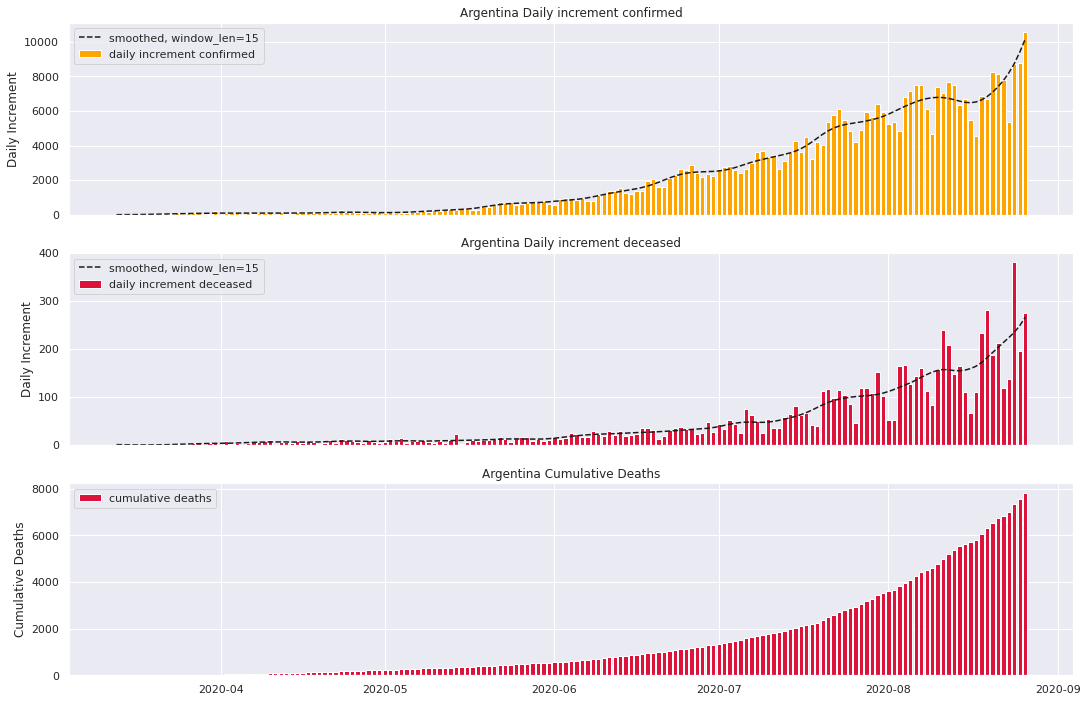

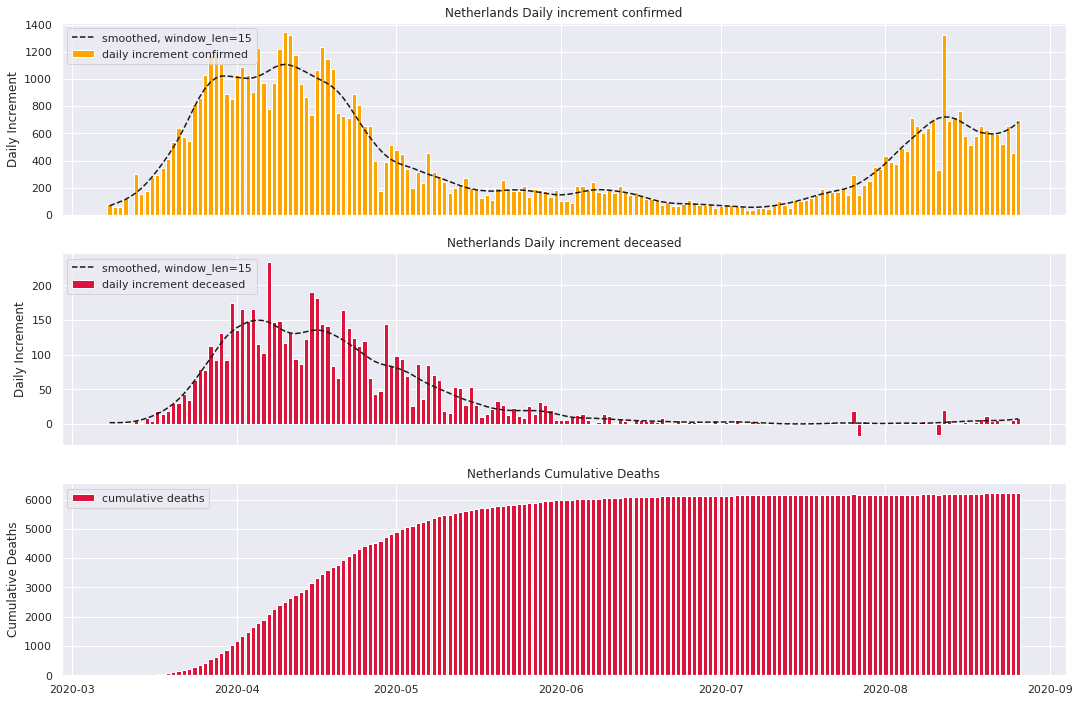

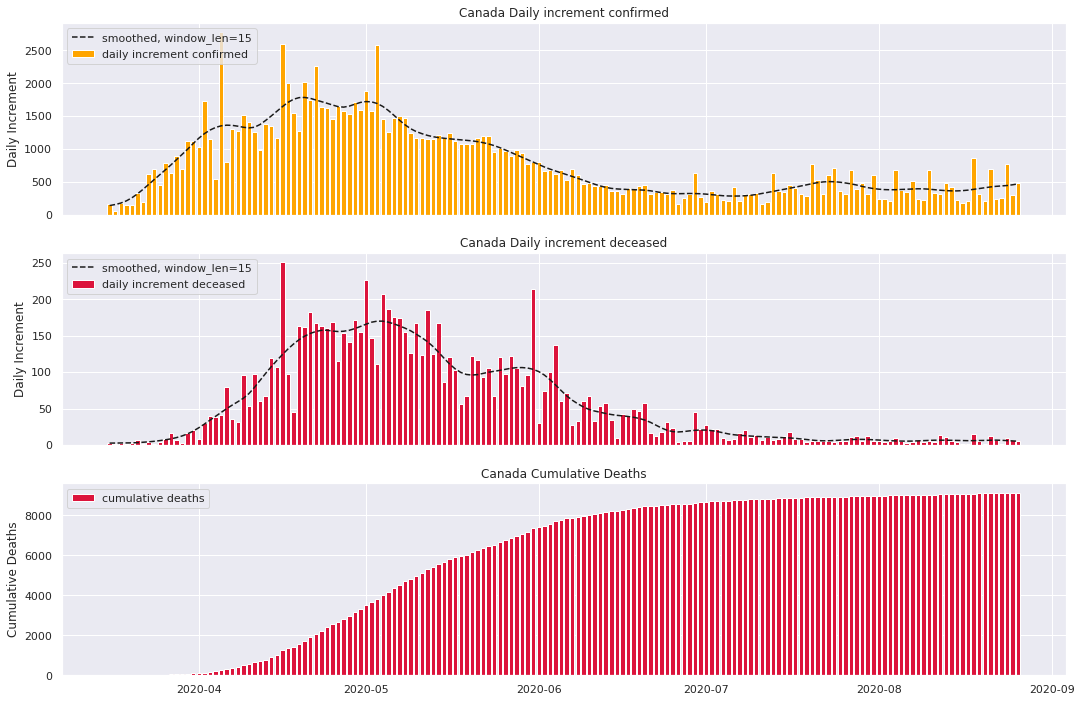

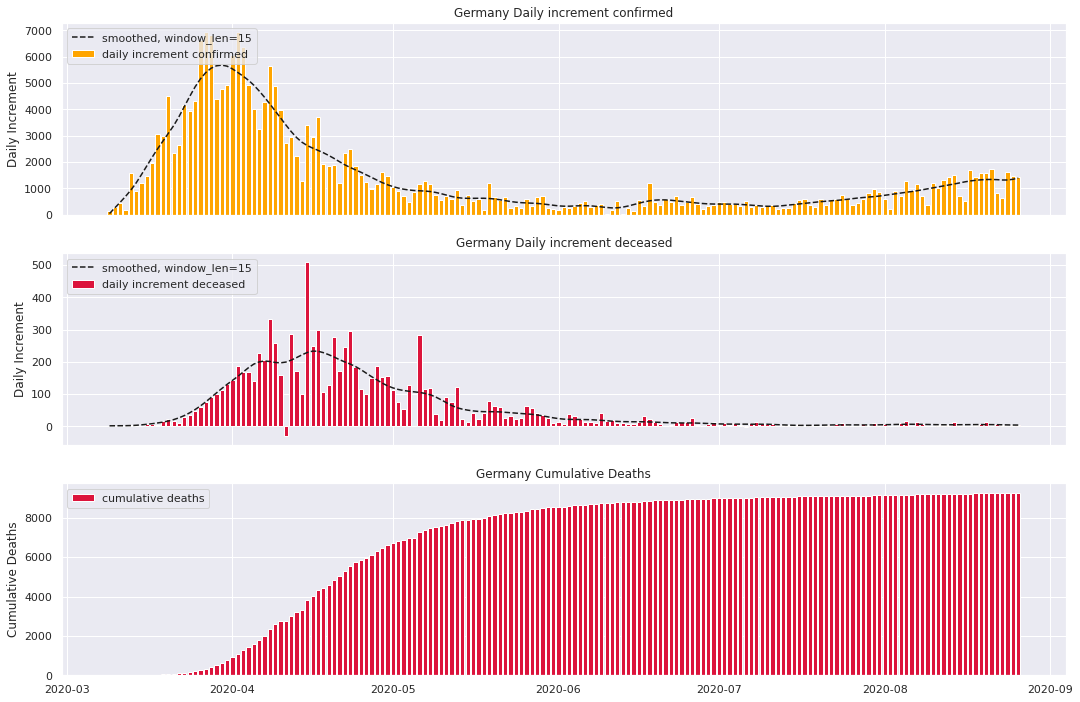

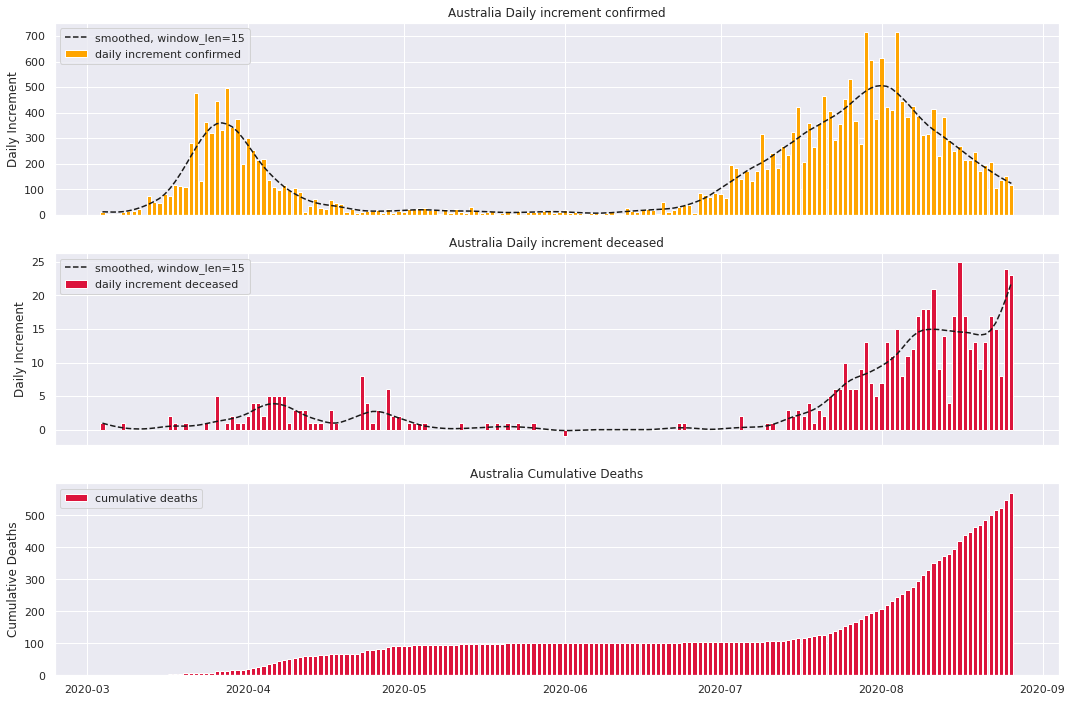

In [6]:


# countries = ['United Kingdom','Australia','Russia','Brazil']

for c in countries:
    print (c)
    window_len = 15
    fig,axes = plt.subplots(3,1,sharex=True,figsize=(18,12))
    df = dick[c]
    df = df[df['deceased'] > 1]
    df.index = df.index.date
    print (df.tail())
    axes[0].set_title('{} Daily increment confirmed'.format(c))
    axes[1].set_title('{} Daily increment deceased'.format(c))
    axes[0].plot(df.index,smooth(df['inc'],window_len=window_len),
                 color='k',ls='dashed',label='smoothed, window_len={}'.format(window_len))
    axes[1].plot(df.index,smooth(df['dead_inc'],window_len=window_len),color='k',
                 ls='dashed',label='smoothed, window_len={}'.format(window_len))
    axes[0].bar(df.index,df['inc'],color='orange',label='daily increment confirmed')
    axes[1].bar(df.index,df['dead_inc'],color='crimson',label='daily increment deceased')
    axes[0].legend(loc='upper left')
    axes[1].legend(loc='upper left')
    axes[0].set_ylabel('Daily Increment')
    axes[1].set_ylabel('Daily Increment')
    
    axes[2].set_title('{} Cumulative Deaths'.format(c))
    axes[2].bar(df.index,df['dead_inc'].cumsum(),color='crimson',label='cumulative deaths')
    axes[2].set_ylabel('Cumulative Deaths')
    axes[2].legend(loc='upper left')
    
    plt.savefig('daily_incs_{}.jpg'.format(c))

<ipython-input-7-8b4ac00736f2>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime.today().weekday()


++++++++++++++++ New Zealand
              inc  dead_inc
2020-04-01  257.0       1.0
2020-04-08  502.0       0.0
2020-04-15  176.0       8.0
2020-04-22   65.0       5.0
2020-04-29   25.0       5.0
2020-05-06   13.0       2.0
2020-05-13    8.0       0.0
2020-05-20    6.0       0.0
2020-05-27    1.0       1.0
2020-06-03    0.0       0.0
2020-06-10    0.0       0.0
2020-06-17    3.0       0.0
2020-06-24   12.0       0.0
2020-07-01   11.0       0.0
2020-07-08   10.0       0.0
2020-07-15    8.0       0.0
2020-07-22    7.0       0.0
2020-07-29    5.0       0.0
2020-08-05    9.0       0.0
2020-08-12   20.0       0.0
2020-08-19   65.0       0.0
2020-08-26   48.0       0.0
++++++++++++++++ South Africa
                inc  dead_inc
2020-04-01    453.0       5.0
2020-04-08    465.0      13.0
2020-04-15    661.0      16.0
2020-04-22   1129.0      31.0
2020-04-29   1715.0      38.0
2020-05-06   2458.0      50.0
2020-05-13   4266.0      66.0
2020-05-20   5929.0     120.0
2020-05-27   7934.0     213

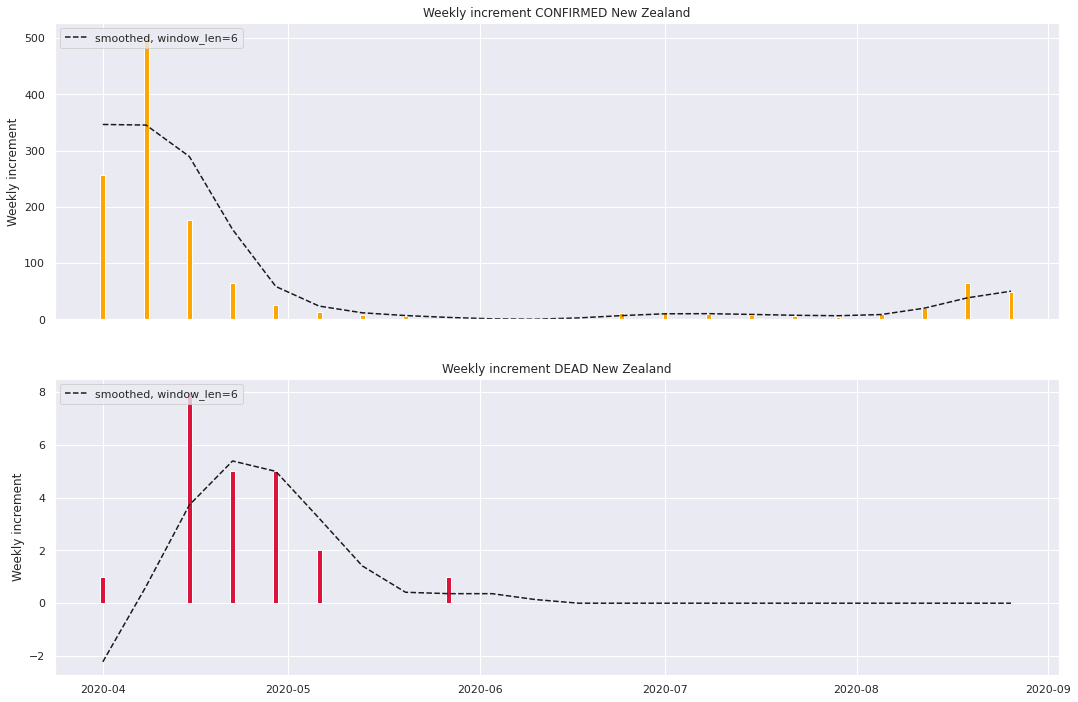

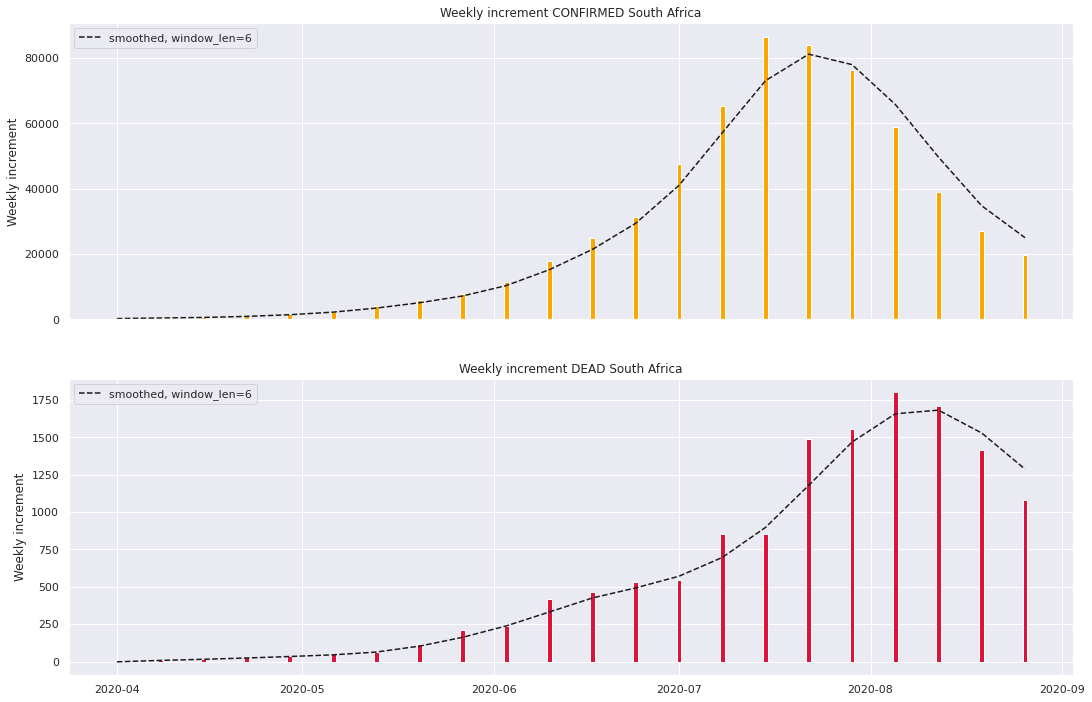

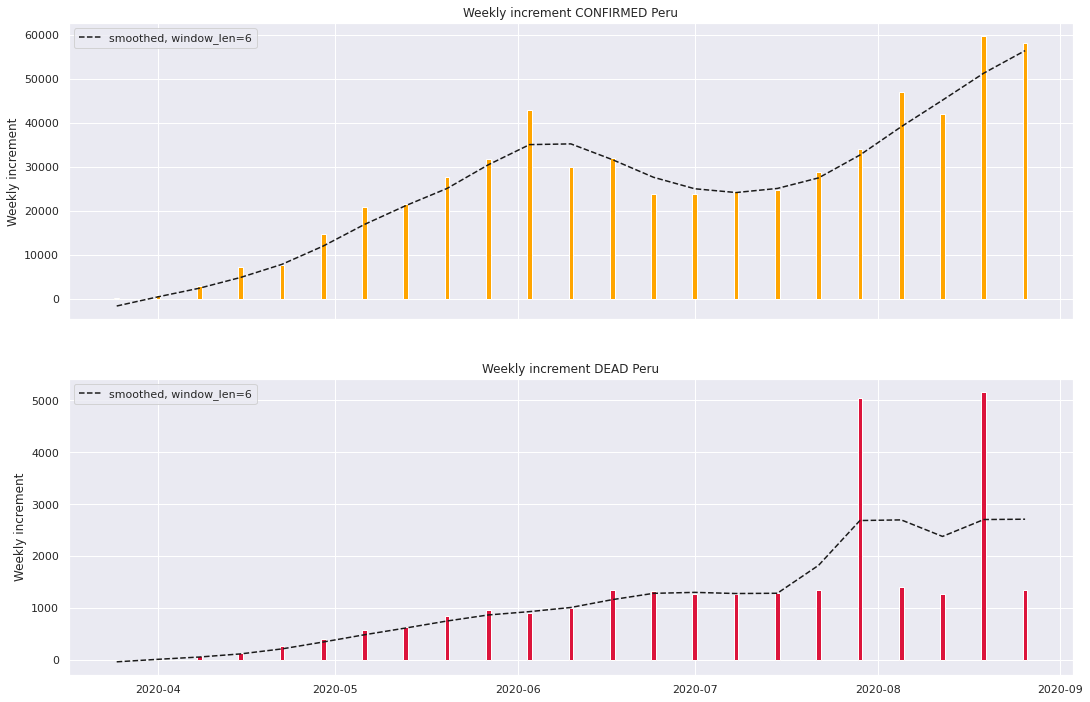

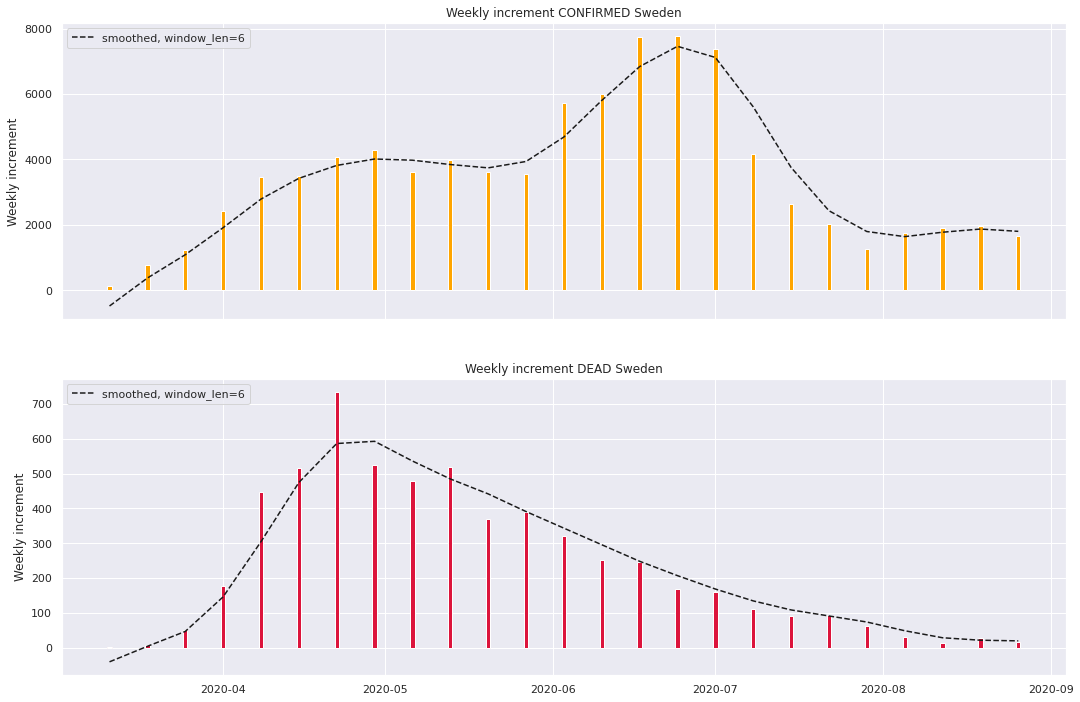

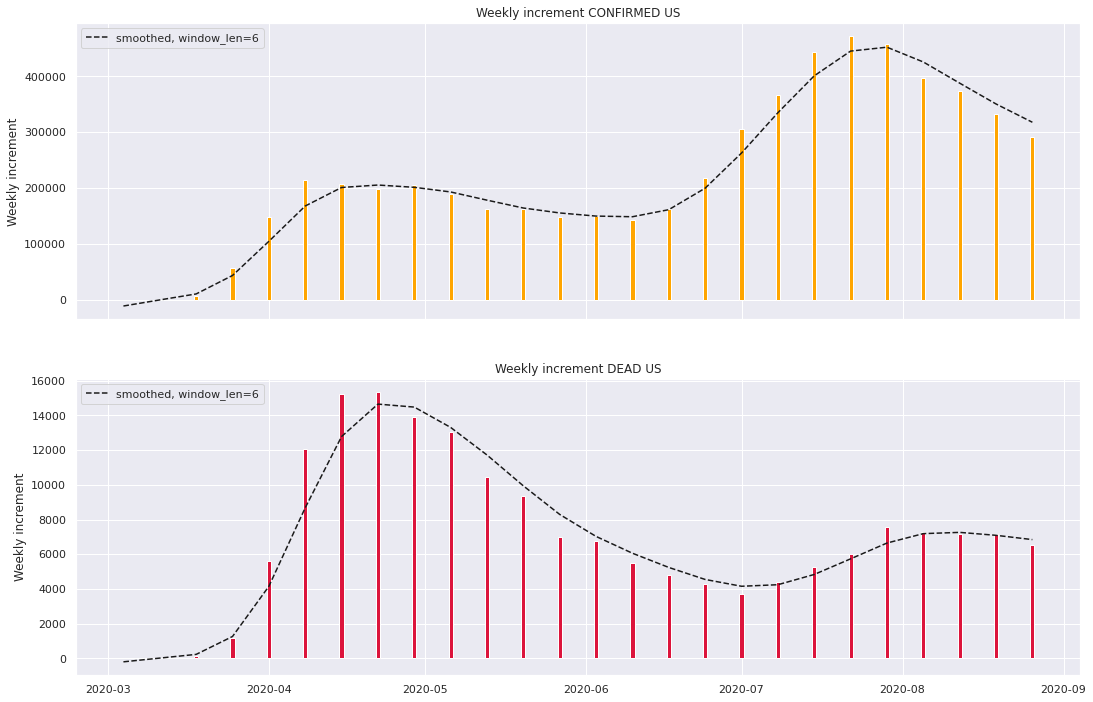

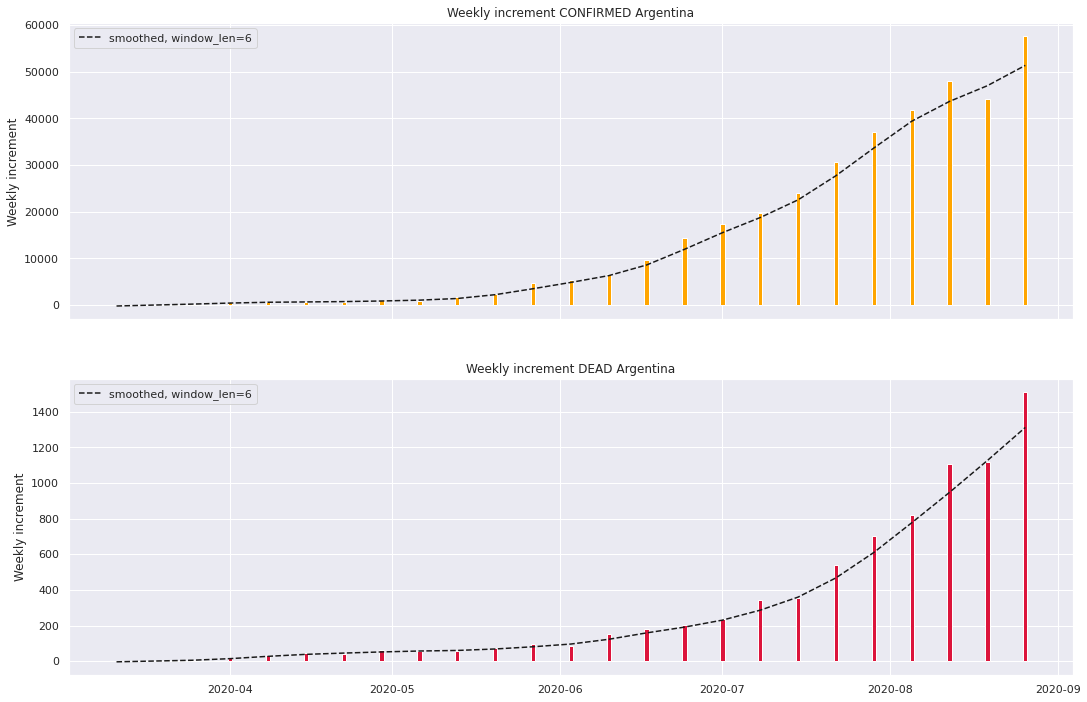

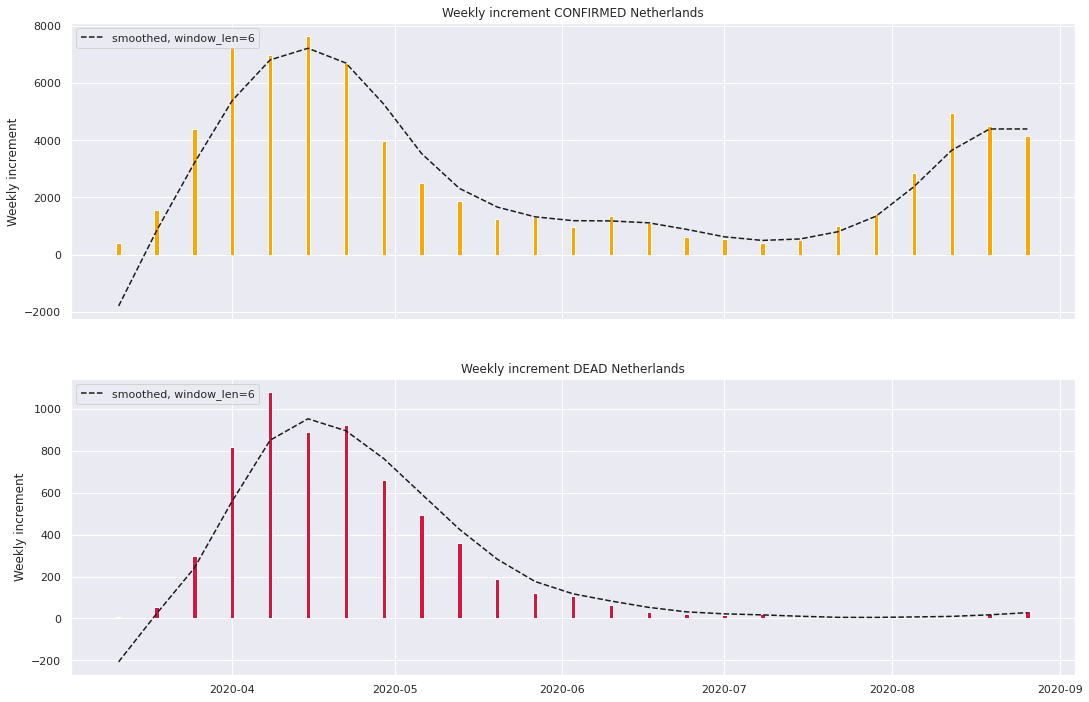

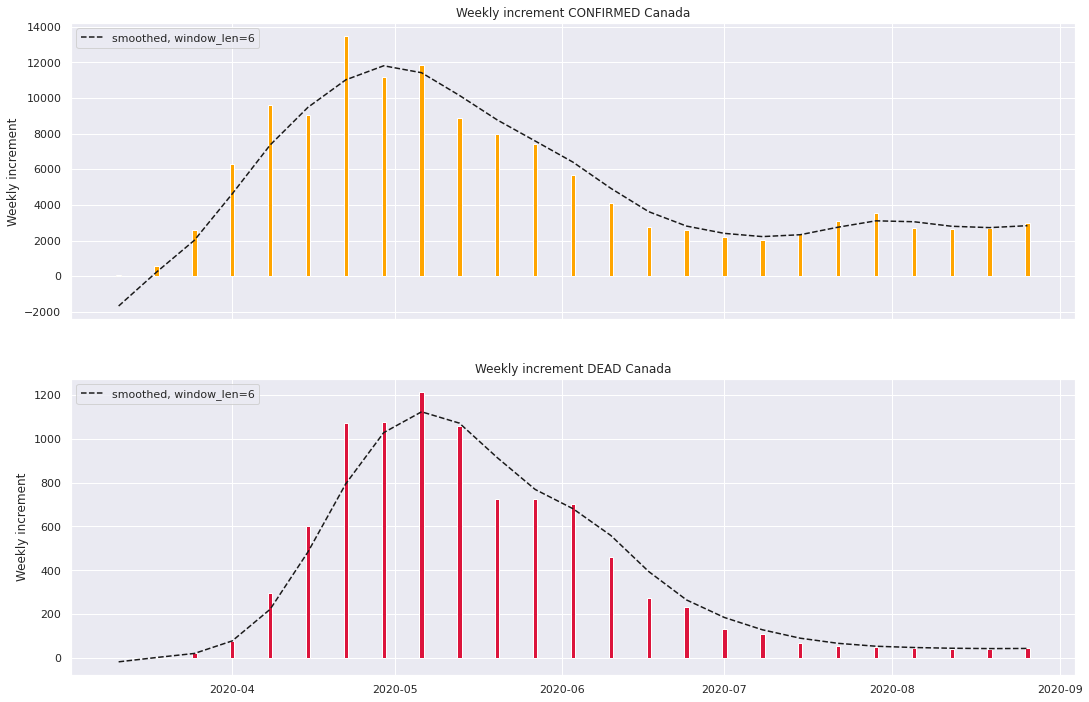

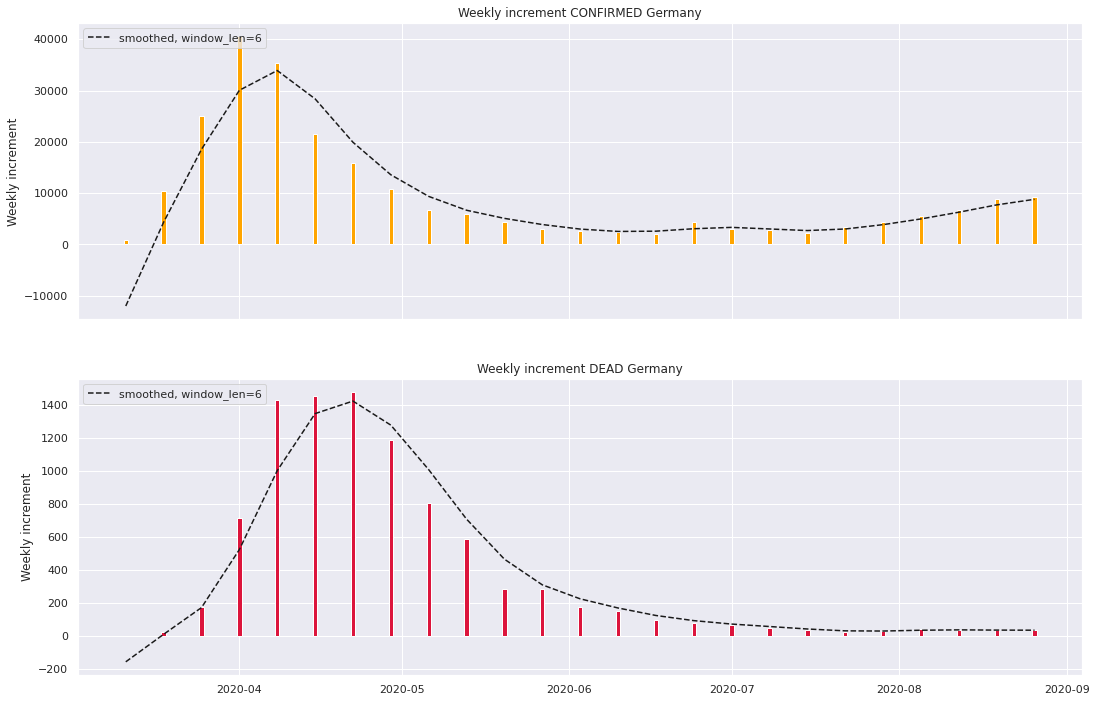

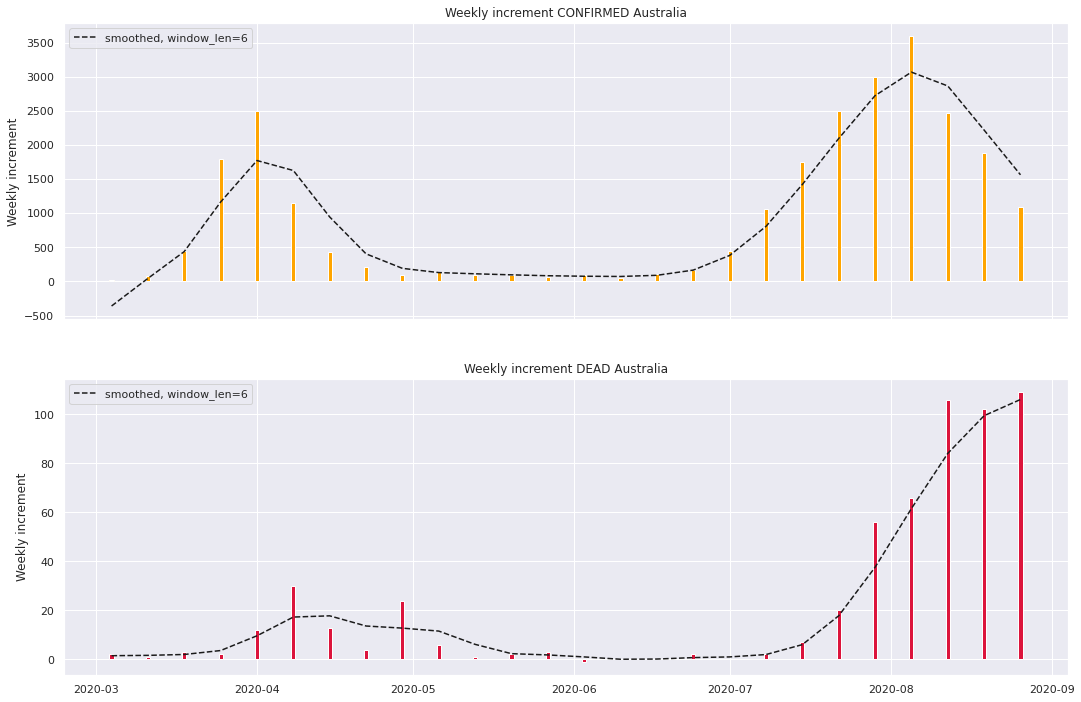

In [7]:
import pickle

resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
today = pd.datetime.today().weekday()

yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]

window_len = 6

week_dick=dict()

for c in countries:
    fig,axes=plt.subplots(2,1,figsize=(18,12),sharex=True)
    
    df = dick[c]
    df = df[df['deceased'] > 0]
    df_weekly = df.resample(yesterday(today)).agg({'inc' : np.sum,'dead_inc':np.sum})

    week_dick[c] = df_weekly
    
    print ('++++++++++++++++ {}'.format(c))
    print (df_weekly)
    axes[0].set_title('Weekly increment CONFIRMED {}'.format(c))
    axes[1].set_title('Weekly increment DEAD {}'.format(c))
    axes[0].set_ylabel('Weekly increment')
    axes[1].set_ylabel('Weekly increment')
    axes[0].bar(df_weekly.index,df_weekly['inc'],color='orange')
    axes[1].bar(df_weekly.index,df_weekly['dead_inc'],color='crimson')
    
    axes[0].plot(df_weekly.index,smooth(df_weekly['inc'],window_len=window_len),
                 color='k',ls='dashed',label='smoothed, window_len={}'.format(window_len))
    
    axes[1].plot(df_weekly.index,smooth(df_weekly['dead_inc'],window_len=window_len),
                 color='k',ls='dashed',label='smoothed, window_len={}'.format(window_len))

    axes[0].legend(loc='upper left')
    axes[1].legend(loc='upper left')
    
    plt.savefig('weekly_increments_{}.jpg'.format(c))

with open ('weekly_dick.pkl','wb') as f:
    pickle.dump(week_dick,f)

In [8]:
df_weekly


inc  dead_inc
2020-03-04    27.0       2.0
2020-03-11    76.0       1.0
2020-03-18   440.0       3.0
2020-03-25  1796.0       2.0
2020-04-01  2498.0      12.0
2020-04-08  1148.0      30.0
2020-04-15   430.0      13.0
2020-04-22   212.0       4.0
2020-04-29   100.0      24.0
2020-05-06   142.0       6.0
2020-05-13    95.0       1.0
2020-05-20    92.0       2.0
2020-05-27    69.0       3.0
2020-06-03    90.0      -1.0
2020-06-10    45.0       0.0
2020-06-17   106.0       0.0
2020-06-24   167.0       2.0
2020-07-01   443.0       0.0
2020-07-08  1055.0       2.0
2020-07-15  1754.0       7.0
2020-07-22  2492.0      20.0
2020-07-29  2996.0      56.0
2020-08-05  3592.0      66.0
2020-08-12  2468.0     106.0
2020-08-19  1878.0     102.0
2020-08-26  1086.0     109.0

cant find population for Bahamas, skippin..
cant find population for Burma, skippin..
cant find population for Congo (Brazzaville), skippin..
cant find population for Congo (Kinshasa), skippin..
cant find population for Cote d'Ivoire, skippin..
cant find population for Diamond Princess, skippin..
cant find population for Kosovo, skippin..
cant find population for MS Zaandam, skippin..
cant find population for Saint Kitts and Nevis, skippin..
cant find population for Saint Vincent and the Grenadines, skippin..
cant find population for Sao Tome and Principe, skippin..
cant find population for Taiwan*, skippin..
cant find population for West Bank and Gaza, skippin..


Text(450.6285714285715, 0.5, 'dead_M')

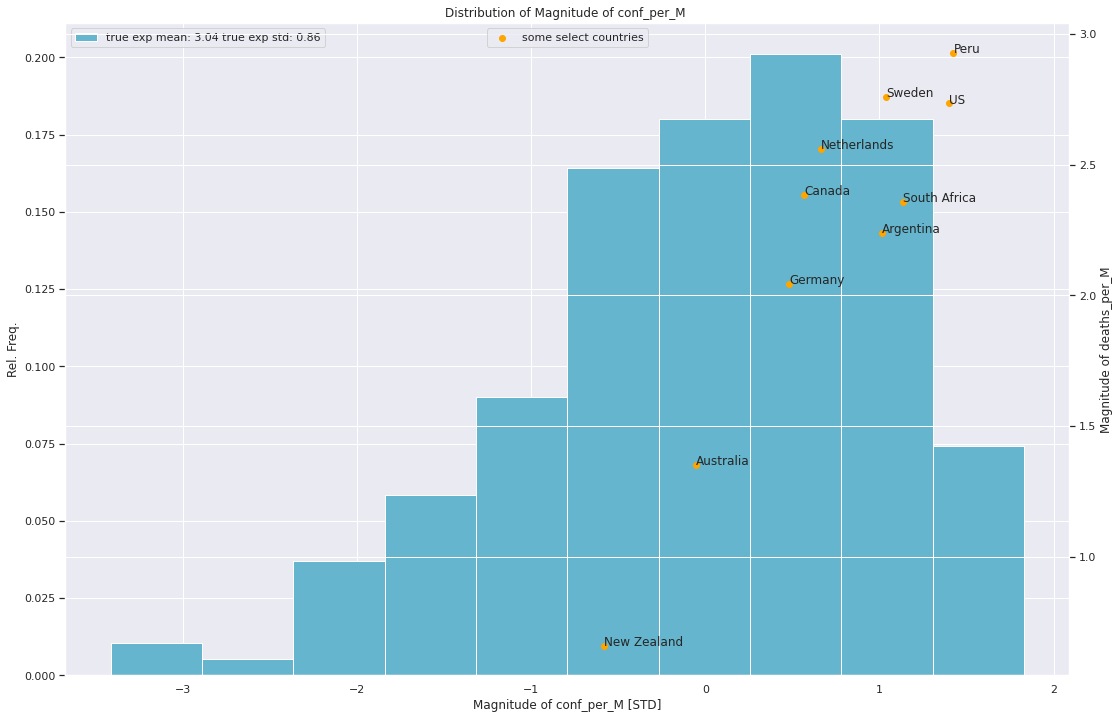

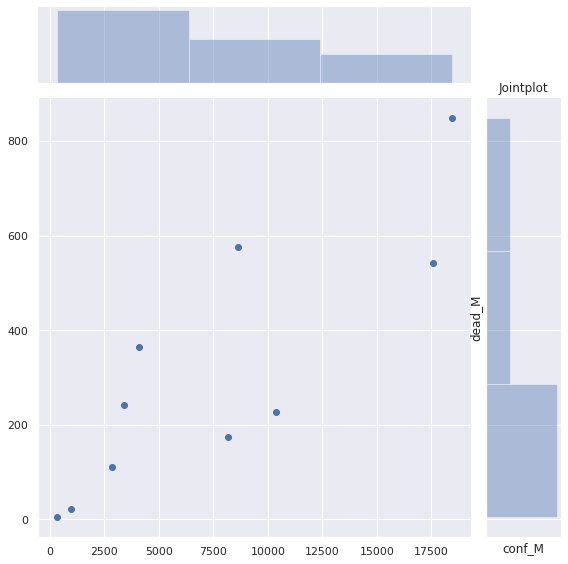

In [9]:
stats_df = pd.DataFrame()

param = 'conf_per_M'

for country,data in dick.items():
    try:
        population = country_populations.loc[country,'population']
    except:
        print ('cant find population for {}, skippin..'.format(country))
    data['conf_per_M'] = data['confirmed'] / (population / 1e6)
    data['dead_per_M'] = data['deceased'] / (population / 1e6)
    data['factor_per_M'] = data['conf_per_M'] / data['conf_per_M'].shift()
    data['factor_dead_per_M'] = data['dead_per_M'] / data['dead_per_M'].shift()
    data = pd.DataFrame(data[param])
    data = data.iloc[-1]
    
    stats_df = pd.concat([stats_df,data])


magnitude = np.log10(stats_df[0])

def std(x,mean,std):
    return (x -  mean) / std

magnitude_std = std(magnitude,magnitude.mean(),magnitude.std())

plt.figure(figsize=(18,12))

ax = plt.gca()
ax2 = plt.twinx()

ax.set_title('Distribution of Magnitude of {} '.format(param))
ax.set_ylabel('Rel. Freq.')
ax.set_xlabel('Magnitude of ' + param + ' [STD]')
ax.hist(magnitude_std,weights= np.ones_like(magnitude_std) / len(magnitude_std),color='c',
        label='true exp mean: {:.2f} true exp std: {:.2f}'.format(magnitude.mean(),magnitude.std()))
ax.legend(loc='upper left')  

'''
countries = ['Sweden','US','Germany','Spain','Italy','New York',
            'France','Austria','United Kingdom','Belgium','Finland',
            'Denmark','Norway','Australia','Korea, South',
            'New Zealand','Singapore','Norway','Ethiopia','Japan']
'''
countries = ['New Zealand','South Africa','Peru','Sweden','US',
             'Argentina','Netherlands','Canada','Germany','Australia']


for i,c in enumerate(countries):
    label = 'some select countries' if i == 0 else ''
    
    ax2.scatter(std(np.log10(dick[c].loc[:,'conf_per_M'][-1]),
        magnitude.mean(),magnitude.std()),
                np.log10(dick[c].loc[:,'dead_per_M'][-1]),
                    color='orange',label=label)
    
    ax2.text(std(np.log10(dick[c].loc[:,'conf_per_M'][-1]),
              magnitude.mean(),magnitude.std()),
                 np.log10(dick[c].loc[:,'dead_per_M'][-1]),c)
             
ax2.set_ylabel('Magnitude of deaths_per_M')
ax2.legend(loc='upper center')

conf_m = []
dead_m = []

for i,c in enumerate(countries):
    conf_m.append(dick[c]['conf_per_M'][-1])
    dead_m.append(dick[c]['dead_per_M'][-1])

#plt.title('Joint plot conf_m dead_m')
sns.jointplot(conf_m,dead_m,height=8)
plt.title('Jointplot')
plt.xlabel('conf_M')
plt.ylabel('dead_M')


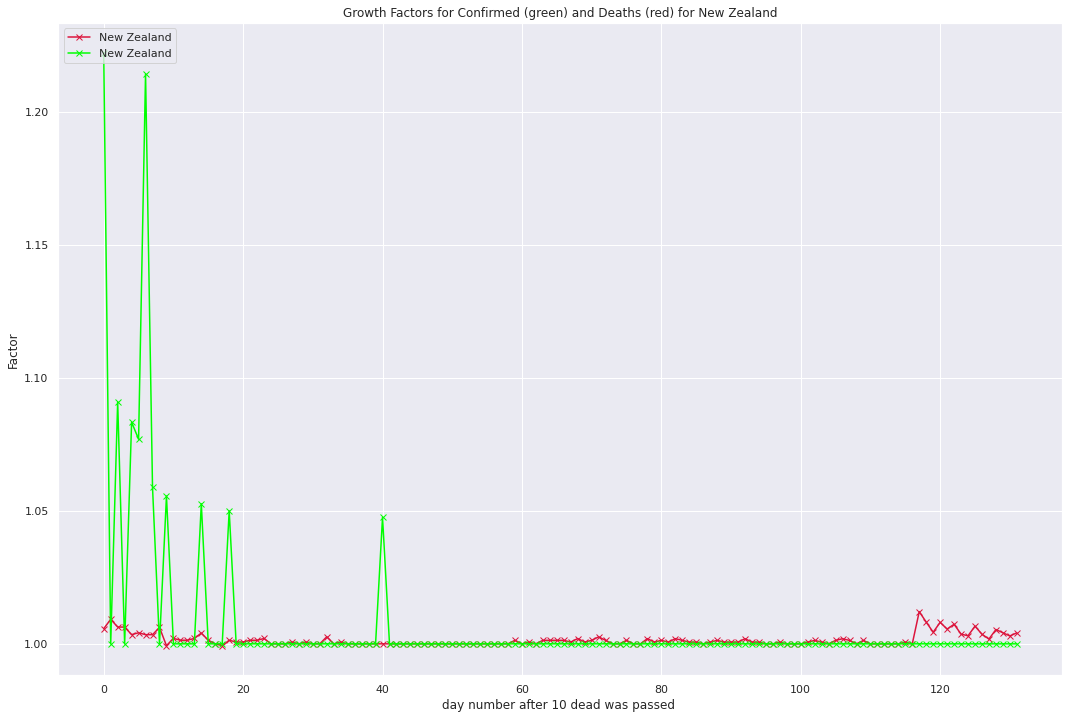

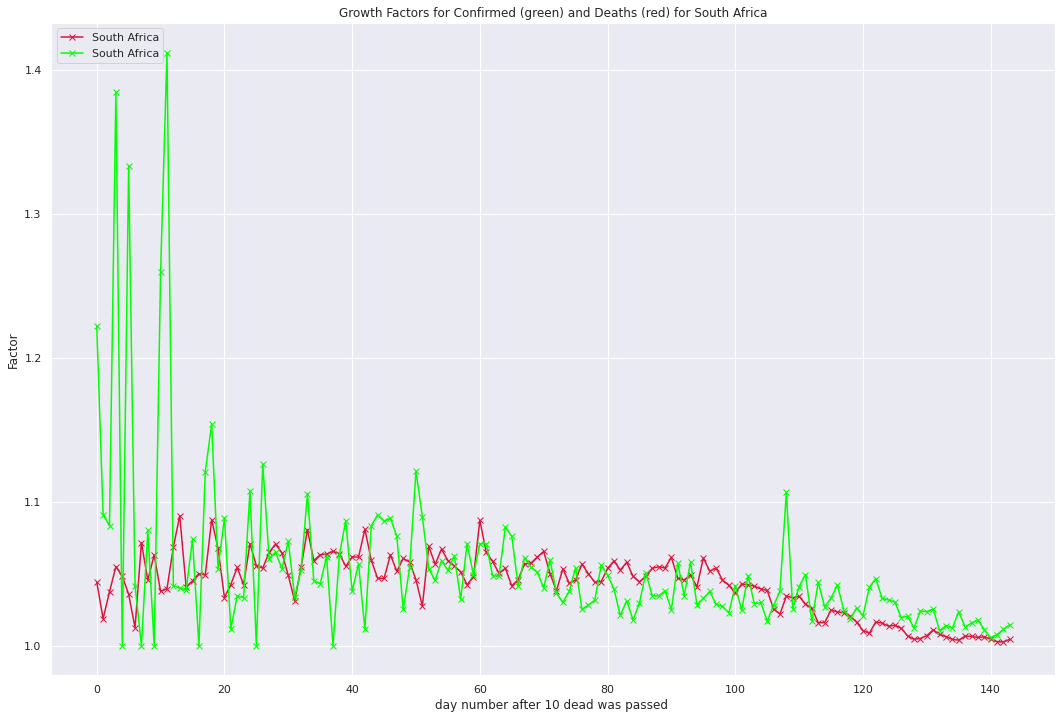

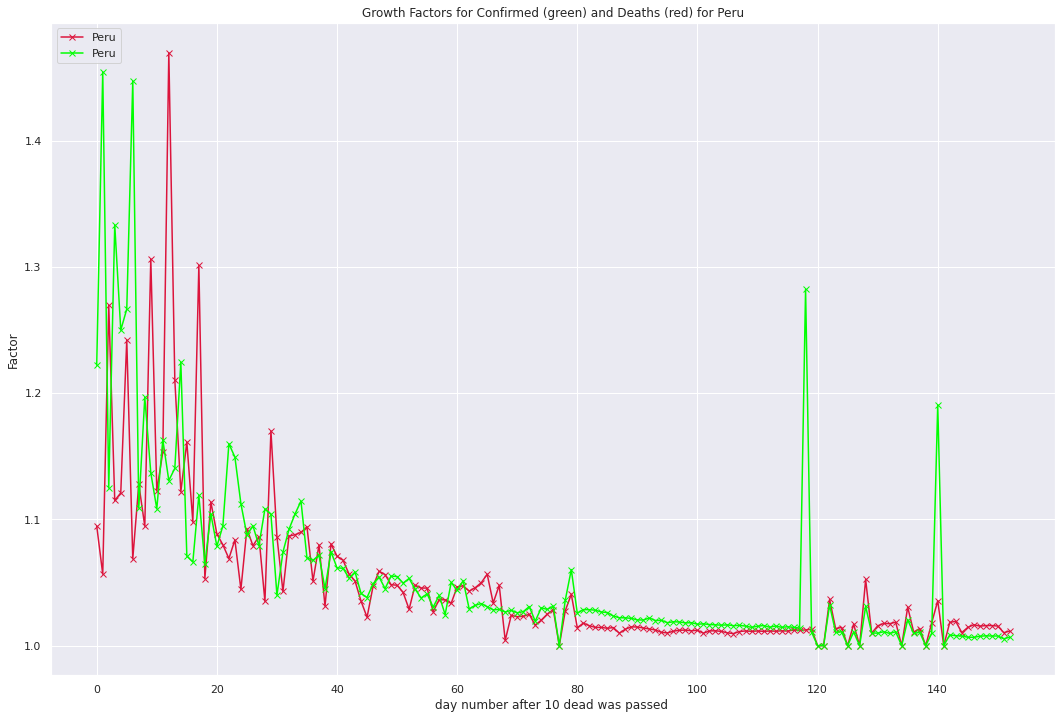

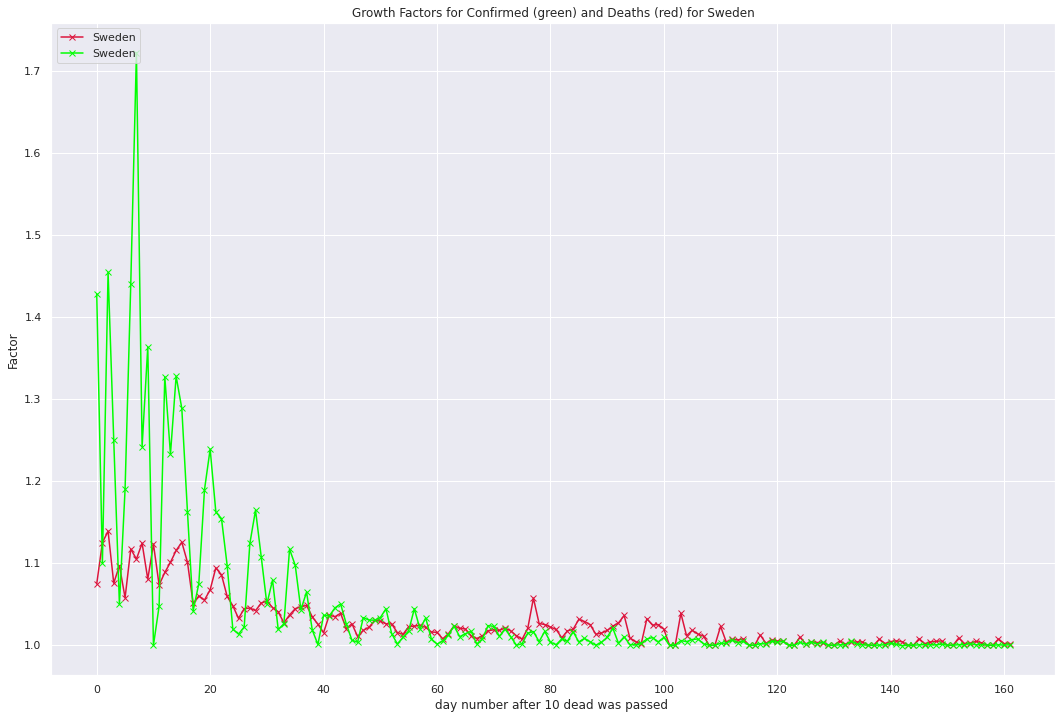

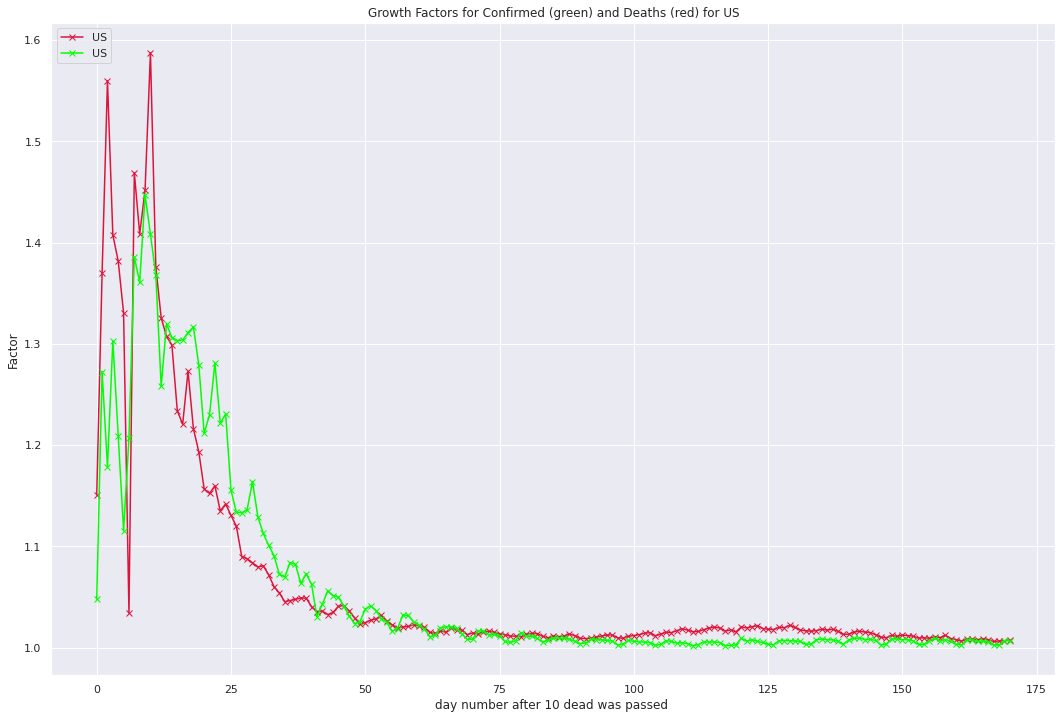

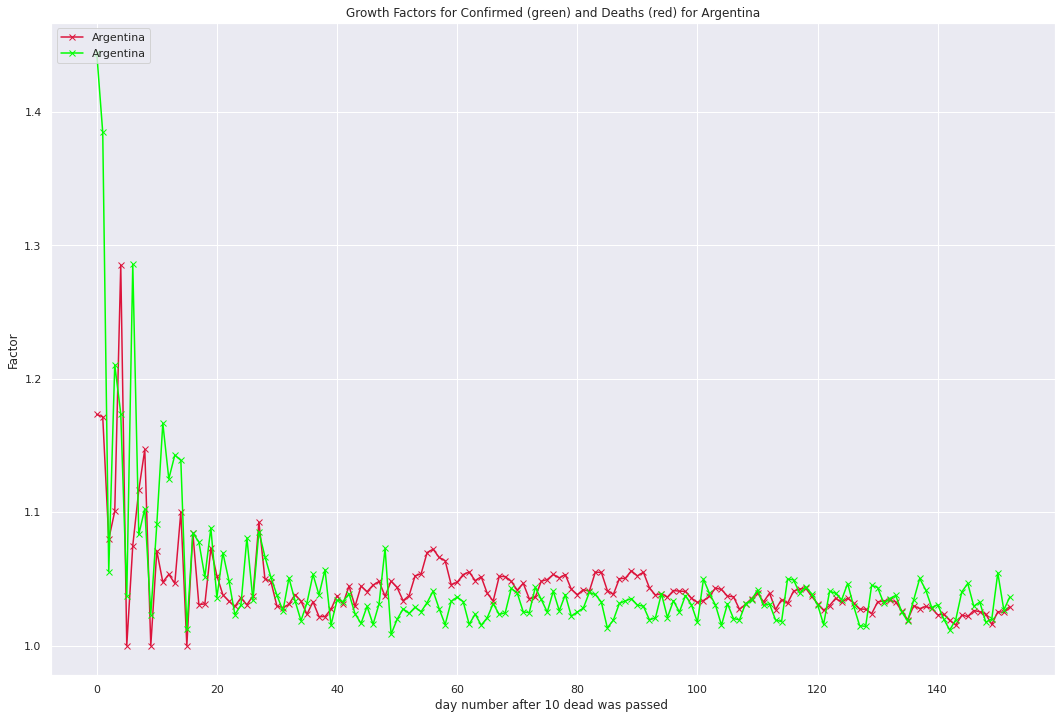

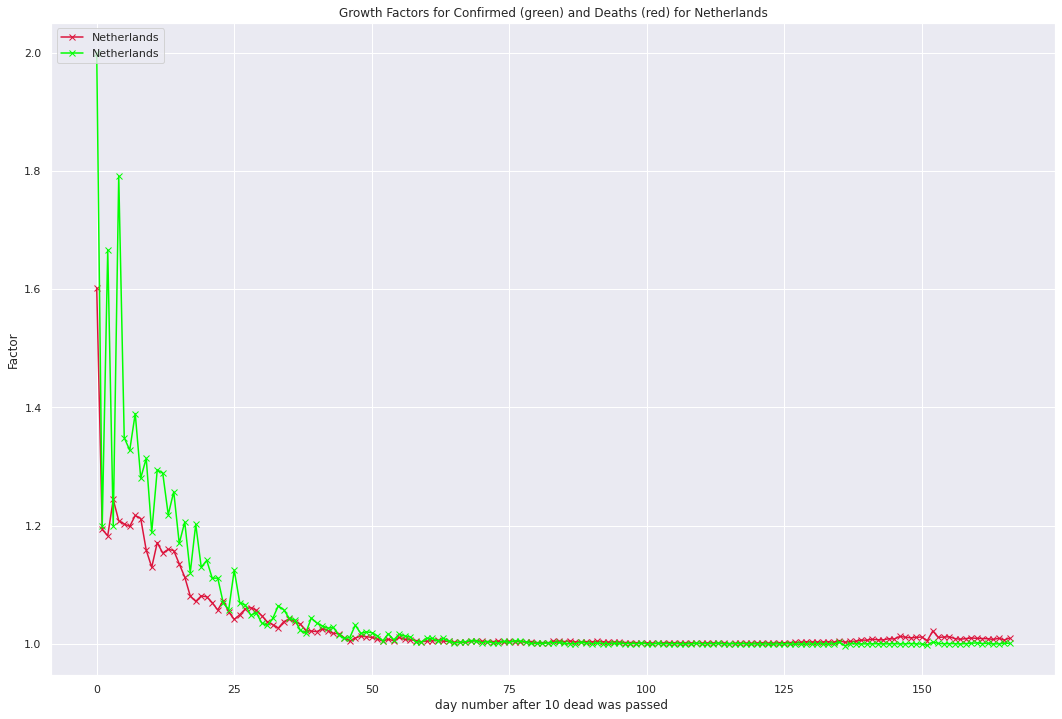

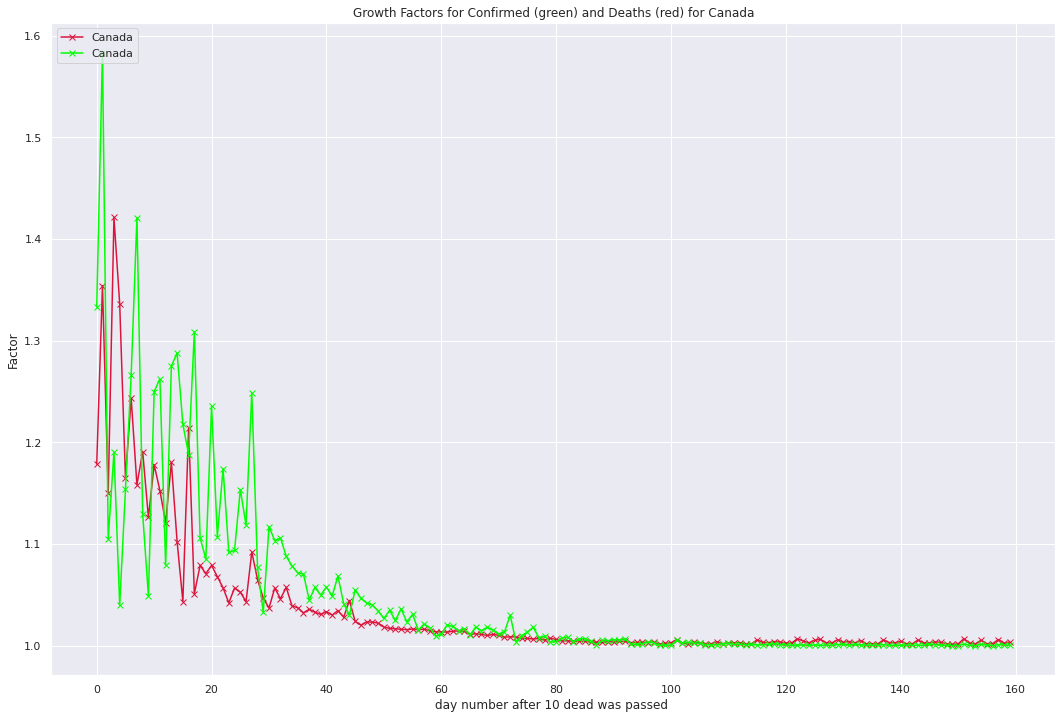

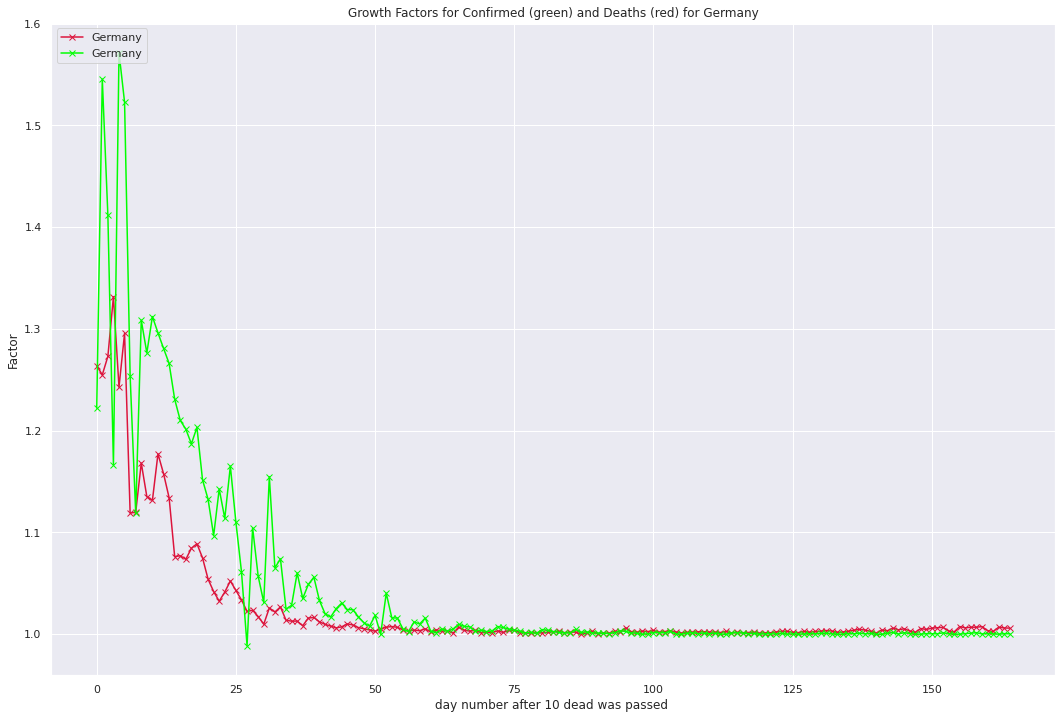

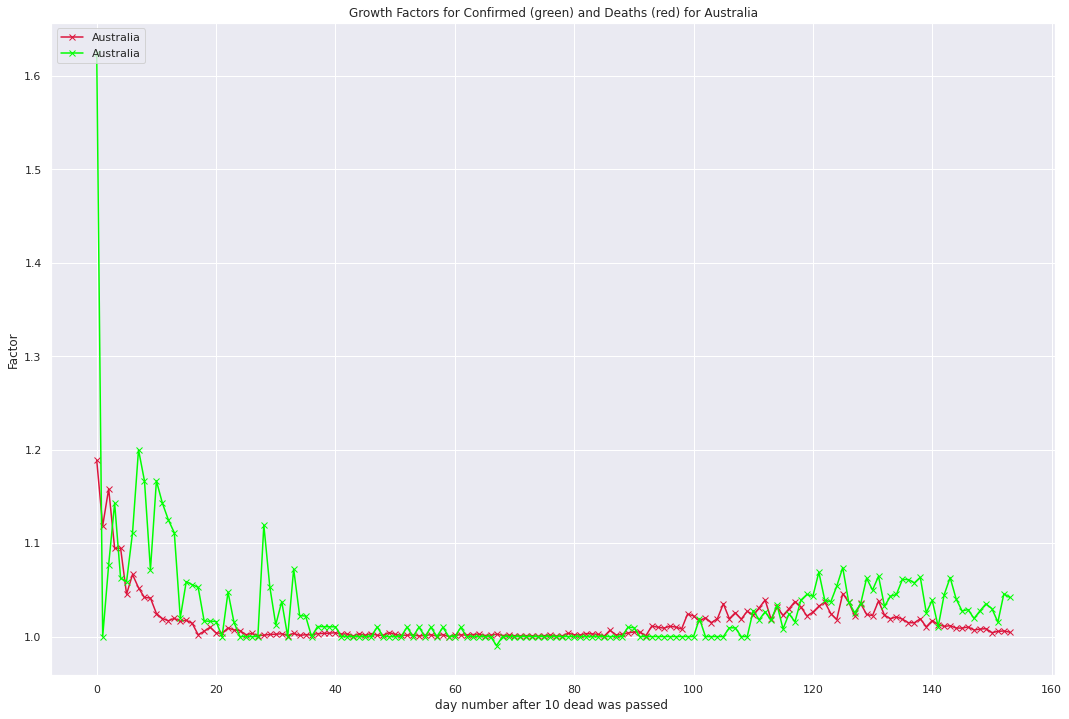

In [10]:
for i,c in enumerate(countries):
    plt.figure(figsize=(18,12))
    plt.title('Growth Factors for Confirmed (green) and Deaths (red) for {}'.format(c))
    
    process_country(c,'factor_per_M',6)
    process_country(c,'factor_dead_per_M',1)
    plt.yscale('linear')
    plt.savefig('Growth_factors_for_{}.jpg'.format(c),format='jpg')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 4 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.243305    -0.001733
std       0.082463     0.082606
min      -0.054582    -0.205319
25%       0.189899    -0.062725
50%       0.240081     0.000945
75%       0.293755     0.060892
max       0.540997     0.219440


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6592388872751346, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.189521    -0.003977
std       0.070746     0.084414
min      -0.066253    -0.229899
25%       0.142572    -0.065310
50%       0.191393    -0.010738
75%       0.234473     0.049554
max       0.433049     0.212696


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.494950     0.006002
std       0.070597     0.073594
min       0.262557    -0.204046
25%       0.446346    -0.039803
50%       0.495096     0.001311
75%       0.542464     0.048301
max       0.754018     0.203062


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.758633     0.002605
std       0.051005     0.052087
min       0.598983    -0.168808
25%       0.720455    -0.033201
50%       0.757765     0.001106
75%       0.793252     0.036870
max       0.915072     0.152535


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.890058     0.000021
std       0.034809     0.035281
min       0.783848    -0.119705
25%       0.866391    -0.022945
50%       0.889562     0.000684
75%       0.911546     0.023215
max       1.016737     0.114804


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.658262     0.001421
std       0.059767     0.062919
min       0.466696    -0.179471
25%       0.619580    -0.043166
50%       0.656887     0.002601
75%       0.699299     0.041967
max       0.870803     0.166889


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.919175    -0.001730
std       0.032185     0.031029
min       0.815880    -0.095326
25%       0.897219    -0.025611
50%       0.919784    -0.001481
75%       0.940352     0.021085
max       1.021288     0.094438


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.749296    -0.005685
std       0.049127     0.053481
min       0.592155    -0.240513
25%       0.717986    -0.041902
50%       0.748579    -0.007696
75%       0.779585     0.031451
max       0.912048     0.189526


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.896309    -0.000765
std       0.035648     0.033349
min       0.769740    -0.093896
25%       0.872825    -0.024217
50%       0.896356    -0.002640
75%       0.919450     0.022245
max       1.007257     0.097264


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.694745536666667, but should be close to 0.8. Try to increase the number of tuning steps.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6823744319428326, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.669163    -0.009732
std       0.059954     0.059136
min       0.482280    -0.180294
25%       0.630928    -0.058805
50%       0.672506    -0.011543
75%       0.713417     0.034441
max       0.847280     0.200930


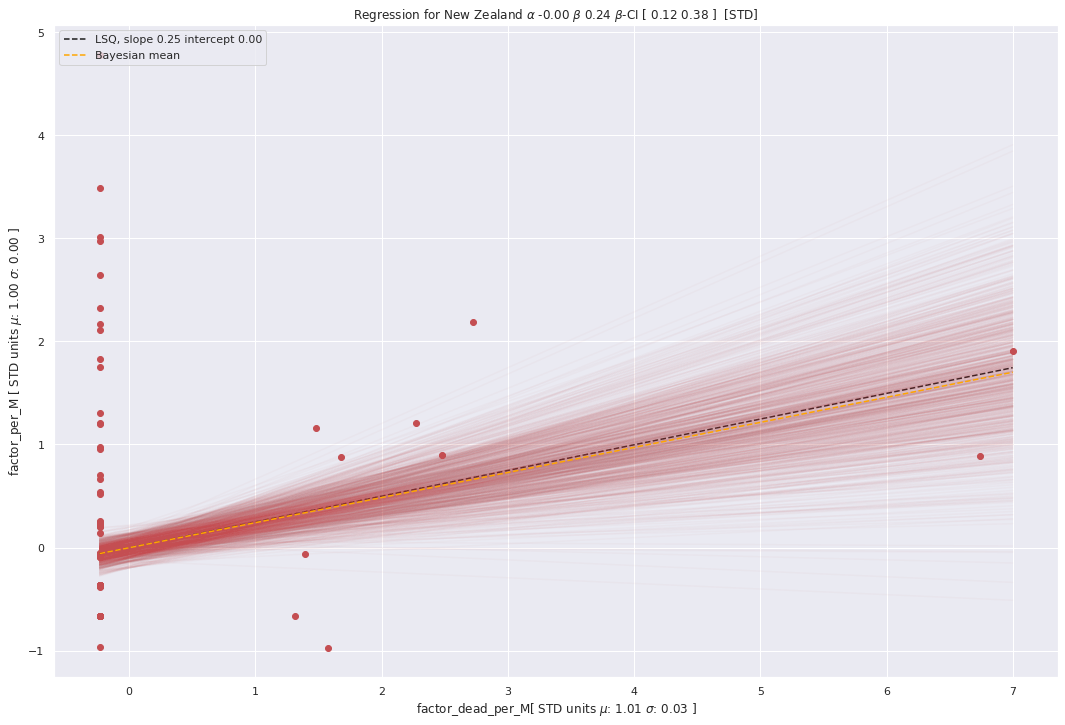

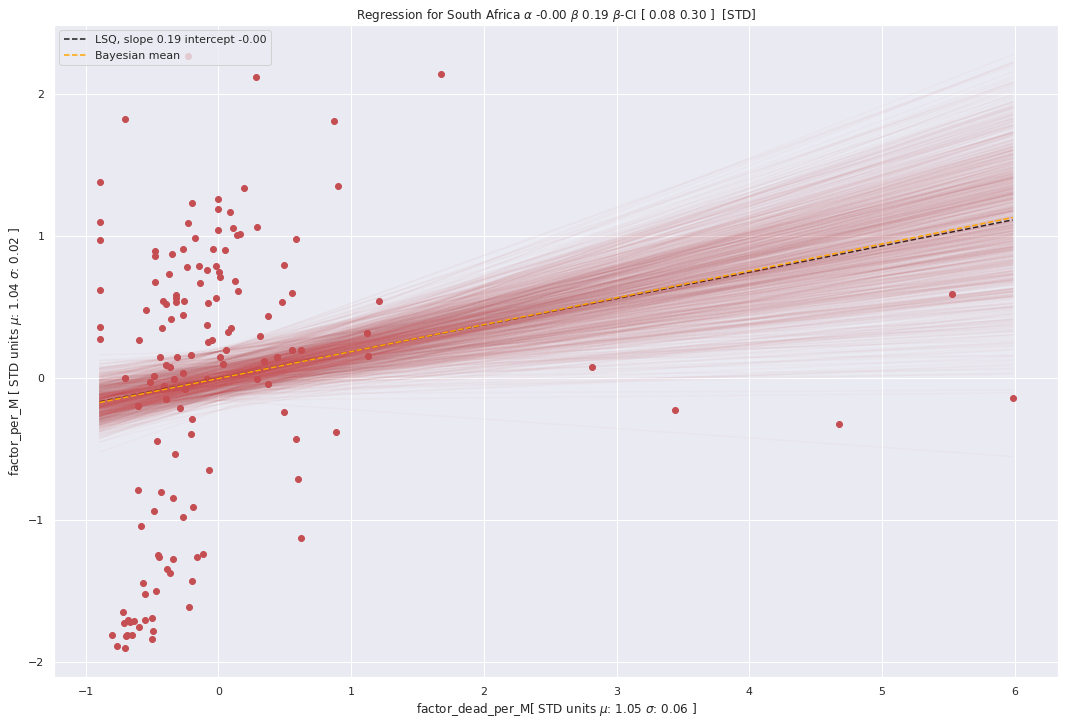

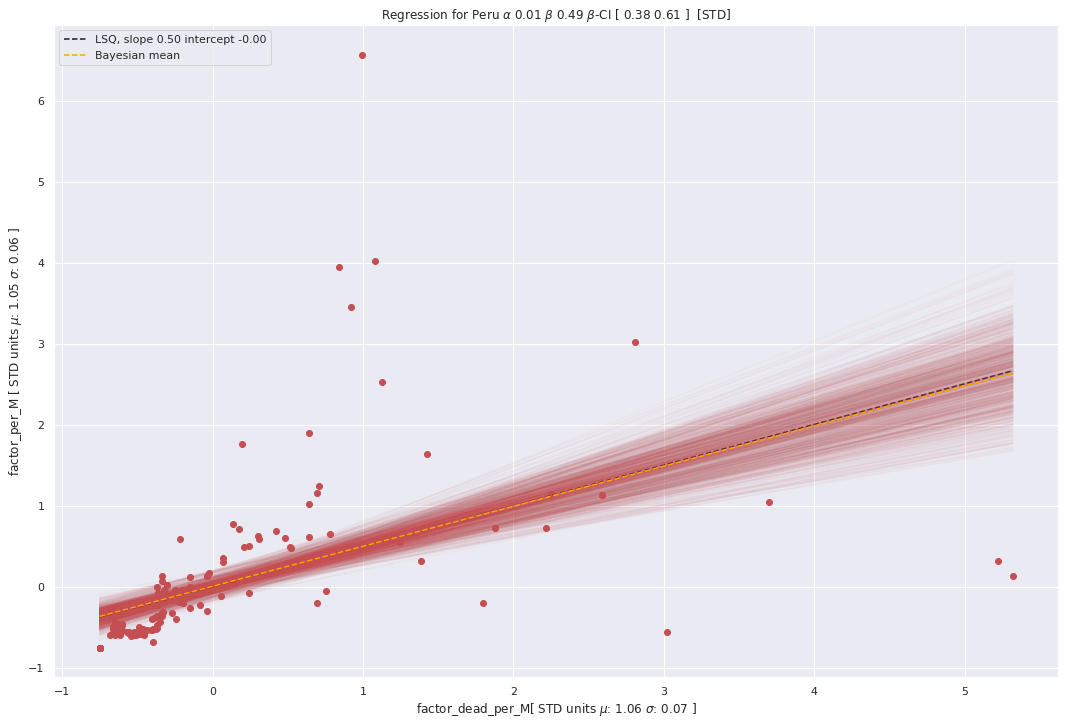

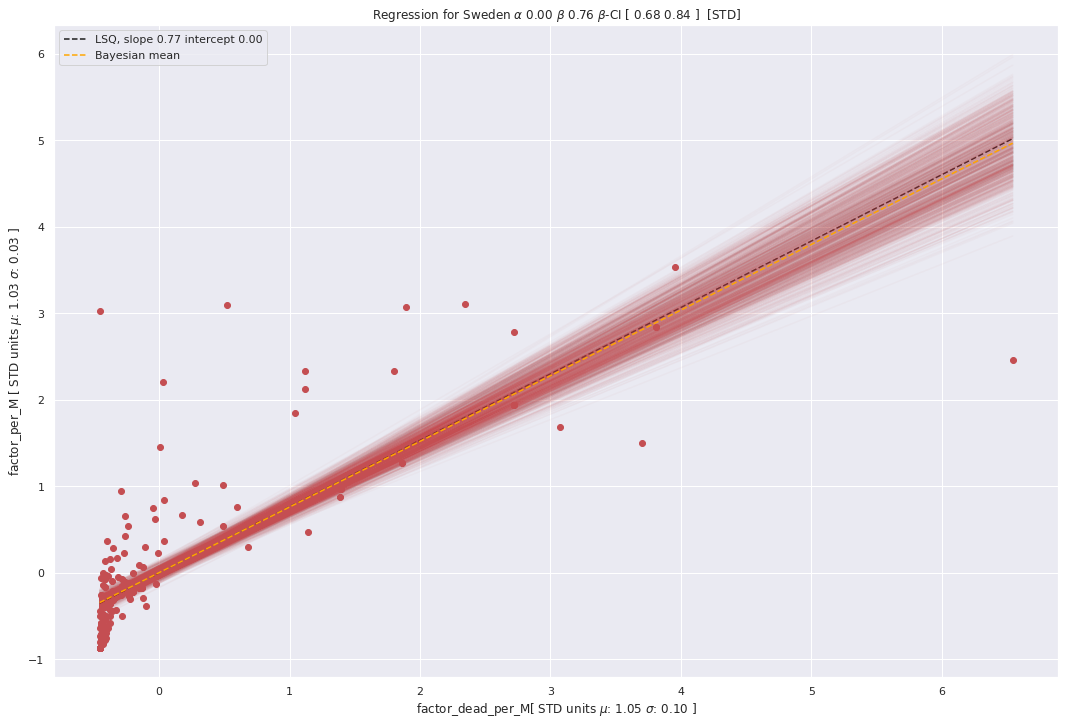

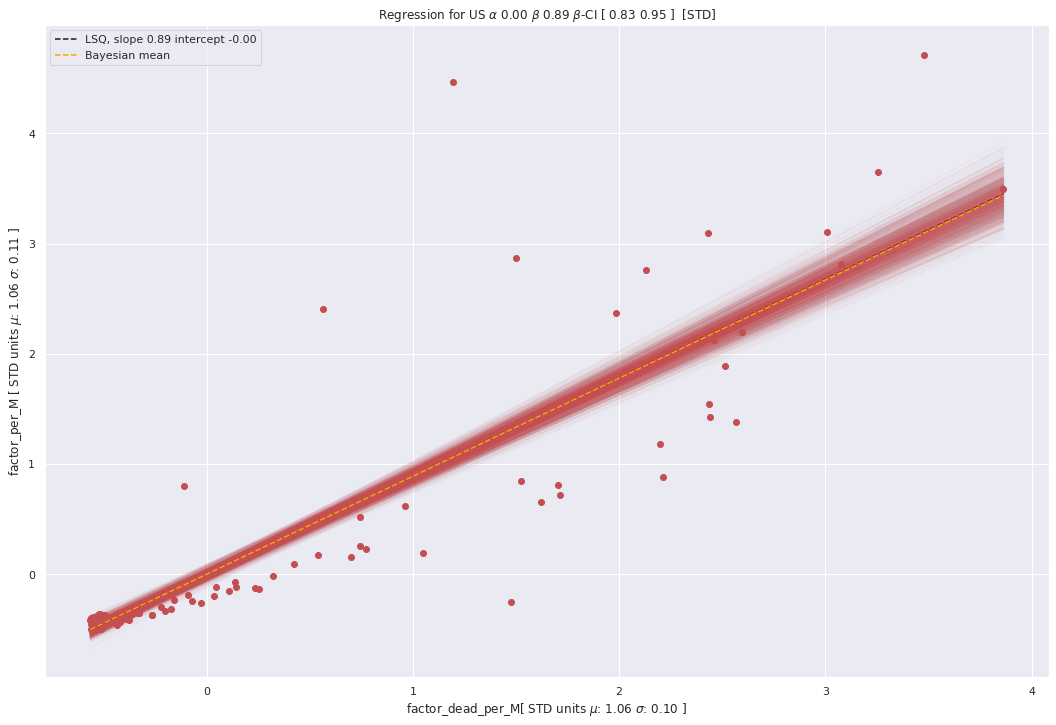

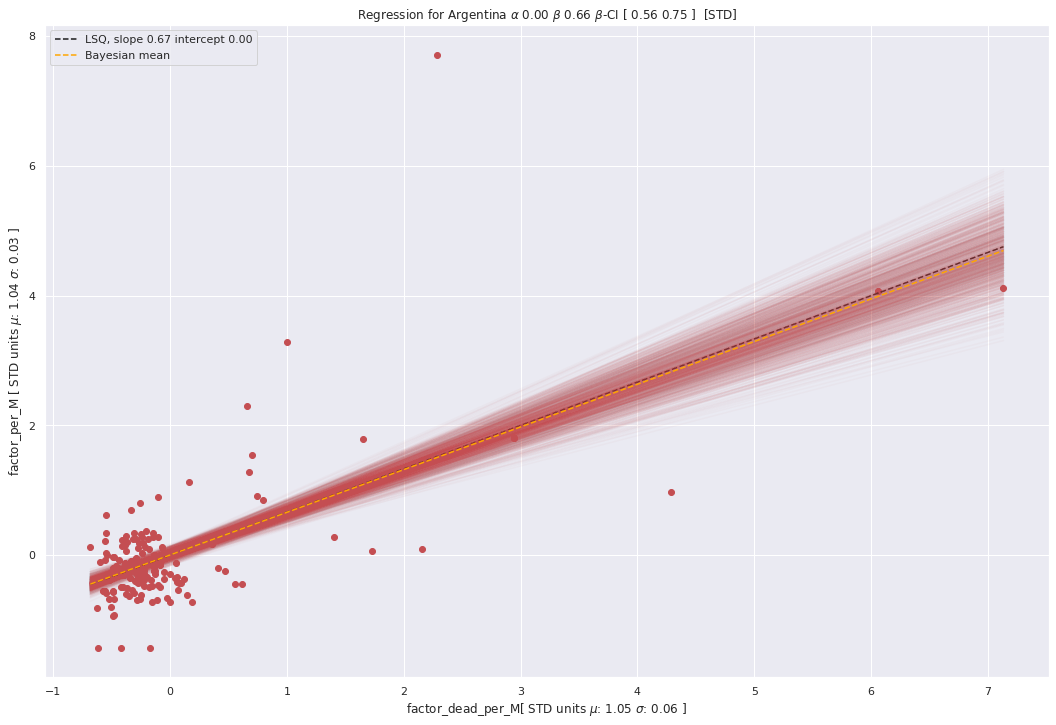

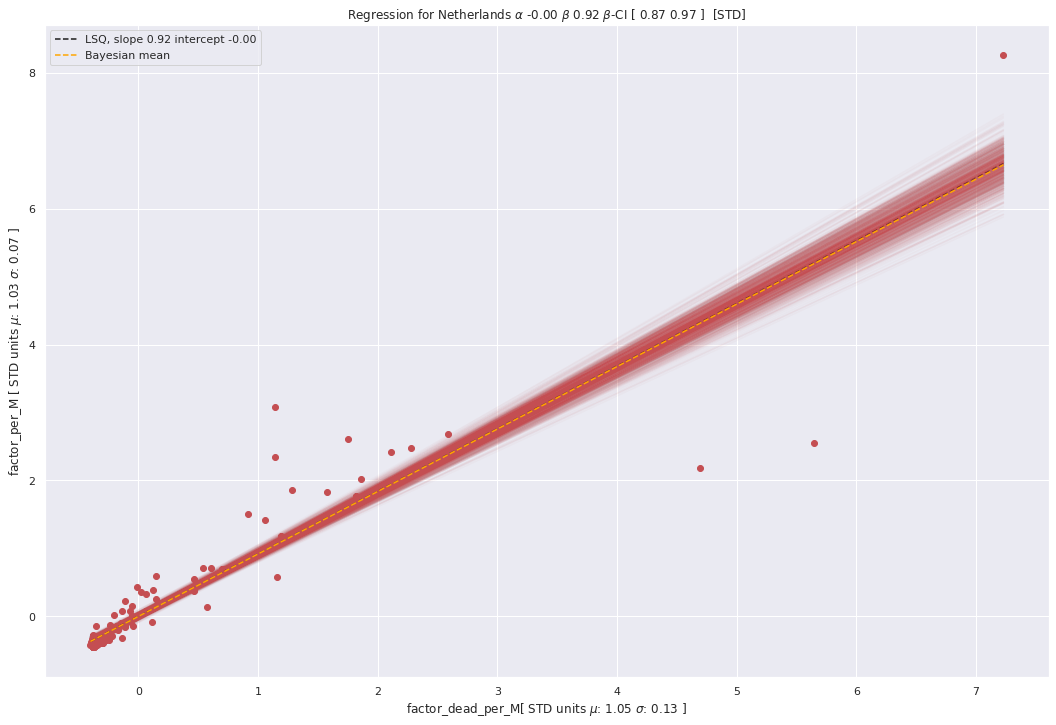

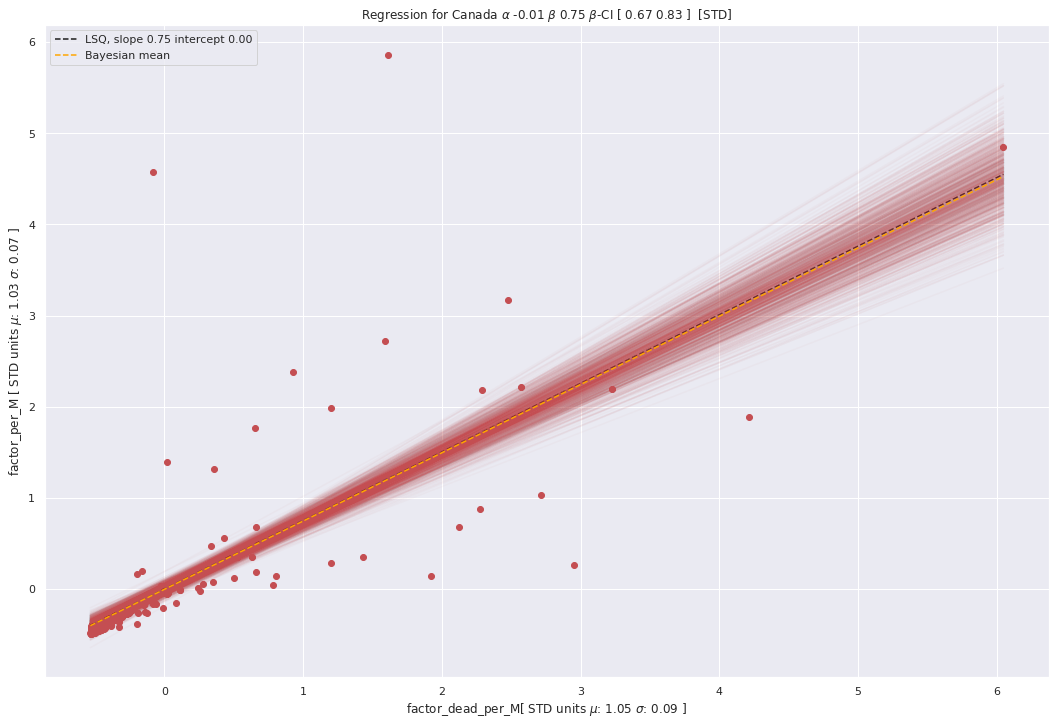

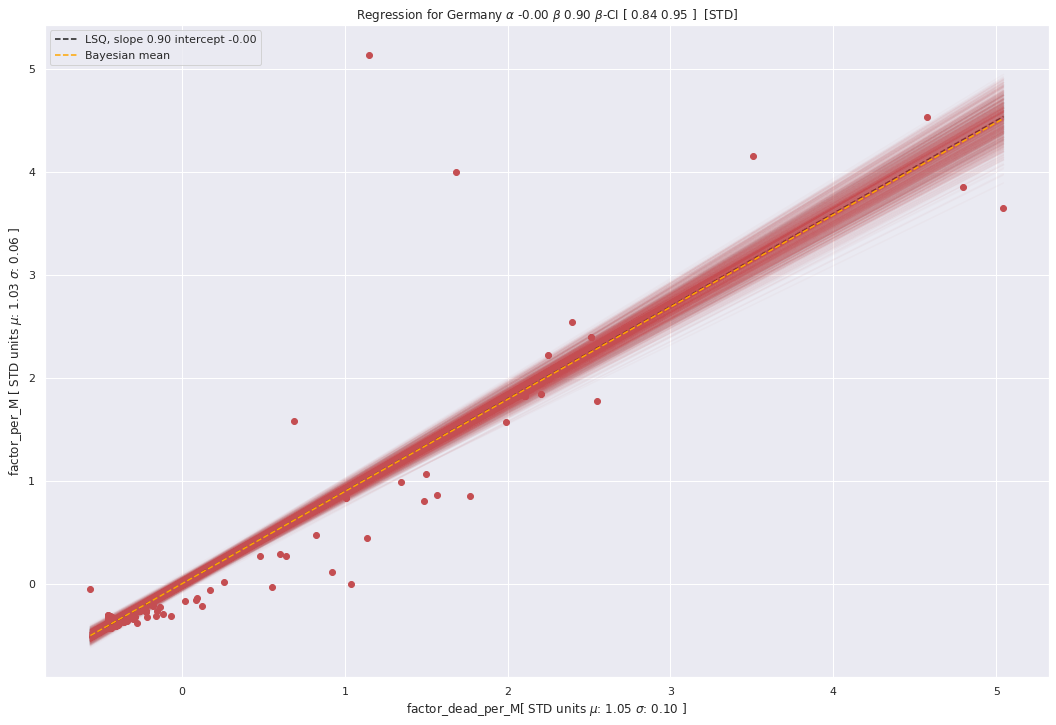

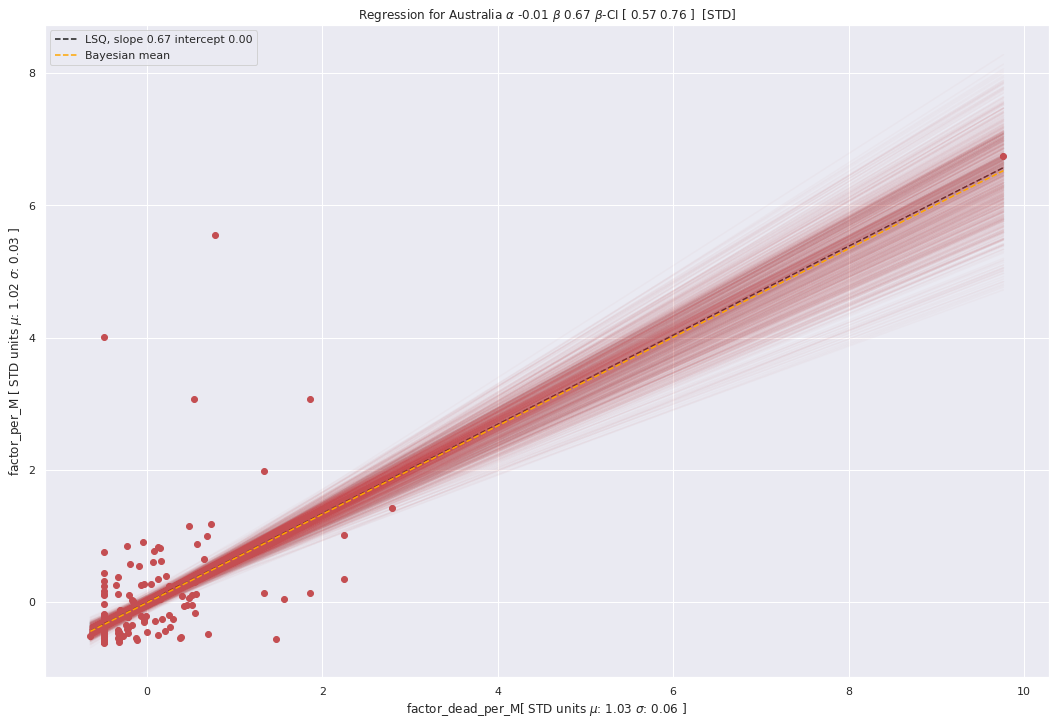

In [11]:

x_param = 'factor_dead_per_M'
y_param = 'factor_per_M'

def regression(x,y,country):
    
    def standardize(x):
        return (x - x.mean()) / x.std()
    
    x_org = x
    y_org = y
    
    x = standardize(x)
    y = standardize(y)
        
    plt.figure(figsize=(18,12))
    plt.ylabel(y_param + r' [ STD units $\mu$: {:.2f} $\sigma$: {:.2f} ]'.format(y_org.mean(),y_org.std()))
    plt.xlabel(x_param + r'[ STD units $\mu$: {:.2f} $\sigma$: {:.2f} ]'.format(x_org.mean(),x_org.std()))
    plt.scatter(x,y,color='r')
    
    slope,intercept,_,_,_ = sps.linregress(x,y)
    
    X = np.linspace(min(x),max(x),1000)
    
    plt.plot(X,[X[i] * slope + intercept for i in range(len(X))], color='k',ls='dashed',
            label='LSQ, slope {:.2f} intercept {:.2f}'.format(slope,intercept))
    
    model = pm.Model()
    with model:
    
        beta_mu = pm.Uniform('beta_mu',-0.5,0.5)
        beta_sigma = pm.Uniform('beta_sigma',0,1)
        alpha_mu = pm.Uniform('alpha_mu', -0.5, 0.5)
        alpha_sigma = pm.Uniform('alpha_sigma',0,1)

        beta = pm.Normal('beta',beta_mu,sd=beta_sigma )
        alpha = pm.Normal('alpha',alpha_mu,sd=alpha_sigma)

        obs_sigma = pm.Uniform('obs_sigma',0,1)

        
        linreq =  pm.Deterministic('linreq',x.values * beta + alpha)

        obs = pm.Normal('obs',mu=linreq,sd=obs_sigma,observed=y)

        trace = pm.sample(500,tune=500)
    
    beta_post = trace['beta'][:]
    alpha_post = trace['alpha'][:]
    
    result = pd.DataFrame({'beta_post': beta_post,
                          'alpha_post' : alpha_post})
    
    print()
    print (result.describe())
    
    CI_89 = np.percentile(result.beta_post,[5.5,94.5])
    
    plt.title(r'Regression for {} $\alpha$ {:.2f} $\beta$ {:.2f} $\beta$-CI [ {:.2f} {:.2f} ]  [STD]'.format(
        country,result.alpha_post.mean(),result.beta_post.mean(),CI_89[0],CI_89[1]))

    
    beta_samples = np.random.choice(result.beta_post,replace=True,size=len(X))
    alpha_samples = np.random.choice(result.alpha_post,replace=True,size=len(X))
    
    lines = np.array([X[i] * beta_samples + alpha_samples for i in range(len(X))])
    plt.plot(X,lines,alpha=0.03,color='r')
    
    plt.plot(X,[X[i] * result.beta_post.mean() + result.alpha_post.mean() for i in range(len(X))],
             color='orange',ls='dashed',label='Bayesian mean')
 
    plt.legend(loc='upper left')
    
    plt.savefig('growth_factor_regression_{}.jpg'.format(country),format='jpg')
    
for country in countries:

    df = dick[country]
    
    try:
        df = df.drop(['dead_conf_ratio','conf_over_dead'],axis=1)
    except:
        print ('Skipping delete col for {}'.format(country))
        
    population = country_populations.loc[country,'population']
    df['conf_per_M'] = df['confirmed'] / (population / 1e6)
    df['dead_per_M'] = df['deceased'] / (population / 1e6)
    df['factor_per_M'] = df['conf_per_M'] / df['conf_per_M'].shift()
    df['factor_dead_per_M'] = df['dead_per_M'] / df['dead_per_M'].shift()
    
    mask = ( ( df['confirmed'] >= confirmed_min ) & ( df['deceased'] >= dead_min))
    df = df[mask]
    df = df.replace(np.inf,np.nan)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    model = pm.Model()
    with model:
        regression(df[x_param],df[y_param],country)


In [12]:
shifted_df = df.copy()
shifted_df[x_param] = shifted_df[x_param].shift(7)
shifted_df.dropna(inplace=True)

x_param = 'dead_inc'
y_param = 'inc'
#regression(shifted_df[x_param],shifted_df[y_param],'Italy')



In [13]:
def plot_trend(country_name):
    
    country = dick[country_name]
    
    plt.figure(figsize=(18,12))
    plt.title('{} growth of confirmed and deceased'.format(country_name.upper()))
    ax = plt.gca()
    ax2 = plt.twinx()
    country['inc'].cumsum().plot(ax=ax,color='orange',label='cumulative inc daily confirmed')
    country['dead_inc'].cumsum().plot(ax=ax2,color='red',label='cumulative inc daily deceased')
    ax.set_ylabel('Confirmed')
    ax2.set_ylabel('Deceased')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    #ax.set_yscale('log')
    #ax2.set_yscale('log')
    plt.savefig('{}_growth_confirmed_deceased.jpg'.format(country_name.upper()),format='jpg')

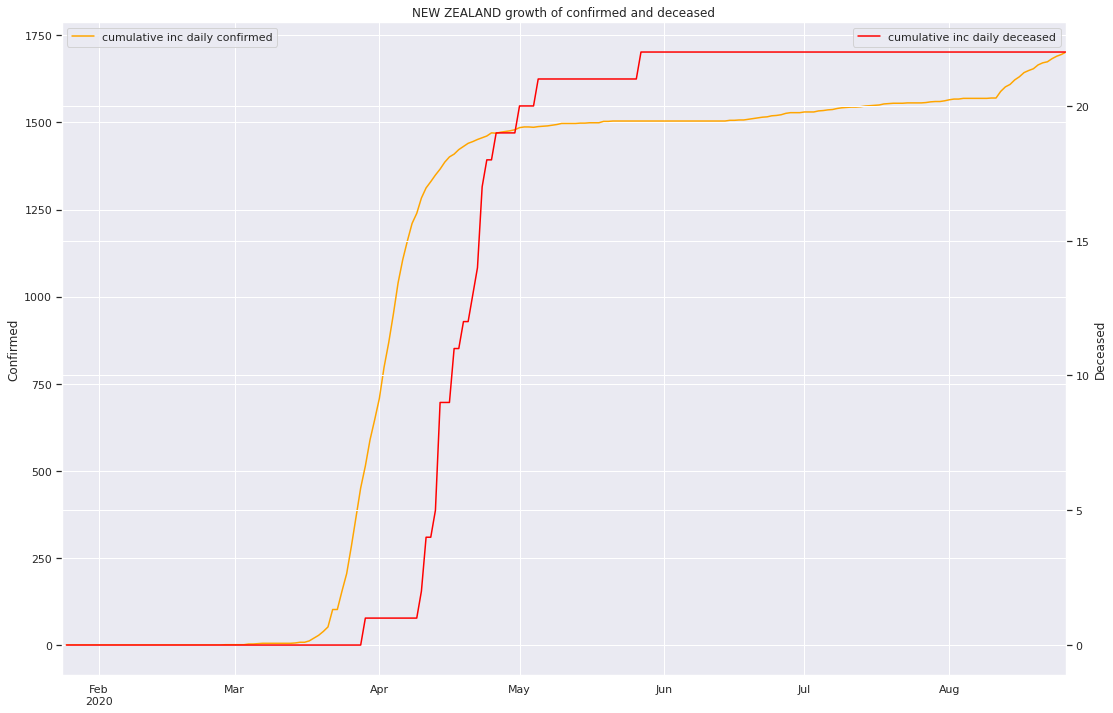

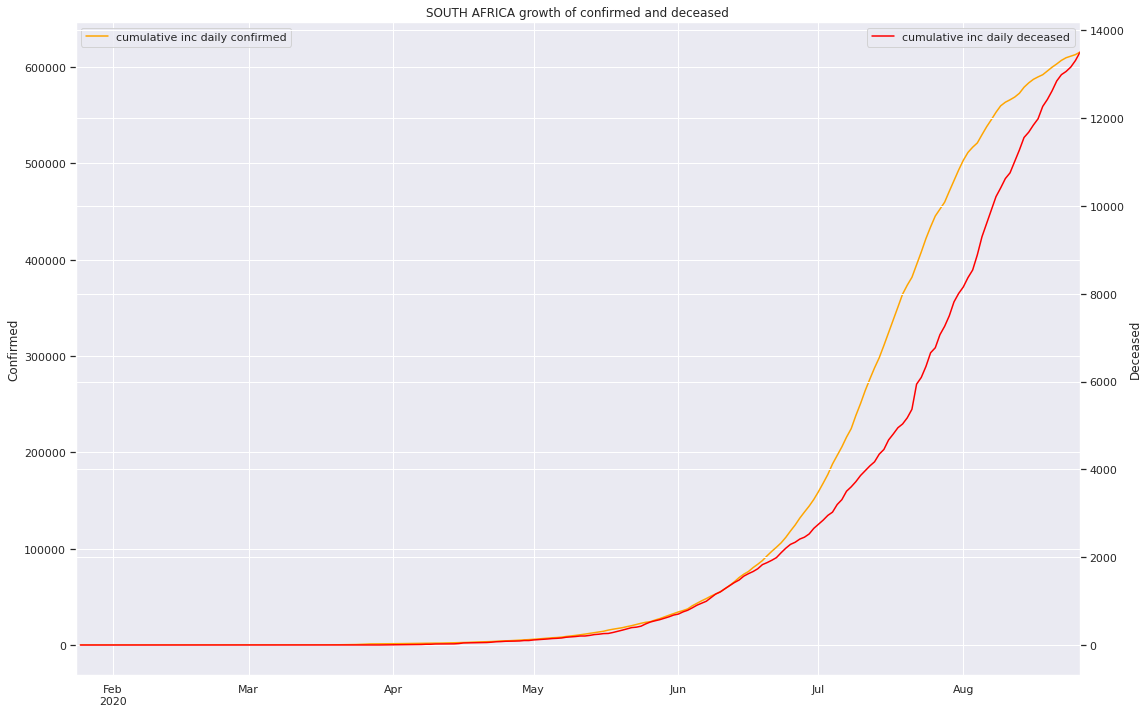

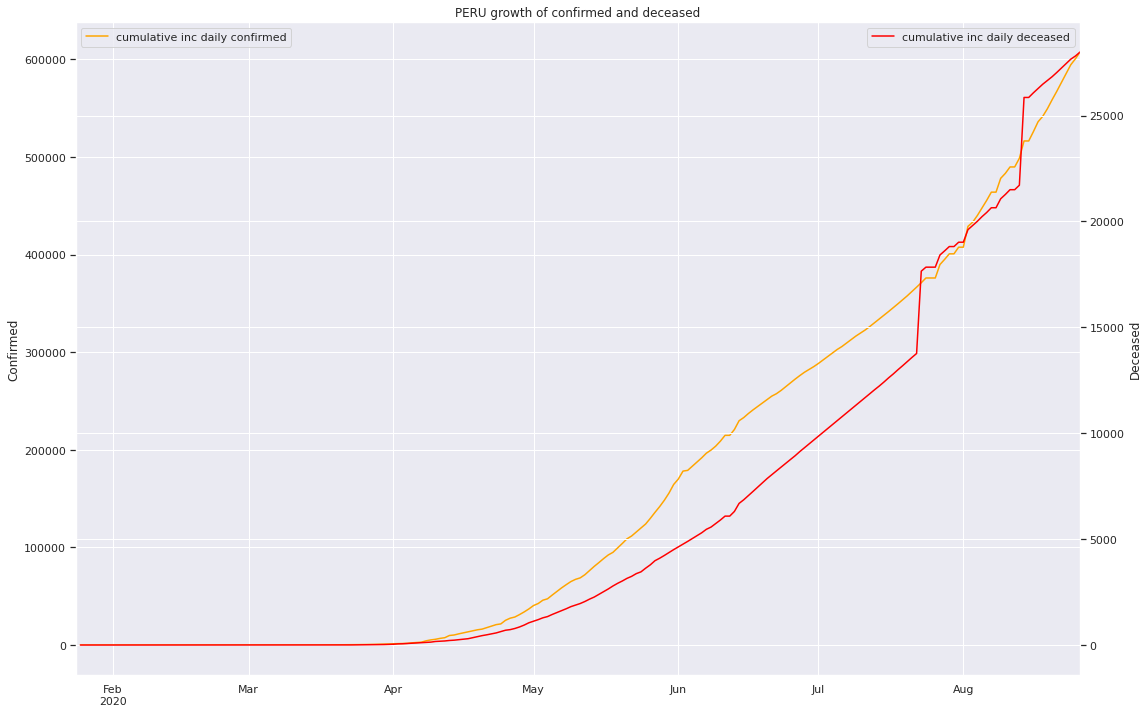

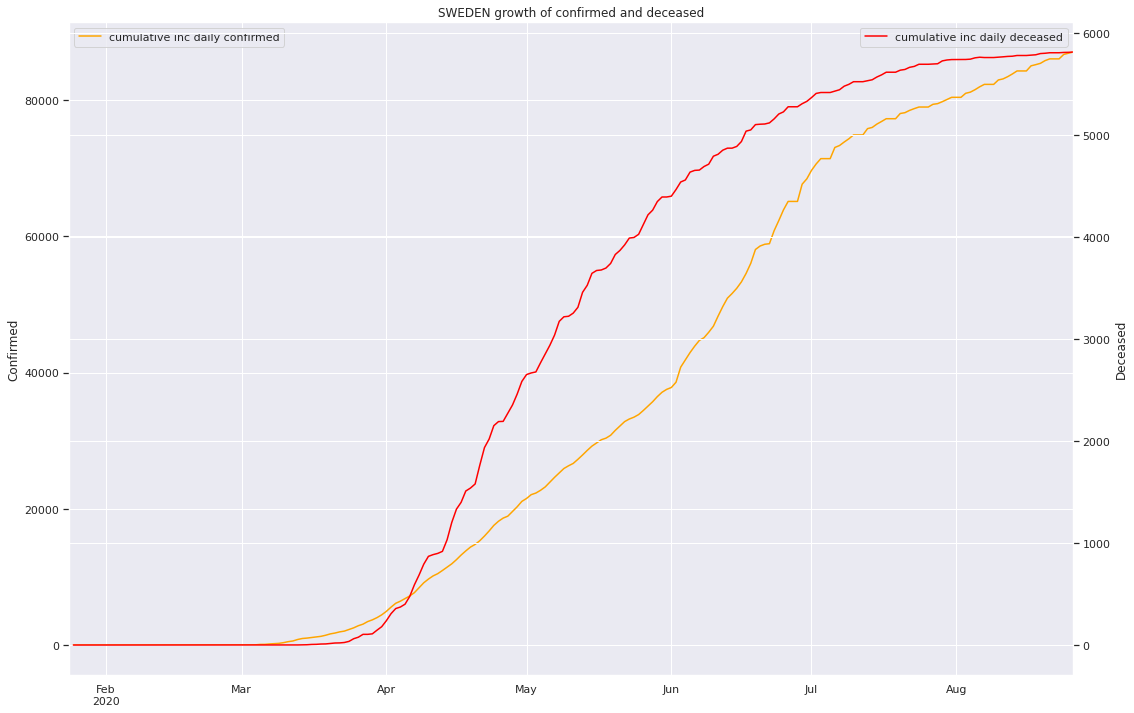

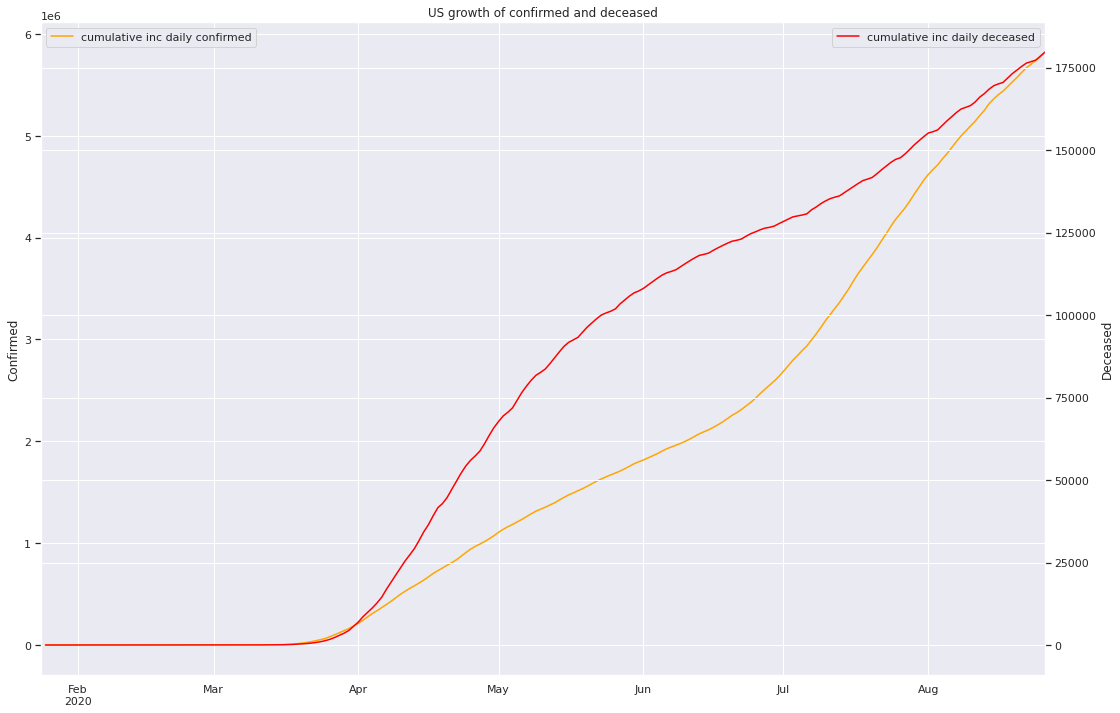

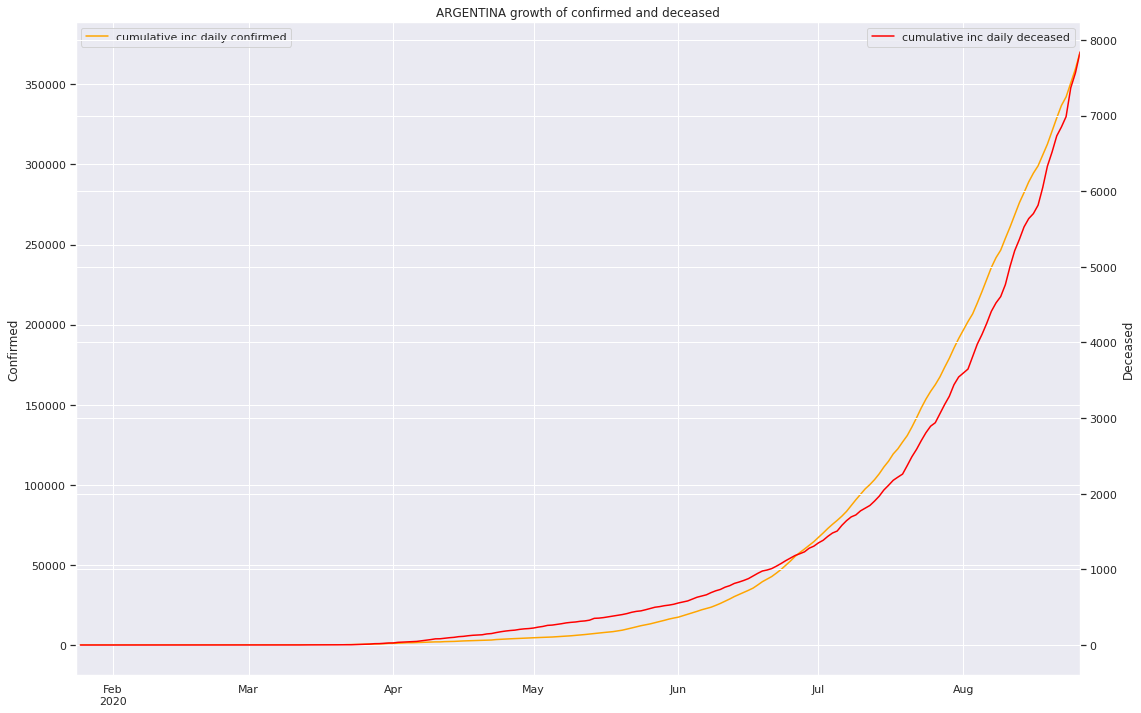

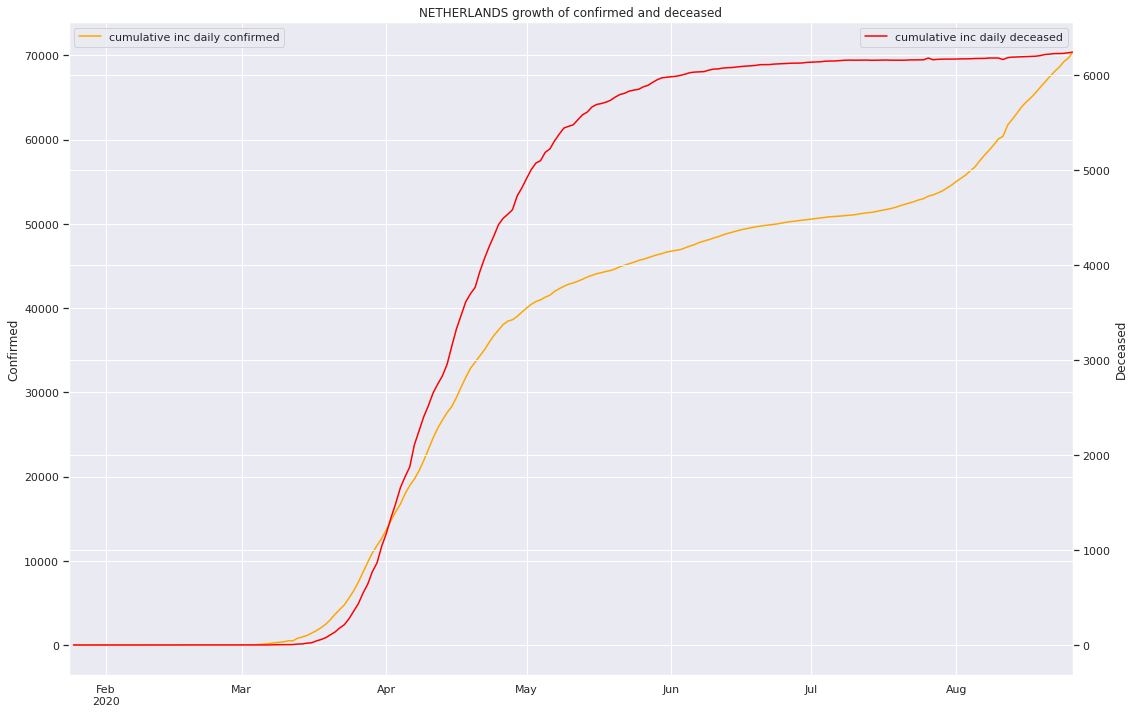

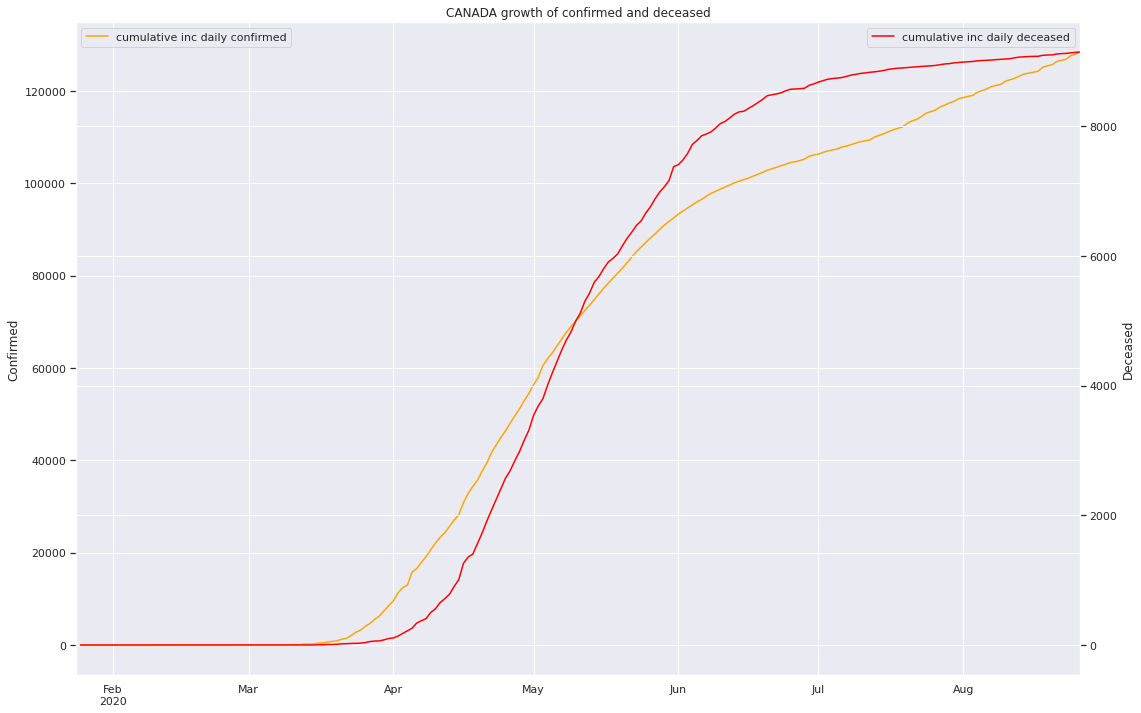

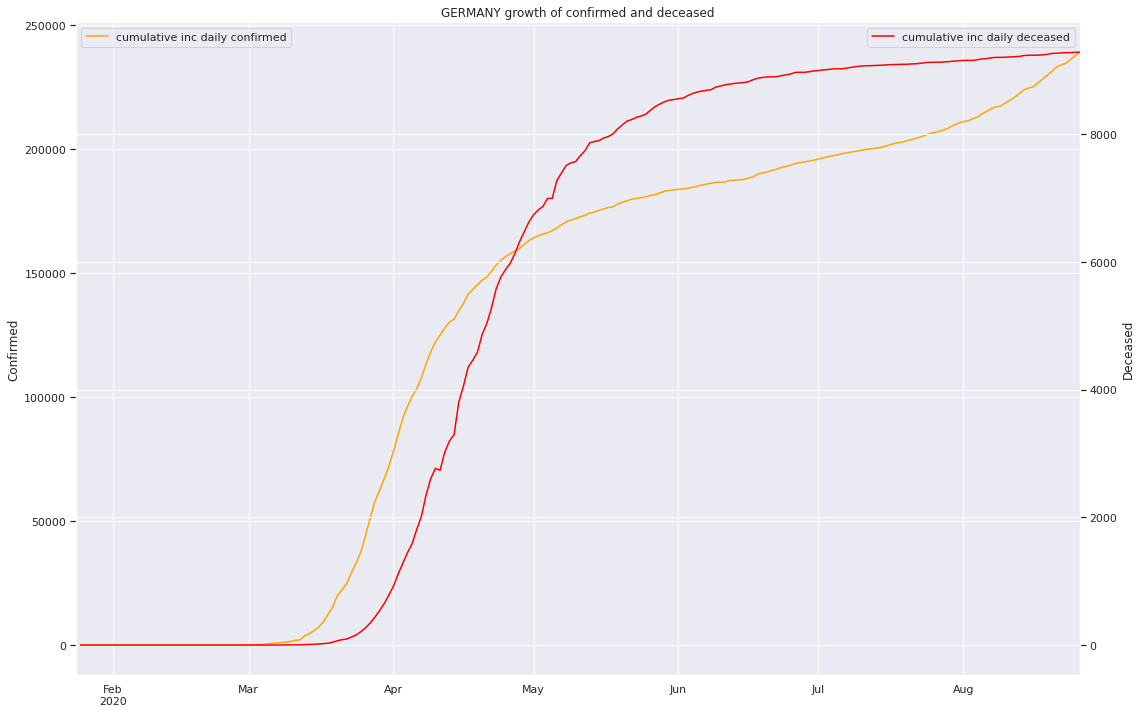

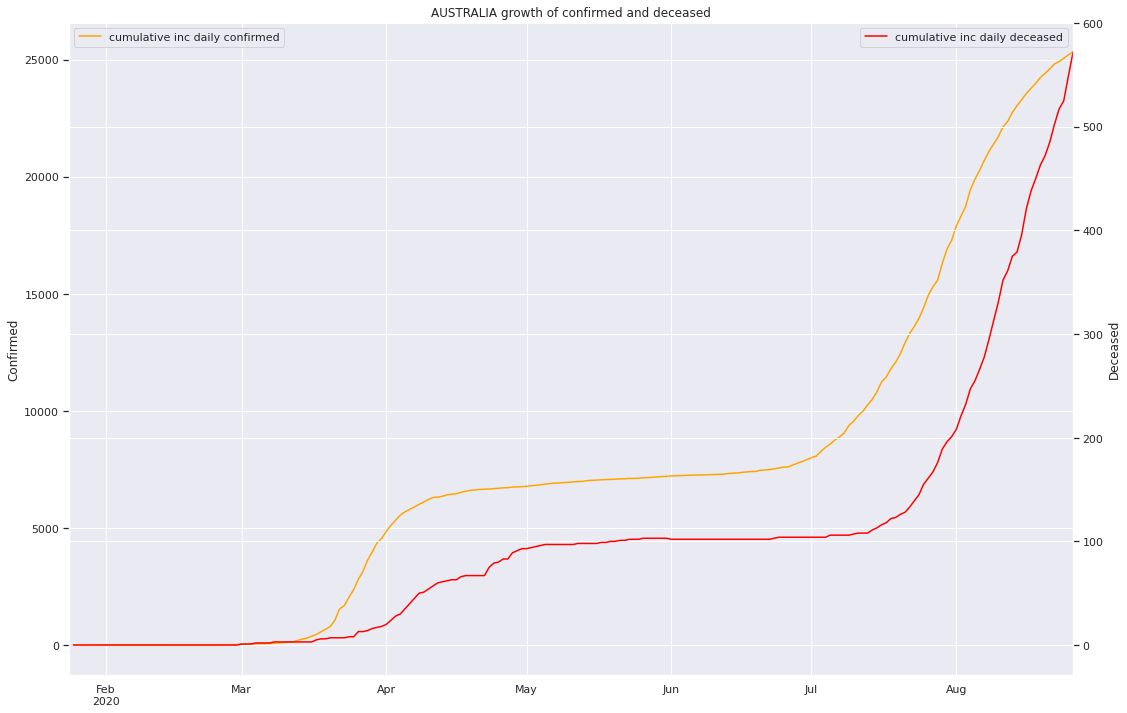

In [14]:
for c in countries:
    plot_trend(c)

<ipython-input-15-c8ba617bf66e>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(211)
<ipython-input-15-c8ba617bf66e>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(212)
<ipython-input-15-c8ba617bf66e>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

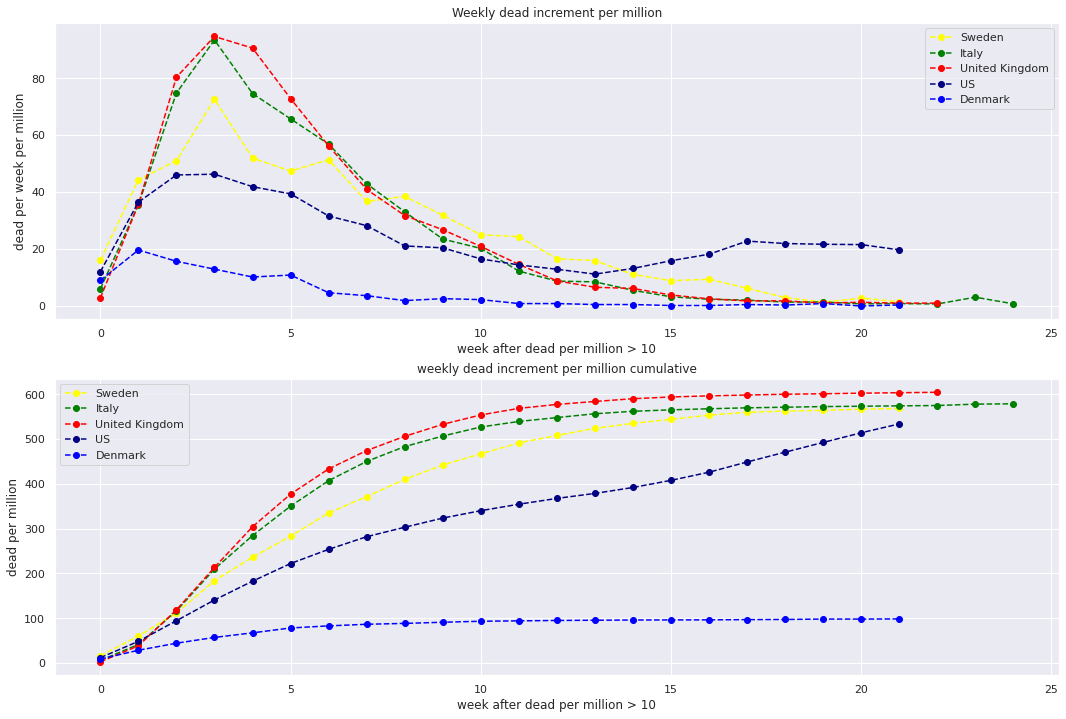

In [15]:
countries = ['Sweden','Italy','United Kingdom','US','Denmark']
colors = ['yellow','green','red','navy','blue']

plt.figure(figsize=(18,12))


for i,c in enumerate(countries):
    country = dick[c]
    country['dead_inc_per_M'] = country['dead_inc'] / (country_populations.loc[c,'population'] / 1e6)
    country = country.loc[country['dead_per_M'] > 10]
    country_weekly = country.resample(yesterday(today)).sum()
    country.reset_index(inplace=True)
    country_weekly.reset_index(inplace=True)
    
    plt.subplot(211)
    plt.title('Weekly dead increment per million')
    plt.plot(country_weekly.index,country_weekly['dead_inc_per_M'],'o--',color=colors[i],label=c)

    plt.legend(loc='upper right')
    plt.ylabel('dead per week per million')
    plt.xlabel('week after dead per million > 10')
    
    plt.subplot(212)
    plt.title('weekly dead increment per million cumulative')
    plt.plot(country_weekly.index,country_weekly['dead_inc_per_M'].cumsum(),'o--',color=colors[i],label=c)
    plt.xlabel('week after dead per million > 10')
    plt.ylabel('dead per million')
    plt.legend(loc='upper left')

In [16]:
swe = dick['Sweden']
swe

confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-01-24          0       NaN    NaN         0          NaN       NaN   
2020-01-25          0       NaN    0.0         0          NaN       0.0   
2020-01-26          0       NaN    0.0         0          NaN       0.0   
2020-01-27          0       NaN    0.0         0          NaN       0.0   
2020-01-28          0       NaN    0.0         0          NaN       0.0   
...               ...       ...    ...       ...          ...       ...   
2020-08-22      86068  1.000000    0.0      5810     1.000000       0.0   
2020-08-23      86068  1.000000    0.0      5810     1.000000       0.0   
2020-08-24      86721  1.007587  653.0      5813     1.000516       3.0   
2020-08-25      86891  1.001960  170.0      5814     1.000172       1.0   
2020-08-26      87072  1.002083  181.0      5817     1.000516       3.0   

            pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-01-24       NaN             NaN              NaN     0.000000   
2020-01-25       NaN             NaN              NaN     0.000000   
2020-01-26       NaN             NaN              NaN     0.000000   
2020-01-27       NaN             NaN              NaN     0.000000   
2020-01-28       NaN             NaN              NaN     0.000000   
...              ...             ...              ...          ...   
2020-08-22  6.750476       14.813769         1.000000  8522.204339   
2020-08-23  6.750476       14.813769         1.000000  8522.204339   
2020-08-24  6.703105       14.918459         0.992983  8586.862509   
2020-08-25  6.691142       14.945132         0.998215  8603.695417   
2020-08-26  6.680678       14.968540         0.998436  8621.617514   

            dead_per_M  factor_per_M  factor_dead_per_M  dead_inc_per_M  
2020-01-24    0.000000           NaN                NaN             NaN  
2020-01-25    0.000000           NaN                NaN        0.000000  
2020-01-26    0.000000           NaN                NaN        0.000000  
2020-01-27    0.000000           NaN                NaN        0.000000  
2020-01-28    0.000000           NaN                NaN        0.000000  
...                ...           ...                ...             ...  
2020-08-22  575.289390      1.000000           1.000000        0.000000  
2020-08-23  575.289390      1.000000           1.000000        0.000000  
2020-08-24  575.586441      1.007587           1.000516        0.297051  
2020-08-25  575.685458      1.001960           1.000172        0.099017  
2020-08-26  575.982510      1.002083           1.000516        0.297051  

[216 rows x 14 columns]

In [17]:
swe

confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-01-24          0       NaN    NaN         0          NaN       NaN   
2020-01-25          0       NaN    0.0         0          NaN       0.0   
2020-01-26          0       NaN    0.0         0          NaN       0.0   
2020-01-27          0       NaN    0.0         0          NaN       0.0   
2020-01-28          0       NaN    0.0         0          NaN       0.0   
...               ...       ...    ...       ...          ...       ...   
2020-08-22      86068  1.000000    0.0      5810     1.000000       0.0   
2020-08-23      86068  1.000000    0.0      5810     1.000000       0.0   
2020-08-24      86721  1.007587  653.0      5813     1.000516       3.0   
2020-08-25      86891  1.001960  170.0      5814     1.000172       1.0   
2020-08-26      87072  1.002083  181.0      5817     1.000516       3.0   

            pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-01-24       NaN             NaN              NaN     0.000000   
2020-01-25       NaN             NaN              NaN     0.000000   
2020-01-26       NaN             NaN              NaN     0.000000   
2020-01-27       NaN             NaN              NaN     0.000000   
2020-01-28       NaN             NaN              NaN     0.000000   
...              ...             ...              ...          ...   
2020-08-22  6.750476       14.813769         1.000000  8522.204339   
2020-08-23  6.750476       14.813769         1.000000  8522.204339   
2020-08-24  6.703105       14.918459         0.992983  8586.862509   
2020-08-25  6.691142       14.945132         0.998215  8603.695417   
2020-08-26  6.680678       14.968540         0.998436  8621.617514   

            dead_per_M  factor_per_M  factor_dead_per_M  dead_inc_per_M  
2020-01-24    0.000000           NaN                NaN             NaN  
2020-01-25    0.000000           NaN                NaN        0.000000  
2020-01-26    0.000000           NaN                NaN        0.000000  
2020-01-27    0.000000           NaN                NaN        0.000000  
2020-01-28    0.000000           NaN                NaN        0.000000  
...                ...           ...                ...             ...  
2020-08-22  575.289390      1.000000           1.000000        0.000000  
2020-08-23  575.289390      1.000000           1.000000        0.000000  
2020-08-24  575.586441      1.007587           1.000516        0.297051  
2020-08-25  575.685458      1.001960           1.000172        0.099017  
2020-08-26  575.982510      1.002083           1.000516        0.297051  

[216 rows x 14 columns]

In [18]:
swe_weekly = swe.resample('w').sum()
swe_weekly

confirmed     factor     inc  deceased  dead_factor  dead_inc  \
2020-01-26          0   0.000000     0.0         0     0.000000       0.0   
2020-02-02          3   2.000000     1.0         0     0.000000       0.0   
2020-02-09          7   7.000000     0.0         0     0.000000       0.0   
2020-02-16          7   7.000000     0.0         0     0.000000       0.0   
2020-02-23          7   7.000000     0.0         0     0.000000       0.0   
2020-03-01         44  11.380952    13.0         0     0.000000       0.0   
2020-03-08        630  10.753207   189.0         0     0.000000       0.0   
2020-03-15       4499   8.862574   819.0         8     5.500000       3.0   
2020-03-22      10347   7.669655   912.0        91     9.449784      18.0   
2020-03-29      19914   7.681705  1766.0       520     9.005889      89.0   
2020-04-05      38382   7.642735  3130.0      2005     8.455934     291.0   
2020-04-12      62778   7.443098  3653.0      5204     7.875419     498.0   
2020-04-19      88283   7.323758  3902.0      8939     7.567668     641.0   
2020-04-26     117242   7.264228  4255.0     13841     7.368198     654.0   
2020-05-03     145860   7.182735  3677.0     17678     7.203570     485.0   
2020-05-10     171986   7.167110  4005.0     21224     7.188571     546.0   
2020-05-17     199460   7.136926  3821.0     24557     7.133626     454.0   
2020-05-24     224327   7.105268  3316.0     27058     7.083808     319.0   
2020-05-31     250229   7.116131  4083.0     29780     7.095547     397.0   
2020-06-07     290645   7.178082  7188.0     31929     7.058736     264.0   
2020-06-14     338388   7.144821  6884.0     33622     7.045340     215.0   
2020-06-21     391826   7.132753  7234.0     35249     7.047800     237.0   
2020-06-28     441394   7.102840  6289.0     36562     7.032659     169.0   
2020-07-05     490706   7.093188  6282.0     37684     7.026249     140.0   
2020-07-12     519290   7.047905  3479.0     38440     7.019412     106.0   
2020-07-19     537039   7.031447  2383.0     39103     7.016722      93.0   
2020-07-26     550472   7.022031  1716.0     39719     7.013808      78.0   
2020-08-02     560037   7.017914  1425.0     40100     7.008056      46.0   
2020-08-09     572669   7.023425  1901.0     40306     7.003480      20.0   
2020-08-16     586287   7.023726  1971.0     40435     7.003466      20.0   
2020-08-23     599689   7.020886  1774.0     40614     7.004661      27.0   
2020-08-30     260684   3.011630  1004.0     17444     3.001204       7.0   

             pct_dead  conf_over_dead  dead_conf_ratio    conf_per_M  \
2020-01-26   0.000000        0.000000         0.000000      0.000000   
2020-02-02   0.000000        0.000000         0.000000      0.297051   
2020-02-09   0.000000        0.000000         0.000000      0.693120   
2020-02-16   0.000000        0.000000         0.000000      0.693120   
2020-02-23   0.000000        0.000000         0.000000      0.693120   
2020-03-01   0.000000        0.000000         0.000000      4.356753   
2020-03-08   0.000000        0.000000         0.000000     62.380777   
2020-03-15   0.991454     2734.166667         4.675135    445.477963   
2020-03-22   5.874954      895.234253         8.637653   1024.530003   
2020-03-29  17.402851      318.658559         8.205551   1971.826663   
2020-04-05  35.545635      142.436173         7.735459   3800.474589   
2020-04-12  57.433914       86.142794         7.402979   6216.095924   
2020-04-19  70.367010       70.242555         7.233279   8741.527230   
2020-04-26  82.456795       59.537692         7.099450  11608.963623   
2020-05-03  84.824256       57.772211         7.020239  14442.635182   
2020-05-10  86.363829       56.741657         7.020913  17029.556111   
2020-05-17  86.169252       56.869737         6.996591  19749.952100   
2020-05-24  84.452486       58.023840         6.978893  22212.210493   
2020-05-31  83.324527       58.810094         6.979685  24776.951590   
2020-06-07  77.074637       63

<BarContainer object of 32 artists>

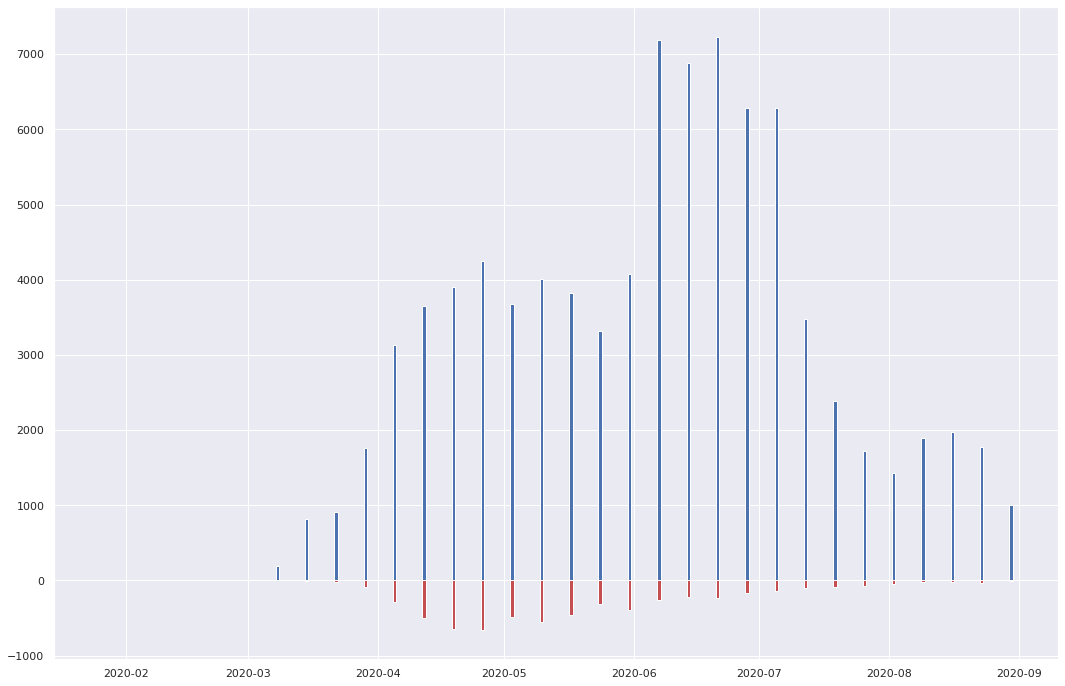

In [19]:
plt.figure(figsize=(18,12))
ax=plt.gca()
ax.bar(swe_weekly.index,swe_weekly['inc'])
ax.bar(swe_weekly.index,-swe_weekly['dead_inc'],color='r')


<BarContainer object of 32 artists>

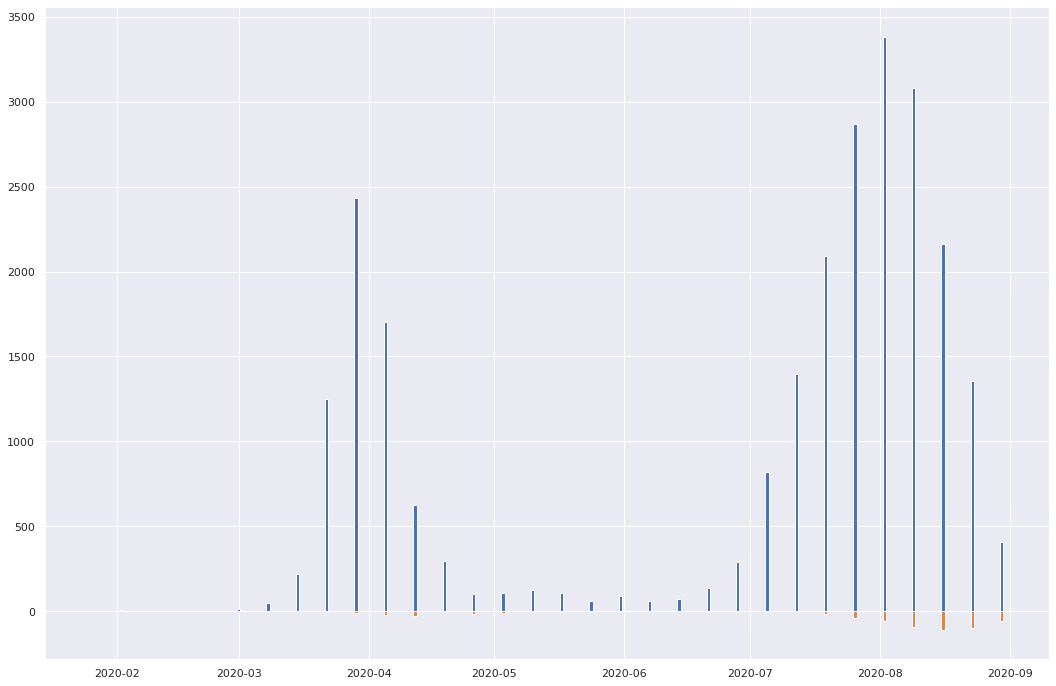

In [20]:
aus = dick['Australia']
aus_weekly = aus.resample('w').sum()

plt.figure(figsize=(18,12))
plt.bar(aus_weekly.index,aus_weekly['inc'])
plt.bar(aus_weekly.index,-aus_weekly['dead_inc'])

<BarContainer object of 32 artists>

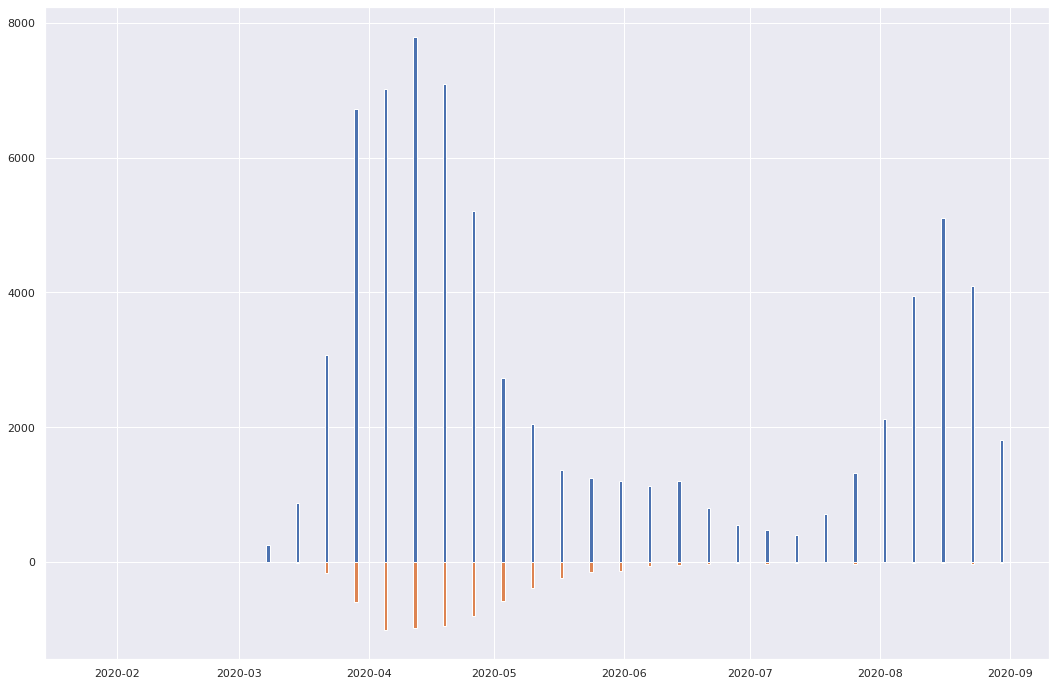

In [21]:
ned = dick['Netherlands']
ned_weekly = ned.resample('w').sum()

plt.figure(figsize=(18,12))
plt.bar(ned_weekly.index,ned_weekly['inc'])
plt.bar(ned_weekly.index,-ned_weekly['dead_inc'])

In [22]:
def normalize(series):
    return series / series.max()

def reflexive_plot(country_name):
    
    country = dick[country_name][:-1]
    last_date = country.index[-1].date()
    
    country_weekly = country.resample('w').sum()
    
    plt.figure(figsize=(18,12))
    plt.title(country_name.upper() + ' Normalized weekly cases and deaths YTD {} '.format(last_date))
    plt.bar(country_weekly.index,normalize(country_weekly['inc']),label='cases',color='orange')
    plt.bar(country_weekly.index,-normalize(country_weekly['dead_inc']),label='deaths',color='crimson')
    plt.yticks(np.arange(-1,1.25,0.25),np.abs(np.arange(-1,1.25,0.25)))
    plt.legend(loc='upper left')
    plt.ylabel('Normalized values')
    
    plt.savefig('normalized_cases_deaths_{}.jpg'.format(country_name),format='jpg')
    
    
    

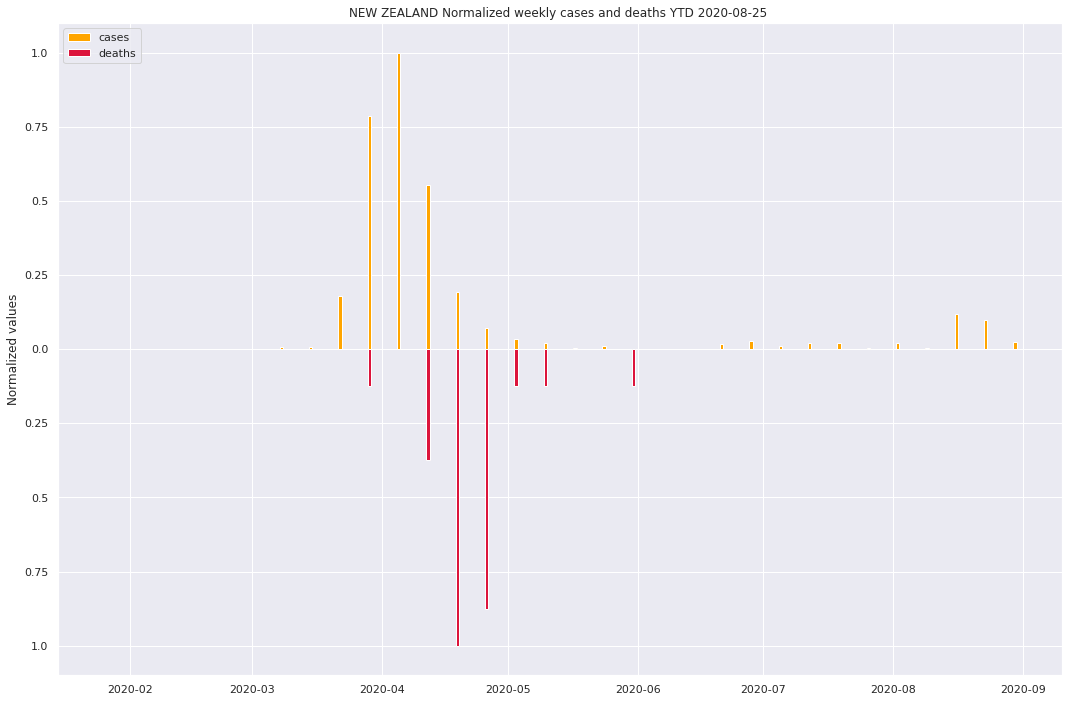

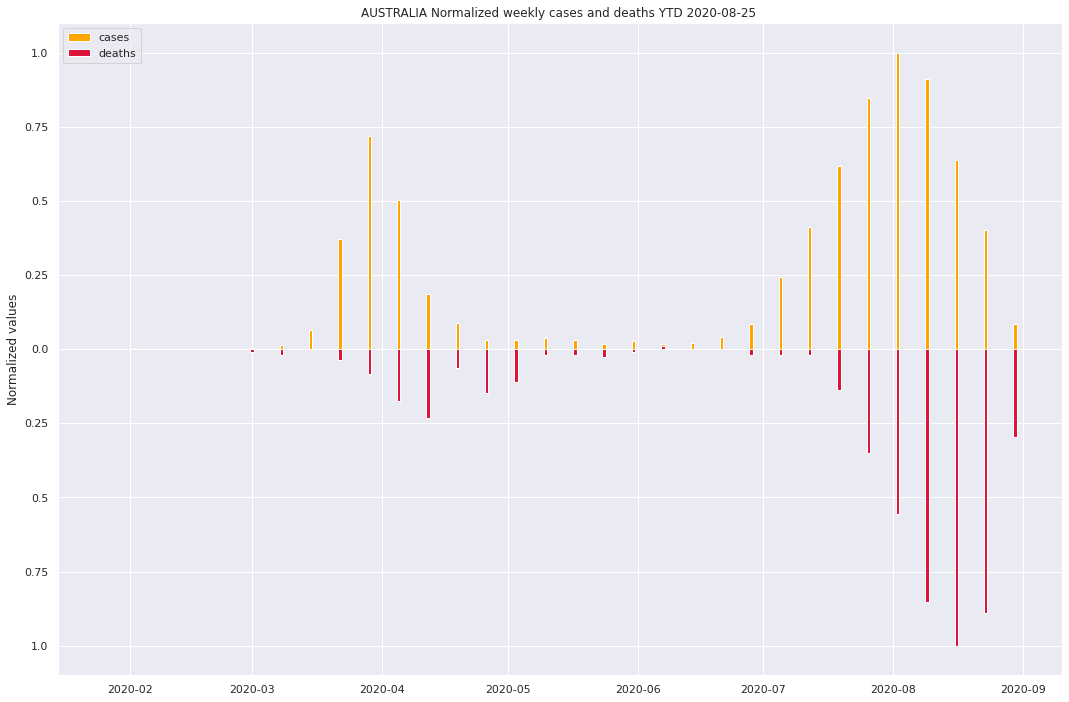

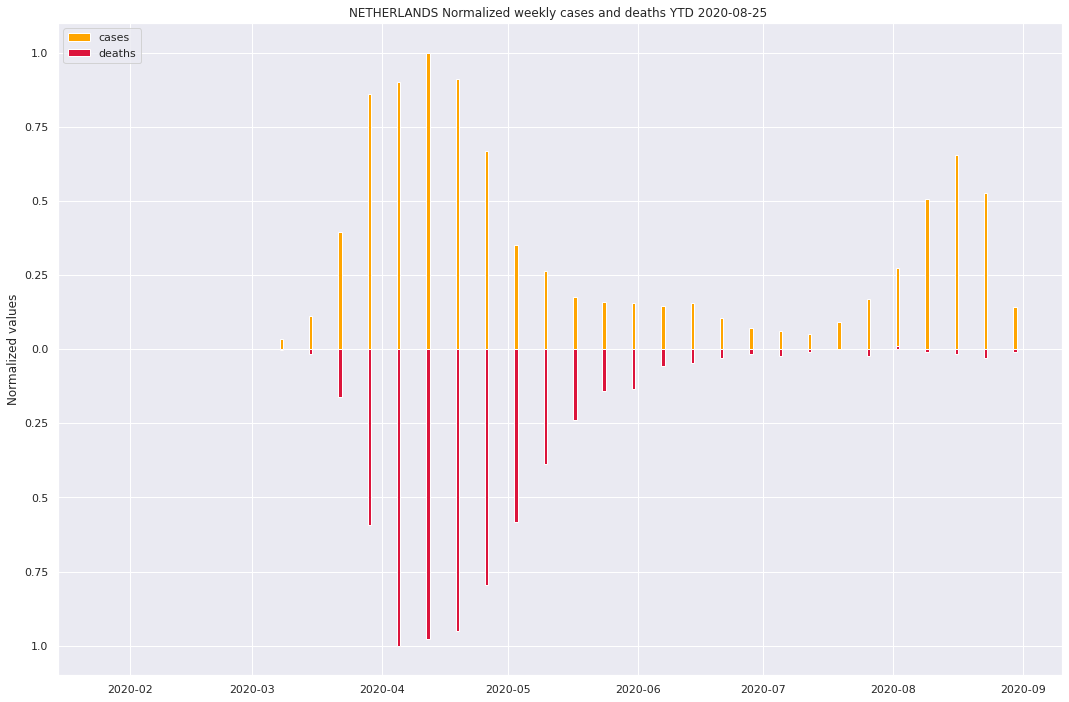

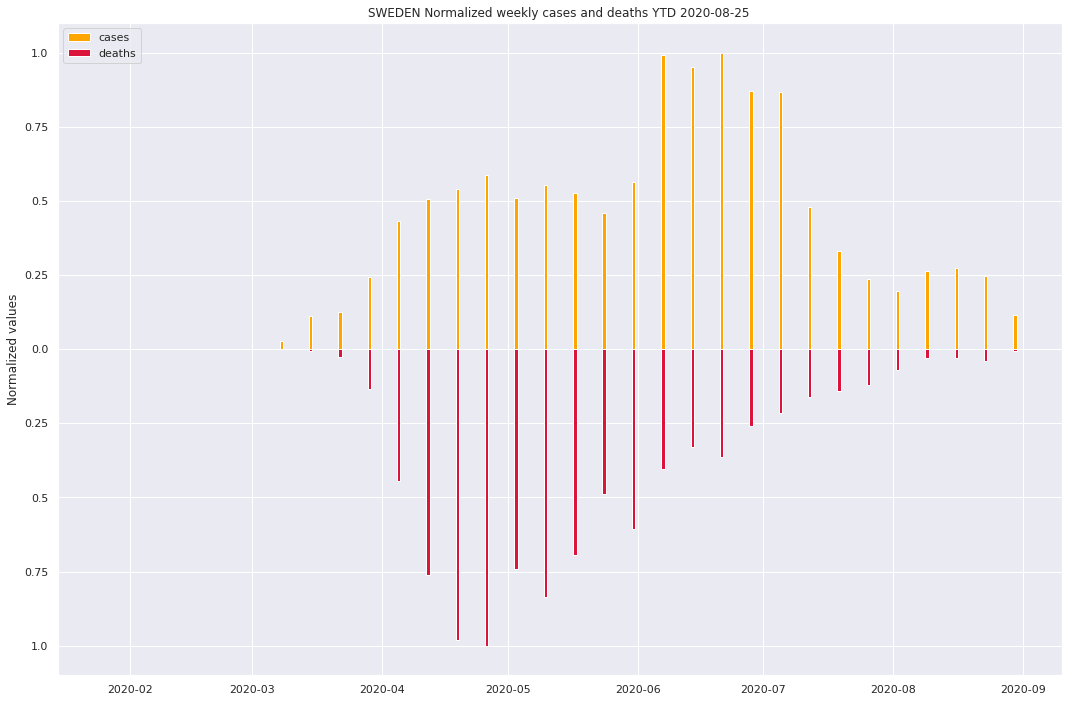

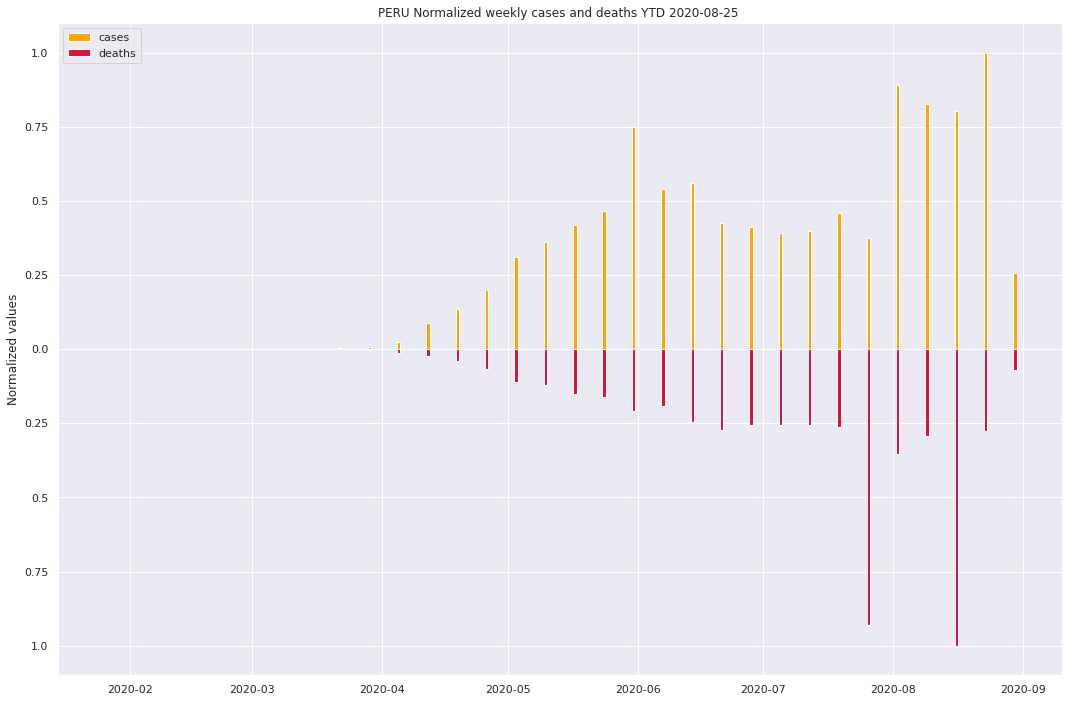

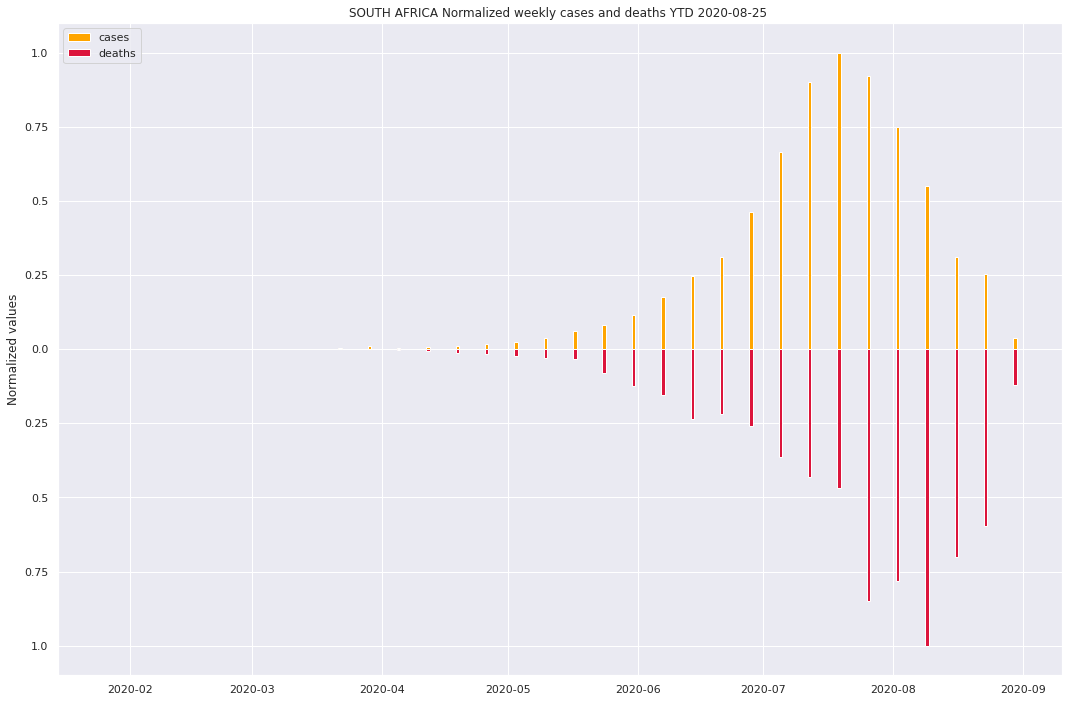

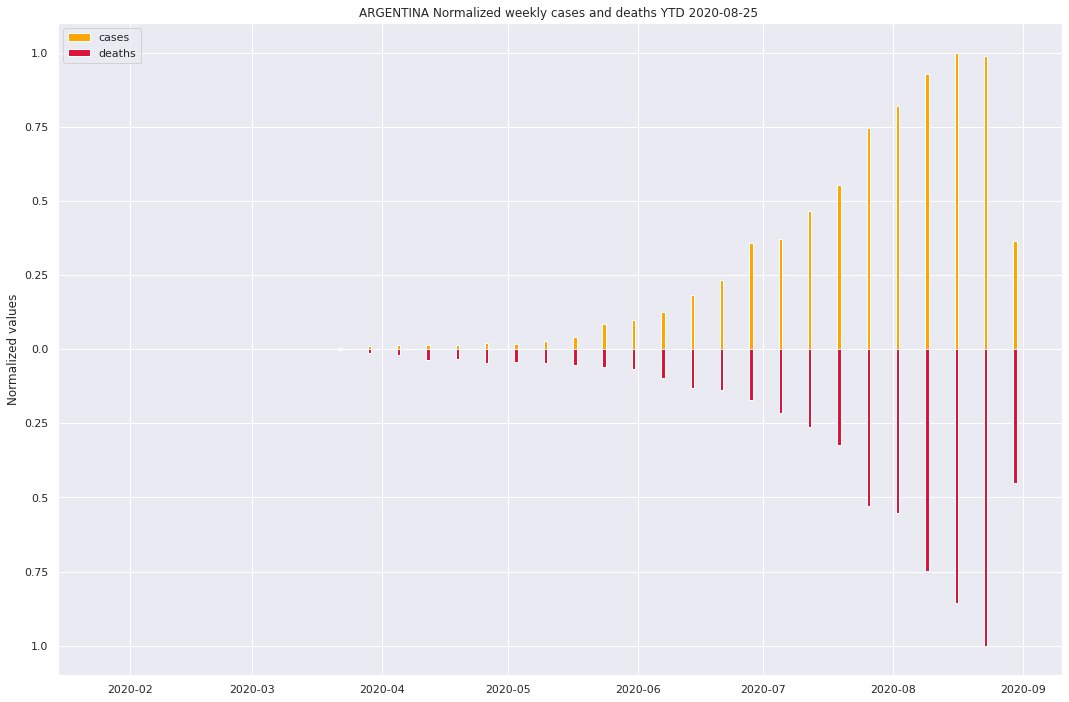

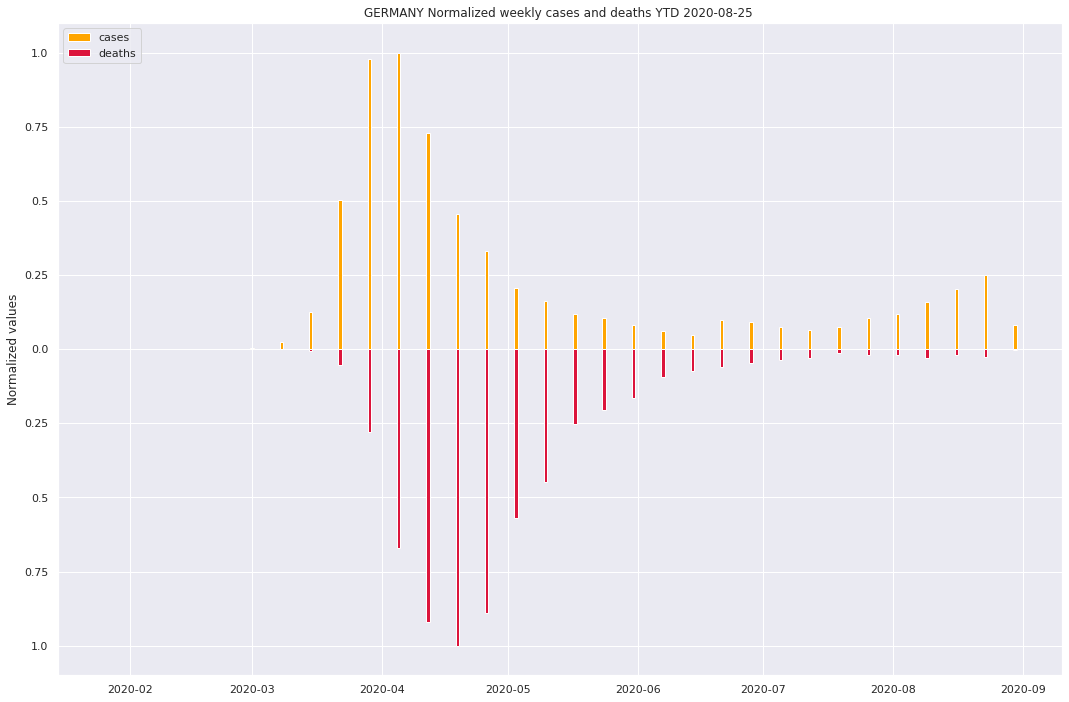

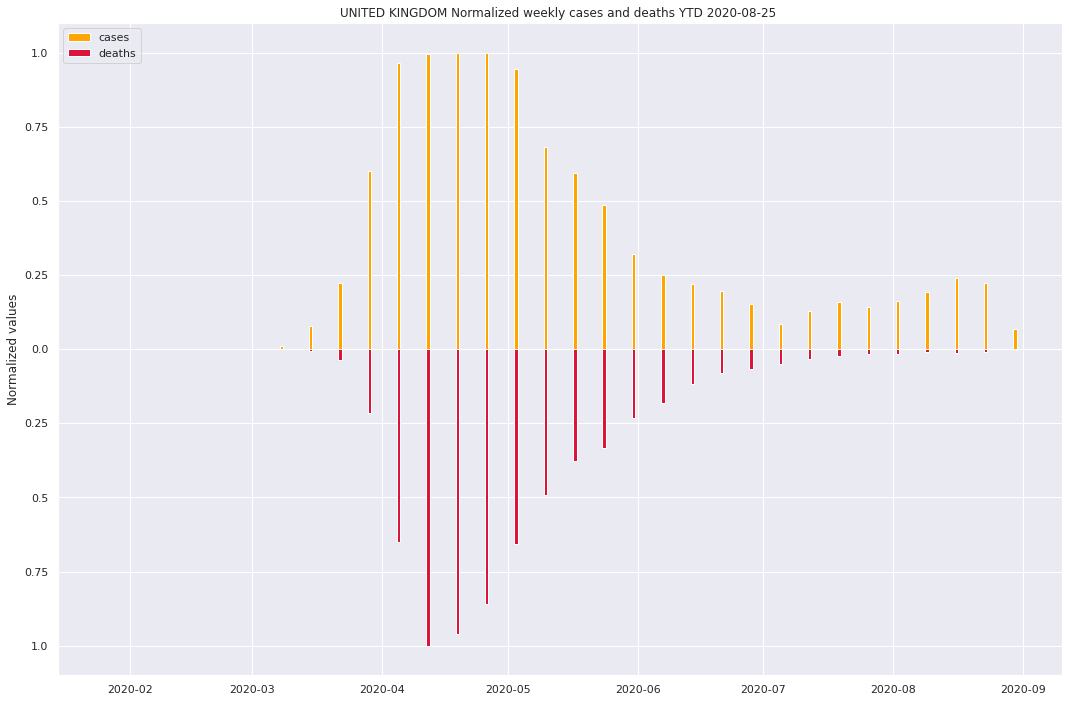

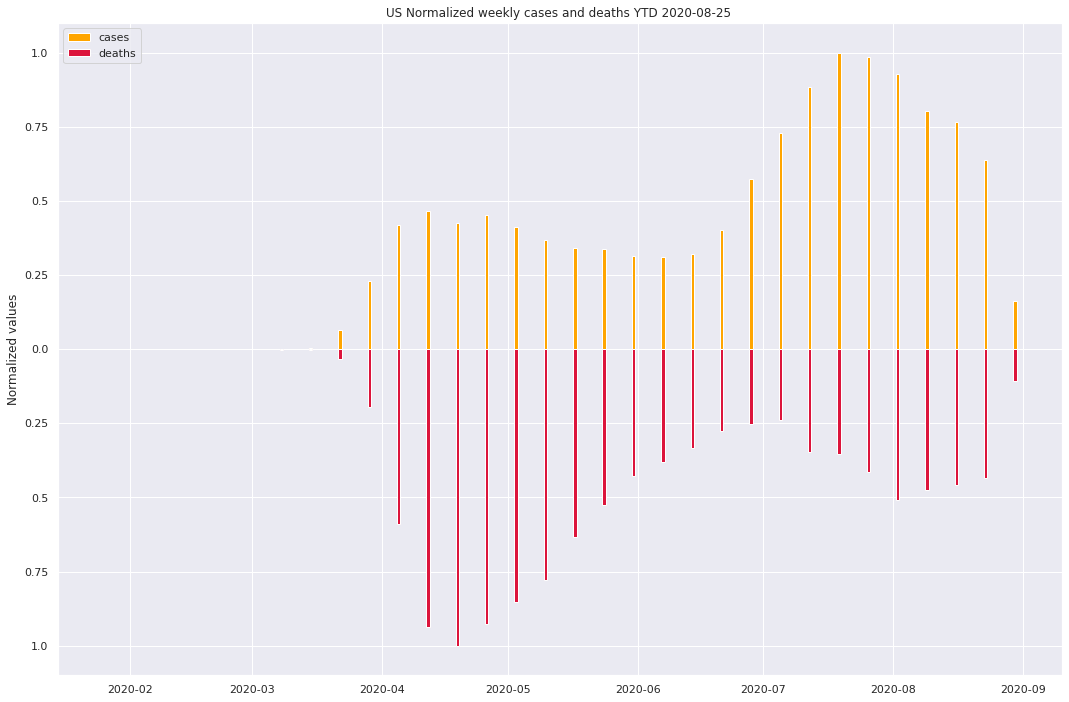

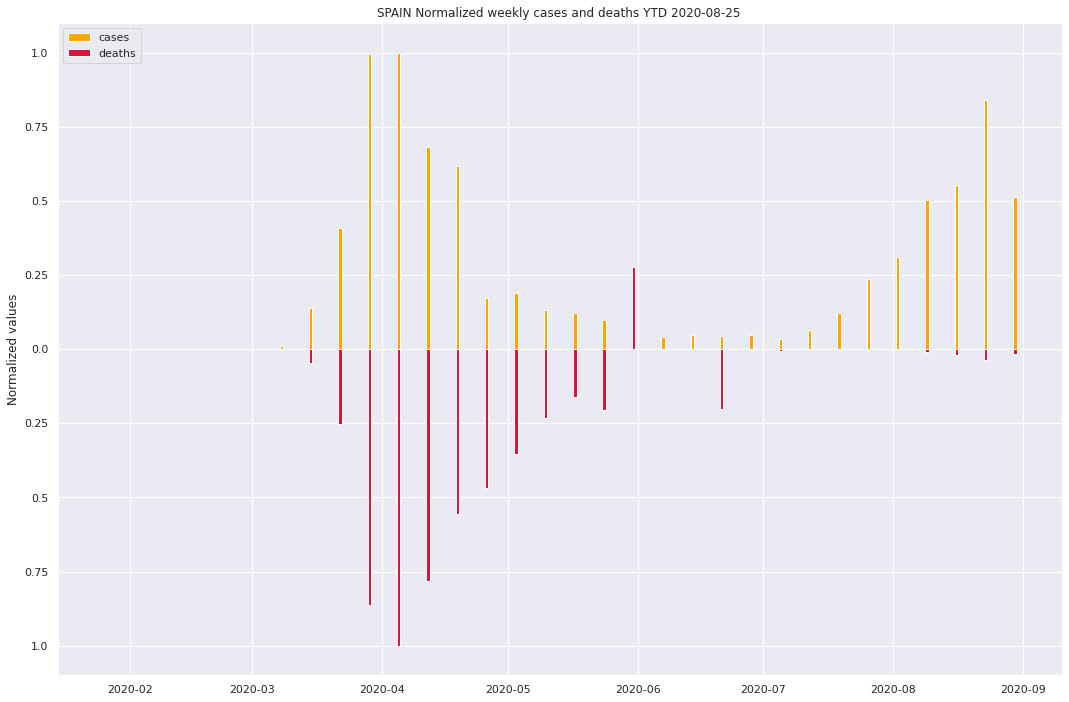

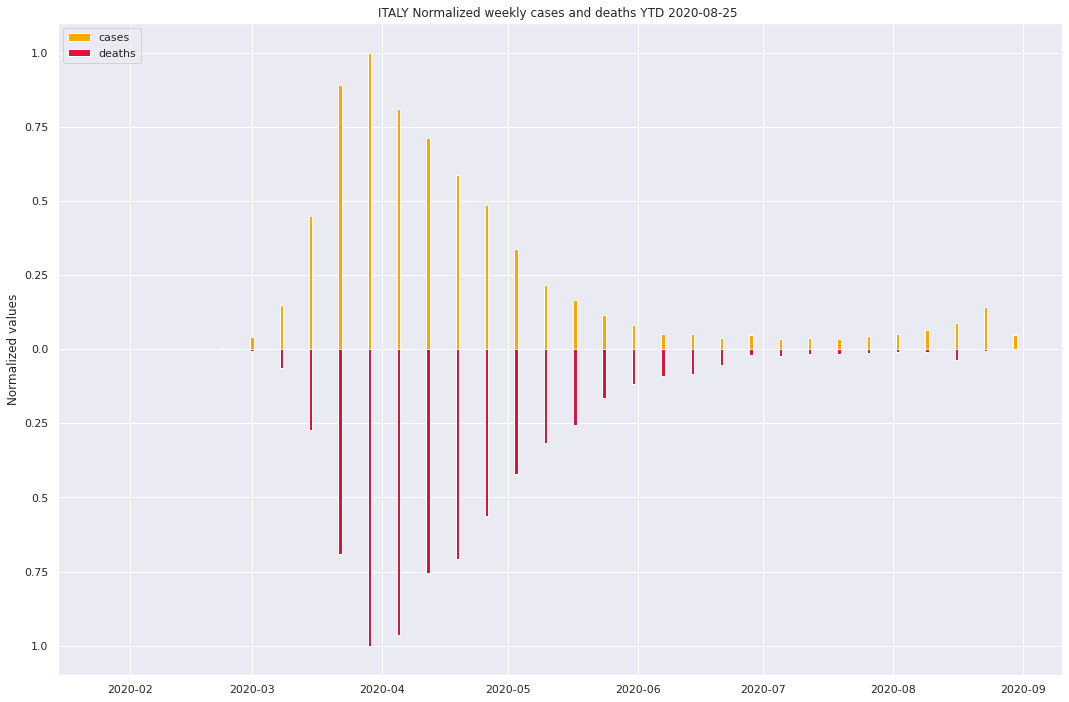

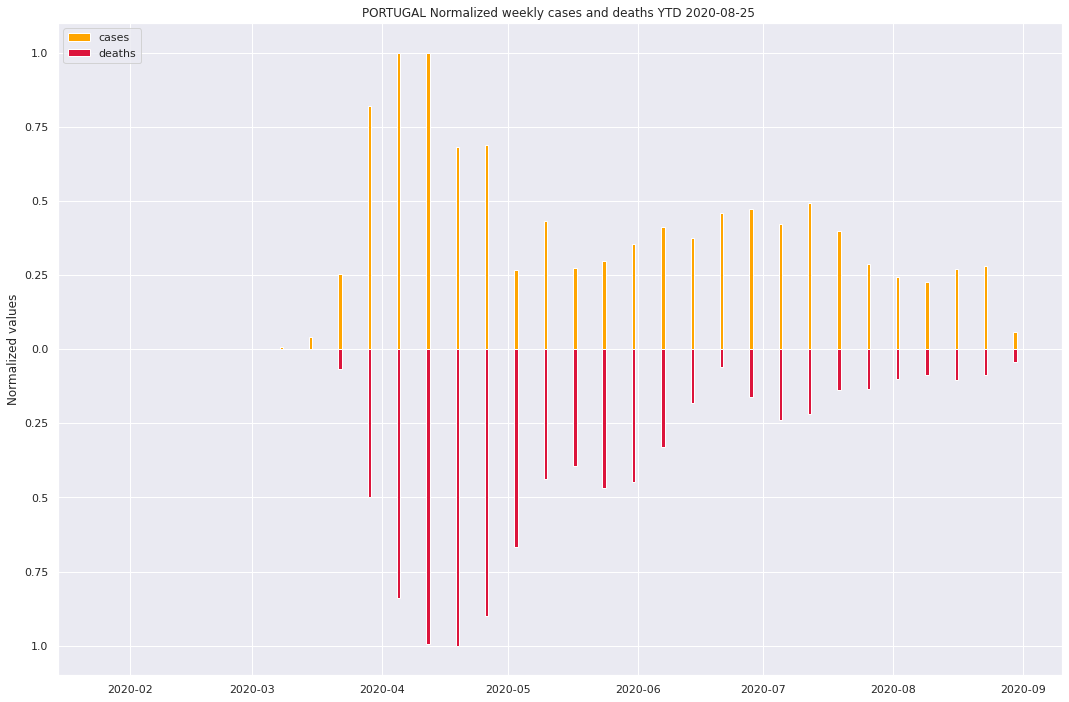

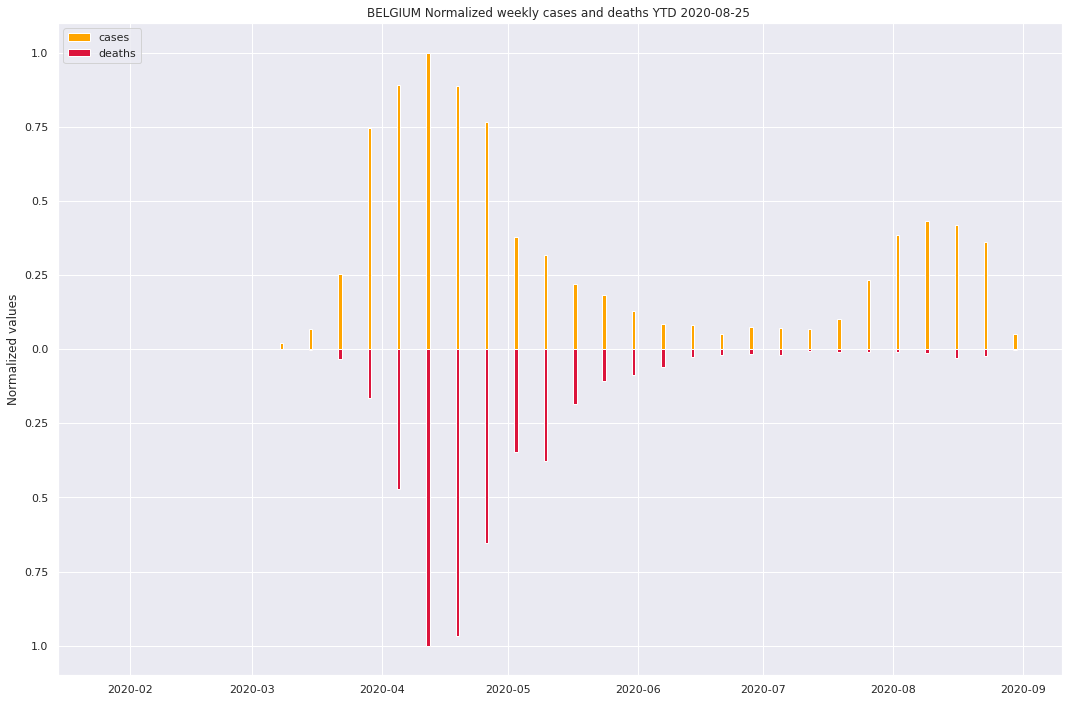

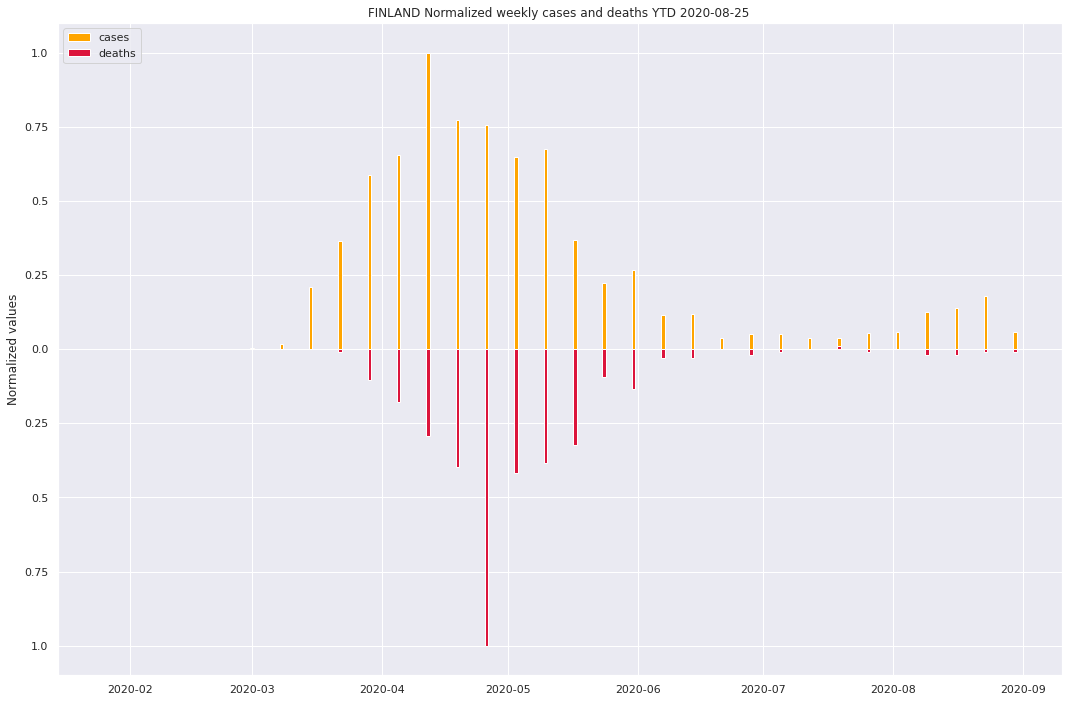

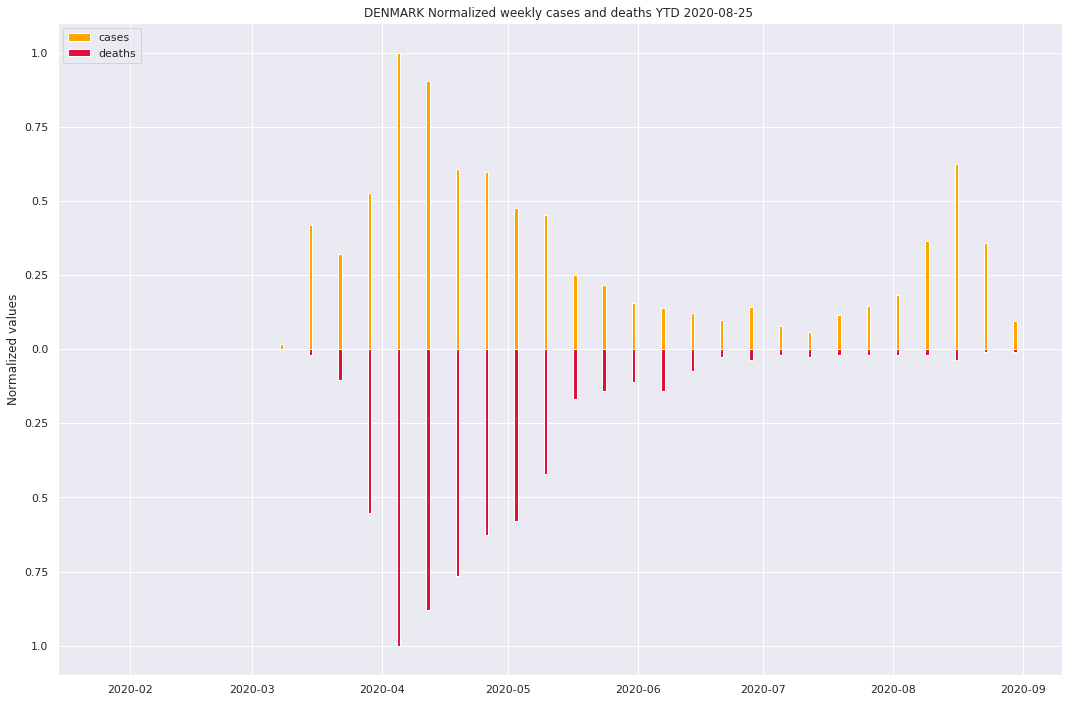

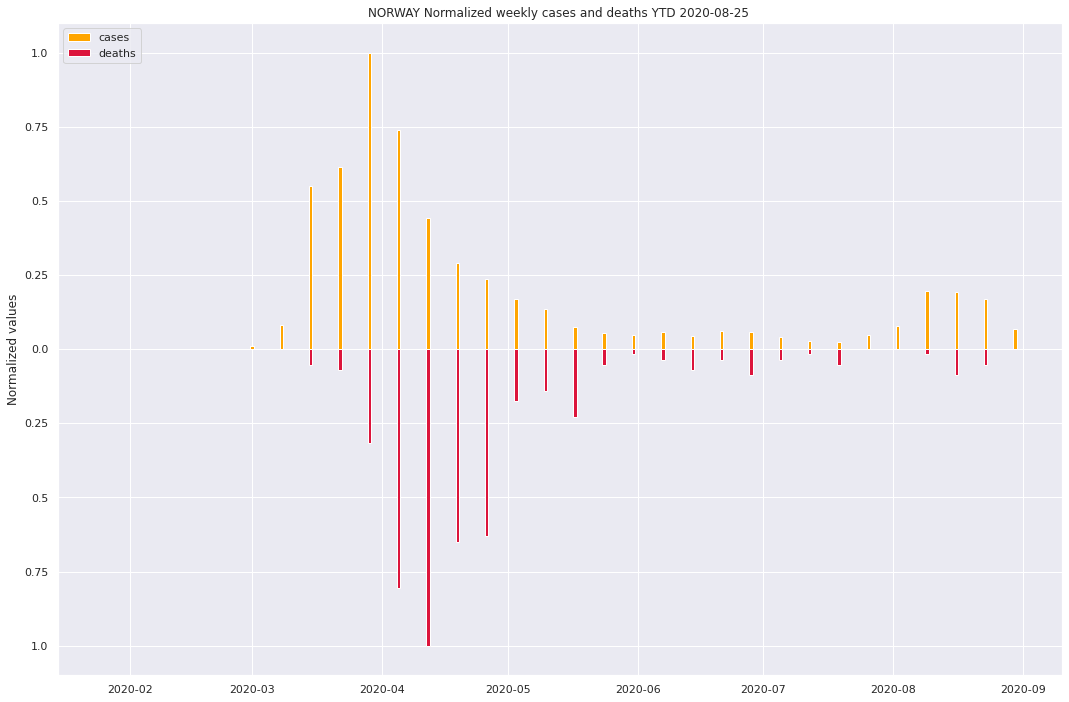

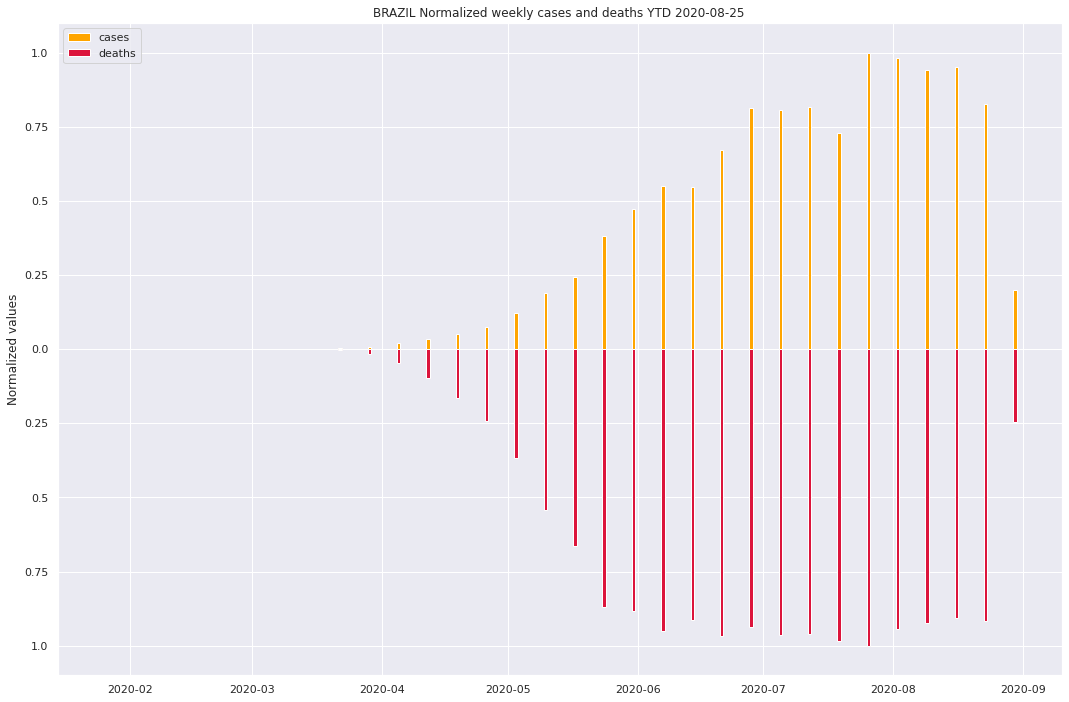

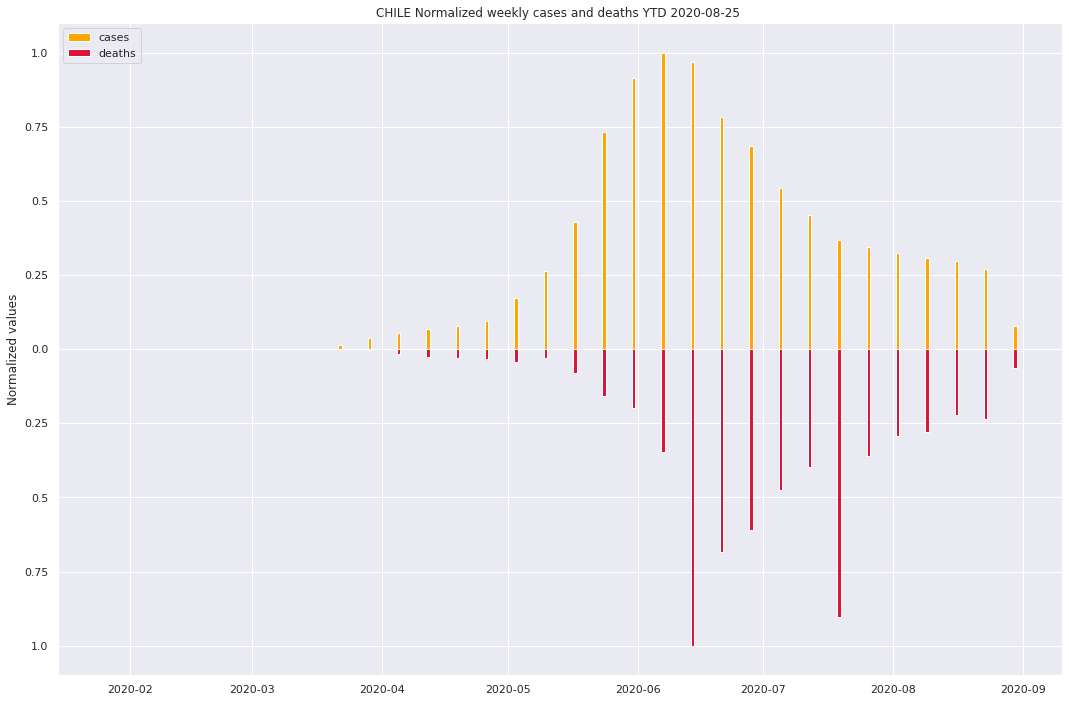

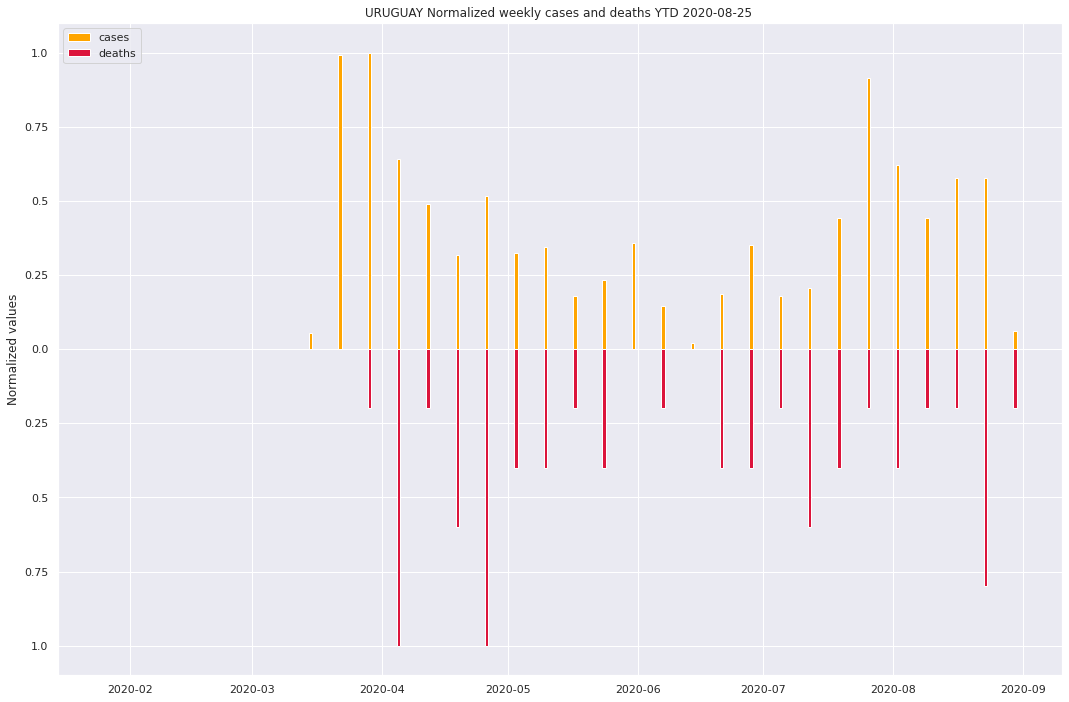

In [23]:
countries = ['New Zealand','Australia','Netherlands','Sweden','Peru','South Africa','Argentina','Germany',
            'United Kingdom','US','Spain','Italy','Portugal','Belgium','Finland','Denmark','Norway','Brazil',
            'Chile','Uruguay']

for c in countries:
    reflexive_plot(c)
    

In [24]:
sa = dick['South Africa'].resample('w').sum()
sa

confirmed     factor      inc  deceased  dead_factor  dead_inc  \
2020-01-26          0   0.000000      0.0         0     0.000000       0.0   
2020-02-02          0   0.000000      0.0         0     0.000000       0.0   
2020-02-09          0   0.000000      0.0         0     0.000000       0.0   
2020-02-16          0   0.000000      0.0         0     0.000000       0.0   
2020-02-23          0   0.000000      0.0         0     0.000000       0.0   
2020-03-01          0   0.000000      0.0         0     0.000000       0.0   
2020-03-08          6   5.000000      3.0         0     0.000000       0.0   
2020-03-15        153  10.835372     48.0         0     0.000000       0.0   
2020-03-22       1106   9.056210    223.0         0     0.000000       0.0   
2020-03-29       6229   8.787536   1006.0         4     3.000000       2.0   
2020-04-05      10266   7.262407    375.0        47     9.188889       9.0   
2020-04-12      13418   7.278882    518.0       135     7.933858      14.0   
2020-04-19      18773   7.385076    985.0       292     7.871152      29.0   
2020-04-26      27480   7.374887   1388.0       508     7.502179      33.0   
2020-05-03      39856   7.412136   2237.0       759     7.426942      44.0   
2020-05-10      59162   7.401375   3232.0      1158     7.405515      63.0   
2020-05-17      90209   7.451874   5500.0      1641     7.317710      70.0   
2020-05-24     134824   7.385767   7068.0      2539     7.504400     165.0   
2020-05-31     194109   7.380165  10100.0      4071     7.482841     254.0   
2020-06-07     286178   7.401978  15602.0      5958     7.390379     315.0   
2020-06-14     415560   7.382177  21753.0      8993     7.406089     482.0   
2020-06-21     591867   7.336738  27264.0     12242     7.271075     450.0   
2020-06-28     832393   7.359426  40832.0     15799     7.245773     526.0   
2020-07-05    1184718   7.362894  58616.0     19956     7.269733     743.0   
2020-07-12    1675693   7.347826  79492.0     26044     7.247607     880.0   
2020-07-19    2274159   7.282338  88086.0     32425     7.213701     954.0   
2020-07-26    2860055   7.203977  81105.0     42341     7.305176    1736.0   
2020-08-02    3373540   7.139690  66052.0     54157     7.215317    1597.0   
2020-08-09    3764764   7.090976  48374.0     66852     7.222120    2042.0   
2020-08-16    4021629   7.048105  27486.0     78724     7.130132    1431.0   
2020-08-23    4198186   7.037579  22428.0     88176     7.098864    1220.0   
2020-08-30    1840168   3.009691   5928.0     39969     3.033558     443.0   

             pct_dead  conf_over_dead  dead_conf_ratio    conf_per_M  \
2020-01-26   0.000000        0.000000         0.000000      0.000000   
2020-02-02   0.000000        0.000000         0.000000      0.000000   
2020-02-09   0.000000        0.000000         0.000000      0.000000   
2020-02-16   0.000000        0.000000         0.000000      0.000000   
2020-02-23   0.000000        0.000000         0.000000      0.000000   
2020-03-01   0.000000        0.000000         0.000000      0.000000   
2020-03-08   0.000000        0.000000         0.000000      0.101166   
2020-03-15   0.000000        0.000000         0.000000      2.579723   
2020-03-22   0.000000        0.000000         0.000000     18.648195   
2020-03-29   0.325966     2997.000000         2.840366    105.026768   
2020-04-05   3.130592     1774.787879         8.874344    173.094364   
2020-04-12   6.942776      736.481239         7.631213    226.240033   
2020-04-19  10.726221      474.056944         7.472061    316.530343   
2020-04-26  12.874754      381.647572         7.120099    463.338509   
2020-05-03  13.310277      368.335521         7.013619    672.009448   
2020-05-10  13.693979      357.884900         7.003843    997.526669   
2020-05-17  12.777124      383.985431         6.875198   1521.008136   
2020-05-24  13.144854      373.327755         7.113070   2273.258775   
2020-05-31  14.686040      333.748781         7.099847   3272.859340 